In [12]:
import os

import nibabel as nib
import scipy.ndimage as ndi
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.preprocessing import minmax_scale
import random
import image_augmentation_util
from tqdm import tqdm

In [2]:
source_data_dir = "../assets/source_images"
output_train_dir = "../assets/train_images/train"
output_val_dir = "../assets/train_images/val"

In [3]:
images = os.listdir(source_data_dir)
print(len(images))

359


In [4]:
images[10]

'CC0011_philips_15_49_F.nii'

In [5]:
def read_3d_image(source_dir):
    three_d_image = nib.load(source_dir)
    
    return three_d_image

In [6]:
def save_slice_from_3d_data(source_dir, slice_number, output_dir, output_filename, max_height, max_width, augment=False):
    # read image
    three_d_image = read_3d_image(source_dir)
    three_d_image_data = three_d_image.get_fdata()
    if augment:
        image_slice = image_augmentation_util.augment_image(three_d_image_data, max_height=max_height, max_width=max_width, thresh_translation=10, thresh_rotation_angle=5, slice_number=slice_number)
        output_path = os.path.join(output_dir, "data", output_filename)
    else:
        image_slice = ndi.rotate(three_d_image_data[:, :, slice_number], 90)
        image_slice = image_augmentation_util.pad_image(image_slice, max_height, max_width)
        output_path = os.path.join(output_dir, "gt", output_filename)
    
    # scale image to 0-255
    scaled_image_slice = minmax_scale(image_slice.ravel(), feature_range=(0,255)).reshape(image_slice.shape)
    
    image_slice_pil = Image.fromarray(scaled_image_slice)
    image_slice_pil = image_slice_pil.convert('L')
    image_slice_pil.save(output_path)
    return scaled_image_slice.shape

In [13]:
# setting seed for reproduction

random.seed(0)

In [14]:
shapes = []

random.shuffle(images)

train_split = 0.9

train_images = images[:int(len(images) * train_split)]
test_images = images[int(len(images) * train_split):]

print("Processing train Images")

for image in tqdm(train_images):
    if image.endswith("DS_Store"):
        continue
        
    output_filename = image.split(".")[0] + ".jpg"

    # save the augmented data in "data" dir
    save_slice_from_3d_data(os.path.join(source_data_dir, image), 160, output_train_dir, output_filename, 288, 256, augment=True)

    # save the ground truth in "gt" directory
    save_slice_from_3d_data(os.path.join(source_data_dir, image), 160, output_train_dir, output_filename, 288, 256, augment=False)
    
print("Processing validation Images")

for image in tqdm(test_images):
    if image.endswith("DS_Store"):
        continue
    
    output_filename = image.split(".")[0] + ".jpg"

    # save the augmented data in "data" dir
    save_slice_from_3d_data(os.path.join(source_data_dir, image), 160, output_val_dir, output_filename, 288, 256, augment=True)

    # save the ground truth in "gt" directory
    save_slice_from_3d_data(os.path.join(source_data_dir, image), 160, output_val_dir, output_filename, 288, 256, augment=False)

Processing train Images


  0%|          | 0/323 [00:00<?, ?it/s]

Translated for -1 pixels
Rotated 3.4601285156107036 degrees in x axis
Rotated -1.5088962802469155 degrees in y axis
Rotated -4.961902525066828 degrees in z axis
Translated for 2 pixels
Rotated 4.991186717924441 degrees in x axis
Rotated 0.13662596789176185 degrees in y axis
Rotated 2.2030118140293276 degrees in z axis
Translated for 3 pixels


  0%|          | 1/323 [00:11<1:03:18, 11.80s/it]

Rotated -3.191748929578484 degrees in x axis
Rotated 3.8919987872219934 degrees in y axis
Rotated 3.145867890039188 degrees in z axis
Translated for -4 pixels
Rotated 4.413665409039481 degrees in x axis
Rotated 3.7369019143245694 degrees in y axis
Rotated 3.698477322425804 degrees in z axis
Translated for 8 pixels
Rotated 0.1339964348656686 degrees in x axis
Rotated -4.318829325777496 degrees in y axis
Rotated -0.9316354268786897 degrees in z axis
Translated for 2 pixels


  1%|          | 2/323 [00:22<58:42, 10.97s/it]  

Rotated 0.819240753890476 degrees in x axis
Rotated -4.942865021530242 degrees in y axis
Rotated 3.387205057852565 degrees in z axis
Translated for -3 pixels
Rotated 2.144576548911971 degrees in x axis
Rotated 4.316771864343664 degrees in y axis
Rotated 1.509977319578808 degrees in z axis
Translated for 2 pixels
Rotated 0.4783639221176541 degrees in x axis
Rotated 0.8690932075903754 degrees in y axis
Rotated 4.535922017768865 degrees in z axis
Translated for 6 pixels


  1%|          | 3/323 [00:32<57:30, 10.78s/it]

Rotated 4.687822743119991 degrees in x axis
Rotated 3.211856131993411 degrees in y axis
Rotated -4.415805792547966 degrees in z axis
Translated for -8 pixels
Rotated 4.271284614342756 degrees in x axis
Rotated -2.125077720494205 degrees in y axis
Rotated 0.3680504567485068 degrees in z axis
Translated for 9 pixels
Rotated 1.4658517006263994 degrees in x axis
Rotated 2.454246227932927 degrees in y axis
Rotated 1.68836211621195 degrees in z axis
Translated for -5 pixels


  1%|          | 4/323 [00:40<51:43,  9.73s/it]

Rotated 2.830071469635403 degrees in x axis
Rotated 3.7746294232194604 degrees in y axis
Rotated 3.7309425330822528 degrees in z axis
Translated for -7 pixels
Rotated 1.0061217392323147 degrees in x axis
Rotated -2.216457197432967 degrees in y axis
Rotated -1.572681914759777 degrees in z axis
Translated for -5 pixels
Rotated 1.898741712877312 degrees in x axis
Rotated 4.695390301755975 degrees in y axis
Rotated -0.9946906733756187 degrees in z axis
Translated for 9 pixels


  2%|▏         | 5/323 [00:51<52:28,  9.90s/it]

Rotated 0.22128001635114458 degrees in x axis
Rotated -4.393173629092384 degrees in y axis
Rotated 3.880043085919686 degrees in z axis
Translated for 1 pixels
Rotated 3.807670584181949 degrees in x axis
Rotated 4.041605955323853 degrees in y axis
Rotated 4.977418894966235 degrees in z axis
Translated for 9 pixels
Rotated -2.944410101706658 degrees in x axis
Rotated -4.913300189962001 degrees in y axis
Rotated -4.57499865399892 degrees in z axis
Translated for -3 pixels


  2%|▏         | 6/323 [00:59<49:09,  9.30s/it]

Rotated 1.9314286458670633 degrees in x axis
Rotated -1.2729173822196946 degrees in y axis
Rotated -3.0575175867364734 degrees in z axis
Translated for 4 pixels
Rotated 4.827193249782379 degrees in x axis
Rotated -3.876423461208627 degrees in y axis
Rotated 4.759641985393554 degrees in z axis
Translated for -9 pixels
Rotated 1.460212959549355 degrees in x axis
Rotated -0.3124893777607607 degrees in y axis
Rotated 4.574018507356245 degrees in z axis
Translated for 5 pixels


  2%|▏         | 7/323 [01:09<50:30,  9.59s/it]

Rotated -2.394776378150204 degrees in x axis
Rotated -2.144870172180935 degrees in y axis
Rotated -4.41521907339674 degrees in z axis
Translated for 1 pixels
Rotated -4.622926486322879 degrees in x axis
Rotated 2.2760972657236014 degrees in y axis
Rotated 0.9285046731424051 degrees in z axis
Translated for -2 pixels
Rotated 0.46043803295994223 degrees in x axis
Rotated 0.29208753436335133 degrees in y axis
Rotated -3.835238458306116 degrees in z axis
Translated for 1 pixels


  2%|▏         | 8/323 [01:19<50:58,  9.71s/it]

Rotated -2.228685174848941 degrees in x axis
Rotated 4.919795639043395 degrees in y axis
Rotated 4.01311418947061 degrees in z axis
Translated for 3 pixels
Rotated -3.649285048893228 degrees in x axis
Rotated -0.21270653386498317 degrees in y axis
Rotated 0.5989690445226241 degrees in z axis
Translated for 3 pixels
Rotated 4.238027737465497 degrees in x axis
Rotated -2.890348664151695 degrees in y axis
Rotated 4.34534681271238 degrees in z axis
Translated for 9 pixels


  3%|▎         | 9/323 [01:29<51:14,  9.79s/it]

Rotated 0.07797596812288621 degrees in x axis
Rotated 1.7602991731561186 degrees in y axis
Rotated -1.1789831998028735 degrees in z axis
Translated for 5 pixels
Rotated -1.4835366618235515 degrees in x axis
Rotated 2.990971521355366 degrees in y axis
Rotated -1.4245918306250704 degrees in z axis
Translated for 1 pixels
Rotated 2.2643967233523057 degrees in x axis
Rotated 2.4887985821776777 degrees in y axis
Rotated 3.064418146057795 degrees in z axis
Translated for -6 pixels


  3%|▎         | 10/323 [01:37<48:19,  9.26s/it]

Rotated 0.7055583879023875 degrees in x axis
Rotated -3.1867569878459068 degrees in y axis
Rotated -4.29592500301828 degrees in z axis
Translated for -10 pixels
Rotated 4.209235020820463 degrees in x axis
Rotated -0.1247042279574897 degrees in y axis
Rotated 1.1727748132705536 degrees in z axis
Translated for -2 pixels
Rotated 4.585323150179846 degrees in x axis
Rotated -3.9609437078268184 degrees in y axis
Rotated -4.776482546900205 degrees in z axis
Translated for 4 pixels


  3%|▎         | 11/323 [01:48<51:48,  9.96s/it]

Rotated 4.534473280337174 degrees in x axis
Rotated 2.9159861567105843 degrees in y axis
Rotated 1.5063380497860095 degrees in z axis
Translated for 1 pixels
Rotated -3.090084160923677 degrees in x axis
Rotated 0.5280384252338326 degrees in y axis
Rotated -2.810884495156513 degrees in z axis
Translated for 7 pixels
Rotated 1.2297013893032451 degrees in x axis
Rotated -2.014654197661275 degrees in y axis
Rotated -3.5862359882340145 degrees in z axis
Translated for 2 pixels


  4%|▎         | 12/323 [01:58<51:19,  9.90s/it]

Rotated -0.9761189027644672 degrees in x axis
Rotated -4.7298379406171085 degrees in y axis
Rotated 0.8311527762834645 degrees in z axis
Translated for 6 pixels
Rotated -3.456712995533995 degrees in x axis
Rotated 3.3705390594815796 degrees in y axis
Rotated -3.7749588820276294 degrees in z axis
Translated for 9 pixels
Rotated 0.8412365054591628 degrees in x axis
Rotated 4.6079913155734324 degrees in y axis
Rotated 0.24201937654299233 degrees in z axis
Translated for 5 pixels


  4%|▍         | 13/323 [02:06<48:22,  9.36s/it]

Rotated -2.192193684114372 degrees in x axis
Rotated -0.18414157182914614 degrees in y axis
Rotated -0.3135061427333987 degrees in z axis
Translated for -8 pixels
Rotated -3.317033515497351 degrees in x axis
Rotated -1.442488475957655 degrees in y axis
Rotated -3.213174665925548 degrees in z axis
Translated for -5 pixels
Rotated -1.257369010124333 degrees in x axis
Rotated -2.3787020546490067 degrees in y axis
Rotated -0.7252301225415358 degrees in z axis
Translated for -8 pixels


  4%|▍         | 14/323 [02:16<49:06,  9.54s/it]

Rotated 4.214583073016213 degrees in x axis
Rotated 1.1612320540605126 degrees in y axis
Rotated 3.2725646665223884 degrees in z axis
Translated for -6 pixels
Rotated 2.9541484388528962 degrees in x axis
Rotated -3.2750404325377924 degrees in y axis
Rotated -0.22498077992887922 degrees in z axis
Translated for 4 pixels
Rotated 3.2849617627069954 degrees in x axis
Rotated 4.402658790577789 degrees in y axis
Rotated -1.7386991701812193 degrees in z axis
Translated for -10 pixels


  5%|▍         | 15/323 [02:24<46:46,  9.11s/it]

Rotated -1.862807286259296 degrees in x axis
Rotated -1.2847507064995933 degrees in y axis
Rotated -0.5610639940355728 degrees in z axis
Translated for 6 pixels
Rotated -2.870212140968502 degrees in x axis
Rotated -1.8247174206955306 degrees in y axis
Rotated 1.8375574857110681 degrees in z axis
Translated for -8 pixels
Rotated -4.497620589406722 degrees in x axis
Rotated -3.2525908162444694 degrees in y axis
Rotated -4.577901917214327 degrees in z axis
Translated for 2 pixels


  5%|▍         | 16/323 [02:34<47:58,  9.38s/it]

Rotated -4.288008896750778 degrees in x axis
Rotated -0.5051439759093848 degrees in y axis
Rotated 4.3925601794229046 degrees in z axis
Translated for 1 pixels
Rotated -0.6720253939744101 degrees in x axis
Rotated 1.0194631935900524 degrees in y axis
Rotated -3.847088433392817 degrees in z axis
Translated for 0 pixels
Rotated -1.7733400376913089 degrees in x axis
Rotated 3.776274009916433 degrees in y axis
Rotated 4.4593365877236515 degrees in z axis
Translated for 0 pixels


  5%|▌         | 17/323 [02:44<48:44,  9.56s/it]

Rotated 3.895809297320925 degrees in x axis
Rotated -2.7738947411817936 degrees in y axis
Rotated -3.1514637688285516 degrees in z axis
Translated for -5 pixels
Rotated -0.209402440651262 degrees in x axis
Rotated -4.563126840177918 degrees in y axis
Rotated 0.39145819049481023 degrees in z axis
Translated for 7 pixels
Rotated 4.939116304802258 degrees in x axis
Rotated 1.3527631850471185 degrees in y axis
Rotated 0.9829079005762997 degrees in z axis
Translated for -1 pixels


  6%|▌         | 18/323 [02:54<49:11,  9.68s/it]

Rotated 1.9994244795513216 degrees in x axis
Rotated 2.6725468293611385 degrees in y axis
Rotated 0.7948377091089673 degrees in z axis
Translated for 6 pixels
Rotated -4.771584202979976 degrees in x axis
Rotated 3.610199945713541 degrees in y axis
Rotated 0.5807017959102883 degrees in z axis
Translated for 5 pixels
Rotated -1.439022242528245 degrees in x axis
Rotated -1.8075930868010728 degrees in y axis
Rotated -0.20200853819426356 degrees in z axis
Translated for -10 pixels


  6%|▌         | 19/323 [03:04<49:24,  9.75s/it]

Rotated 3.856368201891277 degrees in x axis
Rotated -0.7598237976700952 degrees in y axis
Rotated -2.392742039398621 degrees in z axis
Translated for 9 pixels
Rotated 0.5216544602957622 degrees in x axis
Rotated -3.876007802549025 degrees in y axis
Rotated -0.59395899560558 degrees in z axis
Translated for -10 pixels
Rotated 1.7162960156229818 degrees in x axis
Rotated -2.363569094637933 degrees in y axis
Rotated -4.024712326378207 degrees in z axis
Translated for 0 pixels


  6%|▌         | 20/323 [03:14<49:12,  9.74s/it]

Rotated -4.499344790029377 degrees in x axis
Rotated -1.551031970053324 degrees in y axis
Rotated -1.3405838260936243 degrees in z axis
Translated for 6 pixels
Rotated -0.24947911523371147 degrees in x axis
Rotated -0.13904256754535282 degrees in y axis
Rotated -1.3615847441093463 degrees in z axis
Translated for 7 pixels
Rotated -4.968739918493536 degrees in x axis
Rotated -4.07713944534691 degrees in y axis
Rotated 3.9338386331506516 degrees in z axis
Translated for -2 pixels


  7%|▋         | 21/323 [03:23<47:56,  9.53s/it]

Rotated -1.7922240138501455 degrees in x axis
Rotated 4.295771564410039 degrees in y axis
Rotated -3.7601317844193716 degrees in z axis
Translated for 7 pixels
Rotated -2.4751223463195062 degrees in x axis
Rotated -2.7033311100952107 degrees in y axis
Rotated 2.094649787616042 degrees in z axis
Translated for 2 pixels
Rotated -3.1434002214220467 degrees in x axis
Rotated 3.7737473798201027 degrees in y axis
Rotated 4.602494195807337 degrees in z axis
Translated for -5 pixels


  7%|▋         | 22/323 [03:33<48:20,  9.64s/it]

Rotated -4.486523128345601 degrees in x axis
Rotated -4.95402373509168 degrees in y axis
Rotated 1.504884818474399 degrees in z axis
Translated for -2 pixels
Rotated -2.80459844823292 degrees in x axis
Rotated 4.475663017022107 degrees in y axis
Rotated -3.5024697062975862 degrees in z axis
Translated for 3 pixels
Rotated -0.3801887715351002 degrees in x axis
Rotated 3.5869499302413175 degrees in y axis
Rotated 2.6693079902482104 degrees in z axis
Translated for 5 pixels


  7%|▋         | 23/323 [03:43<49:05,  9.82s/it]

Rotated 4.836979692154372 degrees in x axis
Rotated -0.20910075067711364 degrees in y axis
Rotated 3.4187711458292416 degrees in z axis
Translated for 9 pixels
Rotated -2.1257477792592674 degrees in x axis
Rotated 4.43578160485507 degrees in y axis
Rotated -0.8242385407814794 degrees in z axis
Translated for -5 pixels
Rotated 3.234193641396173 degrees in x axis
Rotated -2.718818031217566 degrees in y axis
Rotated -3.983810556692079 degrees in z axis
Translated for 3 pixels


  7%|▋         | 24/323 [03:54<50:42, 10.18s/it]

Rotated 4.171464069370037 degrees in x axis
Rotated 0.8430801006791357 degrees in y axis
Rotated -0.9082196054329481 degrees in z axis
Translated for -5 pixels
Rotated 4.511670583928574 degrees in x axis
Rotated 0.6087797834389352 degrees in y axis
Rotated -1.5619850693306558 degrees in z axis
Translated for -2 pixels
Rotated -1.6299528721006284 degrees in x axis
Rotated -0.7735570174970654 degrees in y axis
Rotated 4.887529467987331 degrees in z axis
Translated for 2 pixels


  8%|▊         | 25/323 [04:06<52:33, 10.58s/it]

Rotated 2.4285178732767774 degrees in x axis
Rotated 3.1320468822699663 degrees in y axis
Rotated 2.0094770181285835 degrees in z axis
Translated for 8 pixels
Rotated -0.16773851820977193 degrees in x axis
Rotated -3.739354830790033 degrees in y axis
Rotated -0.40198888847570924 degrees in z axis
Translated for 1 pixels
Rotated -4.281576755691768 degrees in x axis
Rotated 0.7400268015531513 degrees in y axis
Rotated 4.98139101629593 degrees in z axis
Translated for 6 pixels


  8%|▊         | 26/323 [04:13<47:14,  9.54s/it]

Rotated 3.310820290669195 degrees in x axis
Rotated -3.4156470036532385 degrees in y axis
Rotated -0.6165015034502677 degrees in z axis
Translated for 0 pixels
Rotated -4.955005075242696 degrees in x axis
Rotated 0.0781347448675831 degrees in y axis
Rotated 1.5872339341656279 degrees in z axis
Translated for -8 pixels
Rotated -0.7003105548362596 degrees in x axis
Rotated 1.6484644085384081 degrees in y axis
Rotated 1.2504189490214825 degrees in z axis
Translated for 1 pixels


  8%|▊         | 27/323 [04:24<50:05, 10.16s/it]

Rotated -4.940093715650489 degrees in x axis
Rotated 0.005069071057000052 degrees in y axis
Rotated -1.6048554296522557 degrees in z axis
Translated for -8 pixels
Rotated 2.6111285452595014 degrees in x axis
Rotated -3.568938989176378 degrees in y axis
Rotated 1.490461076064408 degrees in z axis
Translated for 9 pixels
Rotated 1.0440796672921584 degrees in x axis
Rotated -2.537860478614764 degrees in y axis
Rotated -3.0129963449830024 degrees in z axis
Translated for -3 pixels


  9%|▊         | 28/323 [04:35<50:12, 10.21s/it]

Rotated 2.7220462301031816 degrees in x axis
Rotated -1.9599908814597642 degrees in y axis
Rotated 2.649244409517549 degrees in z axis
Translated for -1 pixels
Rotated -0.6919185559581891 degrees in x axis
Rotated -0.6753061616044453 degrees in y axis
Rotated 0.716314315436847 degrees in z axis
Translated for -3 pixels
Rotated -0.5500336479423682 degrees in x axis
Rotated -1.7156873027594397 degrees in y axis
Rotated -4.47644133498443 degrees in z axis
Translated for -10 pixels


  9%|▉         | 29/323 [04:45<50:00, 10.21s/it]

Rotated 3.9578717083847046 degrees in x axis
Rotated -3.3311096117260286 degrees in y axis
Rotated -2.989079272992953 degrees in z axis
Translated for -2 pixels
Rotated -3.3064256749824885 degrees in x axis
Rotated 4.3186543893157445 degrees in y axis
Rotated -1.1441021326798193 degrees in z axis
Translated for 9 pixels
Rotated -3.0841101238473234 degrees in x axis
Rotated -2.4260557270212924 degrees in y axis
Rotated -0.4875836625940835 degrees in z axis
Translated for 6 pixels


  9%|▉         | 30/323 [04:53<46:44,  9.57s/it]

Rotated 1.1514375367794747 degrees in x axis
Rotated -1.151245506245171 degrees in y axis
Rotated -0.9293939925818524 degrees in z axis
Translated for 8 pixels
Rotated -4.940903397068493 degrees in x axis
Rotated -4.065301277456266 degrees in y axis
Rotated 0.18859295949206434 degrees in z axis
Translated for -10 pixels
Rotated 4.6328235292205875 degrees in x axis
Rotated 3.517300348478983 degrees in y axis
Rotated 0.7184466355144883 degrees in z axis
Translated for 5 pixels


 10%|▉         | 31/323 [05:01<44:26,  9.13s/it]

Rotated 2.978732999580963 degrees in x axis
Rotated -4.150569158408169 degrees in y axis
Rotated 3.637899226023336 degrees in z axis
Translated for 1 pixels
Rotated -3.4570983089136185 degrees in x axis
Rotated 2.5434087079801495 degrees in y axis
Rotated -1.0903334905854956 degrees in z axis
Translated for -1 pixels
Rotated 1.1600648035053034 degrees in x axis
Rotated -2.9701177233265517 degrees in y axis
Rotated 2.7095626107745865 degrees in z axis
Translated for -7 pixels


 10%|▉         | 32/323 [05:11<45:09,  9.31s/it]

Rotated -3.626637499260841 degrees in x axis
Rotated -4.5465540875145924 degrees in y axis
Rotated -0.5685164009209185 degrees in z axis
Translated for -3 pixels
Rotated 0.6428943906546944 degrees in x axis
Rotated -0.6366356715273476 degrees in y axis
Rotated -3.0045646493390796 degrees in z axis
Translated for -1 pixels
Rotated 4.52692629160159 degrees in x axis
Rotated -2.079045658579127 degrees in y axis
Rotated 3.5054412629104075 degrees in z axis
Translated for 5 pixels


 10%|█         | 33/323 [05:19<43:20,  8.97s/it]

Rotated -1.2073750047858347 degrees in x axis
Rotated -0.5535177321623586 degrees in y axis
Rotated -4.537862513493827 degrees in z axis
Translated for 2 pixels
Rotated -2.211903385538516 degrees in x axis
Rotated -3.357719793653402 degrees in y axis
Rotated 3.915760532972426 degrees in z axis
Translated for 7 pixels
Rotated -1.8709677520872159 degrees in x axis
Rotated 3.8442091472086997 degrees in y axis
Rotated -0.16171423633527304 degrees in z axis
Translated for -10 pixels


 11%|█         | 34/323 [05:29<44:34,  9.26s/it]

Rotated 1.448404156148328 degrees in x axis
Rotated -0.9325306327699323 degrees in y axis
Rotated -4.227847266250896 degrees in z axis
Translated for -6 pixels
Rotated -3.0023935651504505 degrees in x axis
Rotated 1.7013075932112596 degrees in y axis
Rotated -0.1210368881764321 degrees in z axis
Translated for -8 pixels
Rotated 1.9562166754741366 degrees in x axis
Rotated -1.6562740941709784 degrees in y axis
Rotated -4.286375387853722 degrees in z axis
Translated for -6 pixels


 11%|█         | 35/323 [05:39<45:25,  9.46s/it]

Rotated -2.876297967180884 degrees in x axis
Rotated 2.352296113177596 degrees in y axis
Rotated 4.838447959188368 degrees in z axis
Translated for -9 pixels
Rotated 4.585959963297682 degrees in x axis
Rotated 2.0569401512640866 degrees in y axis
Rotated 0.7180911826950496 degrees in z axis
Translated for -3 pixels
Rotated -2.955969687911708 degrees in x axis
Rotated 3.858390252730361 degrees in y axis
Rotated -0.6201784078616317 degrees in z axis
Translated for 8 pixels


 11%|█         | 36/323 [05:50<47:01,  9.83s/it]

Rotated 2.9639236382897005 degrees in x axis
Rotated 1.1024263834810553 degrees in y axis
Rotated -0.6537194704855338 degrees in z axis
Translated for 2 pixels
Rotated -1.0648005415405528 degrees in x axis
Rotated -1.9964839270194967 degrees in y axis
Rotated 2.2820289174867234 degrees in z axis
Translated for -6 pixels
Rotated -2.5790950059128273 degrees in x axis
Rotated 2.2967870266150916 degrees in y axis
Rotated -0.8533015717972683 degrees in z axis
Translated for -5 pixels


 11%|█▏        | 37/323 [05:58<44:25,  9.32s/it]

Rotated -3.8802337702692205 degrees in x axis
Rotated -4.519820288742231 degrees in y axis
Rotated -1.4183595841989272 degrees in z axis
Translated for -4 pixels
Rotated -4.262594500191833 degrees in x axis
Rotated 4.078316222408583 degrees in y axis
Rotated -2.1178991809870293 degrees in z axis
Translated for 8 pixels
Rotated 3.655727142179405 degrees in x axis
Rotated 0.6549853881823964 degrees in y axis
Rotated 0.13933928526078176 degrees in z axis
Translated for 7 pixels


 12%|█▏        | 38/323 [06:08<45:38,  9.61s/it]

Rotated 3.054001316690023 degrees in x axis
Rotated 0.20728676558090342 degrees in y axis
Rotated 1.7207538070522386 degrees in z axis
Translated for 7 pixels
Rotated 0.25223746136742964 degrees in x axis
Rotated -1.67935388528237 degrees in y axis
Rotated 0.9778810227067716 degrees in z axis
Translated for 2 pixels
Rotated -1.0350834112726015 degrees in x axis
Rotated -1.8738078008676142 degrees in y axis
Rotated 2.3219111783461788 degrees in z axis
Translated for 7 pixels


 12%|█▏        | 39/323 [06:20<48:16, 10.20s/it]

Rotated 3.347265542248506 degrees in x axis
Rotated 1.5618217692593994 degrees in y axis
Rotated 2.862846247493578 degrees in z axis
Translated for 3 pixels
Rotated -2.235462901675346 degrees in x axis
Rotated -0.40275387476069824 degrees in y axis
Rotated -4.219777214295258 degrees in z axis
Translated for -5 pixels
Rotated 4.370394523954285 degrees in x axis
Rotated 4.051183865811145 degrees in y axis
Rotated -2.30753588321017 degrees in z axis
Translated for -7 pixels


 12%|█▏        | 40/323 [06:30<48:15, 10.23s/it]

Rotated 0.7952388008973754 degrees in x axis
Rotated -4.125392235568058 degrees in y axis
Rotated -3.014367938974244 degrees in z axis
Translated for -2 pixels
Rotated -0.31297743688207014 degrees in x axis
Rotated 3.770152102912178 degrees in y axis
Rotated -0.9632354288299938 degrees in z axis
Translated for 6 pixels
Rotated 1.3333751822300322 degrees in x axis
Rotated 1.8442596388690378 degrees in y axis
Rotated 0.8715622658472286 degrees in z axis
Translated for 6 pixels


 13%|█▎        | 41/323 [06:41<49:58, 10.63s/it]

Rotated 2.828386940421317 degrees in x axis
Rotated -0.08240148075095455 degrees in y axis
Rotated 1.7984101205685672 degrees in z axis
Translated for 8 pixels
Rotated 2.597493049557892 degrees in x axis
Rotated 0.11040551754967964 degrees in y axis
Rotated 1.7433736442472512 degrees in z axis
Translated for 5 pixels
Rotated 0.22900064512422436 degrees in x axis
Rotated 0.682514724129164 degrees in y axis
Rotated -1.185204952691051 degrees in z axis
Translated for 8 pixels


 13%|█▎        | 42/323 [06:52<49:20, 10.54s/it]

Rotated -0.8721285228347098 degrees in x axis
Rotated -2.3290499668165543 degrees in y axis
Rotated 0.796441011869419 degrees in z axis
Translated for 0 pixels
Rotated -2.7633548710691294 degrees in x axis
Rotated -0.8975597237122788 degrees in y axis
Rotated 3.7747780316575437 degrees in z axis
Translated for -4 pixels
Rotated 3.4832000364686007 degrees in x axis
Rotated 0.5849044893006106 degrees in y axis
Rotated -2.1830640959883265 degrees in z axis
Translated for 9 pixels


 13%|█▎        | 43/323 [07:02<48:52, 10.47s/it]

Rotated 3.3597215720394296 degrees in x axis
Rotated -1.7999545235435432 degrees in y axis
Rotated 4.267552539307399 degrees in z axis
Translated for 4 pixels
Rotated -4.66765233015075 degrees in x axis
Rotated 3.259746914048357 degrees in y axis
Rotated -0.5366500324571852 degrees in z axis
Translated for 2 pixels
Rotated -4.435300277432503 degrees in x axis
Rotated -0.27532313337457115 degrees in y axis
Rotated -3.980940673398239 degrees in z axis
Translated for 7 pixels


 14%|█▎        | 44/323 [07:12<47:56, 10.31s/it]

Rotated -2.7248116627975003 degrees in x axis
Rotated -0.28232746078227766 degrees in y axis
Rotated -3.7927220141347773 degrees in z axis
Translated for 8 pixels
Rotated 4.6469549632153555 degrees in x axis
Rotated -1.1906641055164902 degrees in y axis
Rotated -3.247132802451124 degrees in z axis
Translated for -10 pixels
Rotated 2.4024046295921515 degrees in x axis
Rotated 0.15763024276235438 degrees in y axis
Rotated -3.302794896599577 degrees in z axis
Translated for -3 pixels


 14%|█▍        | 45/323 [07:23<48:21, 10.44s/it]

Rotated -0.15239367941424575 degrees in x axis
Rotated 0.468261327802308 degrees in y axis
Rotated -3.4063094323546474 degrees in z axis
Translated for -2 pixels
Rotated -0.3210965681338571 degrees in x axis
Rotated -2.6208508771266645 degrees in y axis
Rotated 3.816058758909925 degrees in z axis
Translated for -9 pixels
Rotated -2.9550318048958104 degrees in x axis
Rotated -0.3914721389969875 degrees in y axis
Rotated -3.89435510812684 degrees in z axis
Translated for -5 pixels


 14%|█▍        | 46/323 [07:33<48:04, 10.41s/it]

Rotated 0.06749856534885978 degrees in x axis
Rotated 3.4735178523251093 degrees in y axis
Rotated -3.0275927194762176 degrees in z axis
Translated for 7 pixels
Rotated 2.847843478500252 degrees in x axis
Rotated 0.1524317614266666 degrees in y axis
Rotated 3.2731255164841198 degrees in z axis
Translated for 1 pixels
Rotated 4.060985473511728 degrees in x axis
Rotated 1.0567322400003212 degrees in y axis
Rotated -1.1638737613651093 degrees in z axis
Translated for 6 pixels


 15%|█▍        | 47/323 [07:41<44:41,  9.71s/it]

Rotated 2.5164501302643885 degrees in x axis
Rotated -4.512689950874059 degrees in y axis
Rotated -3.5668027553771067 degrees in z axis
Translated for -6 pixels
Rotated -2.568596423860896 degrees in x axis
Rotated -1.244051172923081 degrees in y axis
Rotated -1.2367910105061073 degrees in z axis
Translated for 2 pixels
Rotated -4.150504770192574 degrees in x axis
Rotated -1.6083839960174737 degrees in y axis
Rotated 3.4530335772811167 degrees in z axis
Translated for -4 pixels


 15%|█▍        | 48/323 [07:49<42:16,  9.22s/it]

Rotated -2.931321551000665 degrees in x axis
Rotated -3.3858369001140867 degrees in y axis
Rotated -4.312898771437769 degrees in z axis
Translated for -1 pixels
Rotated 0.31874177044643126 degrees in x axis
Rotated -4.5251120567306895 degrees in y axis
Rotated 1.2405244330667031 degrees in z axis
Translated for -2 pixels
Rotated 1.6893325464683384 degrees in x axis
Rotated -1.393084997272923 degrees in y axis
Rotated -4.0653986303845215 degrees in z axis
Translated for 1 pixels


 15%|█▌        | 49/323 [07:59<42:42,  9.35s/it]

Rotated 2.1491022307947008 degrees in x axis
Rotated 0.5711980308210762 degrees in y axis
Rotated 1.1059675414382228 degrees in z axis
Translated for 5 pixels
Rotated -4.153718266192461 degrees in x axis
Rotated 0.5172476534940635 degrees in y axis
Rotated -2.4287301690402243 degrees in z axis
Translated for -4 pixels
Rotated 2.752430211714321 degrees in x axis
Rotated 3.3591876699391925 degrees in y axis
Rotated -2.9034220384579843 degrees in z axis
Translated for 3 pixels


 15%|█▌        | 50/323 [08:09<43:35,  9.58s/it]

Rotated -1.1259075938189889 degrees in x axis
Rotated 0.8252029783412373 degrees in y axis
Rotated -2.1779738621689795 degrees in z axis
Translated for -2 pixels
Rotated -3.286712171435522 degrees in x axis
Rotated -4.365649642103584 degrees in y axis
Rotated -2.3310720473896476 degrees in z axis
Translated for 3 pixels
Rotated 0.030367740850127056 degrees in x axis
Rotated 3.5167583245234706 degrees in y axis
Rotated 1.2121199655693342 degrees in z axis
Translated for -5 pixels


 16%|█▌        | 51/323 [08:19<43:43,  9.64s/it]

Rotated 1.9503459438838933 degrees in x axis
Rotated 3.7012887009574573 degrees in y axis
Rotated -1.5564720784781292 degrees in z axis
Translated for 7 pixels
Rotated 2.2024743978267045 degrees in x axis
Rotated 3.8753979491837995 degrees in y axis
Rotated 0.8263631404212806 degrees in z axis
Translated for -10 pixels
Rotated -4.5163024617798175 degrees in x axis
Rotated 4.856085719378241 degrees in y axis
Rotated 0.8253328836005913 degrees in z axis
Translated for -6 pixels


 16%|█▌        | 52/323 [08:29<44:28,  9.85s/it]

Rotated -0.2635530078062276 degrees in x axis
Rotated 1.8830829894381775 degrees in y axis
Rotated -4.477338658467431 degrees in z axis
Translated for 0 pixels
Rotated 2.511387762655791 degrees in x axis
Rotated -3.6384810827237404 degrees in y axis
Rotated -0.6364425117676706 degrees in z axis
Translated for -6 pixels
Rotated 2.8556721280432393 degrees in x axis
Rotated -2.627111488413404 degrees in y axis
Rotated -1.1049586470637243 degrees in z axis
Translated for 7 pixels


 16%|█▋        | 53/323 [08:39<44:32,  9.90s/it]

Rotated 2.6307832044528157 degrees in x axis
Rotated -0.15056356275437466 degrees in y axis
Rotated -0.08458467860113927 degrees in z axis
Translated for -6 pixels
Rotated -0.316961654911859 degrees in x axis
Rotated -4.306782078125418 degrees in y axis
Rotated 4.177930388058575 degrees in z axis
Translated for -1 pixels
Rotated 0.6898928512638101 degrees in x axis
Rotated 4.346783595699984 degrees in y axis
Rotated -3.4954998459075415 degrees in z axis
Translated for 2 pixels


 17%|█▋        | 54/323 [08:49<44:27,  9.92s/it]

Rotated -2.5264379067929834 degrees in x axis
Rotated 0.24152485838351634 degrees in y axis
Rotated -0.9394689127450508 degrees in z axis
Translated for 1 pixels
Rotated 3.1560270742246903 degrees in x axis
Rotated -2.069153375848182 degrees in y axis
Rotated 2.7732005379852085 degrees in z axis
Translated for 5 pixels
Rotated -3.104651738313776 degrees in x axis
Rotated -3.5619542389623318 degrees in y axis
Rotated 2.156452441350063 degrees in z axis
Translated for -10 pixels


 17%|█▋        | 55/323 [08:59<44:39, 10.00s/it]

Rotated -3.6903573858359606 degrees in x axis
Rotated 3.986445412781679 degrees in y axis
Rotated 4.853587712131633 degrees in z axis
Translated for 9 pixels
Rotated -2.267624450656409 degrees in x axis
Rotated 0.696017754175891 degrees in y axis
Rotated -1.3244070261208774 degrees in z axis
Translated for 2 pixels
Rotated 0.33899045935014893 degrees in x axis
Rotated -3.917258557569152 degrees in y axis
Rotated -4.252046544673681 degrees in z axis
Translated for -4 pixels


 17%|█▋        | 56/323 [09:10<44:58, 10.11s/it]

Rotated 1.6495599939654815 degrees in x axis
Rotated 2.8047470731858937 degrees in y axis
Rotated -0.7884024683167379 degrees in z axis
Translated for -6 pixels
Rotated 4.808748928522995 degrees in x axis
Rotated -3.880332428685934 degrees in y axis
Rotated -3.936379517361855 degrees in z axis
Translated for -9 pixels
Rotated 2.3564494868137755 degrees in x axis
Rotated -3.8737847243694334 degrees in y axis
Rotated 1.7333550098019206 degrees in z axis
Translated for 9 pixels


 18%|█▊        | 57/323 [09:20<44:34, 10.06s/it]

Rotated -1.1798728940246428 degrees in x axis
Rotated -0.5815182062841062 degrees in y axis
Rotated 0.9646636003355349 degrees in z axis
Translated for 3 pixels
Rotated -2.3861668868300545 degrees in x axis
Rotated 0.38671986703088024 degrees in y axis
Rotated -3.5941711495289272 degrees in z axis
Translated for -5 pixels
Rotated -4.0014647963281815 degrees in x axis
Rotated -0.43540354449251595 degrees in y axis
Rotated 3.4529744682864987 degrees in z axis
Translated for -10 pixels


 18%|█▊        | 58/323 [09:30<44:17, 10.03s/it]

Rotated -4.8979339955663175 degrees in x axis
Rotated 2.4578380163408227 degrees in y axis
Rotated -3.6917204132344983 degrees in z axis
Translated for -3 pixels
Rotated 0.350495346375963 degrees in x axis
Rotated -0.3201587782861681 degrees in y axis
Rotated 0.6561839053077412 degrees in z axis
Translated for 8 pixels
Rotated -1.5979281993031371 degrees in x axis
Rotated 3.5504713887593056 degrees in y axis
Rotated -2.5120687829796373 degrees in z axis
Translated for -1 pixels


 18%|█▊        | 59/323 [09:40<44:01, 10.00s/it]

Rotated -0.9018472469042038 degrees in x axis
Rotated -4.817310190141045 degrees in y axis
Rotated 0.468416163170831 degrees in z axis
Translated for -9 pixels
Rotated -4.843931707754058 degrees in x axis
Rotated -4.411421661365113 degrees in y axis
Rotated 4.0528021099176375 degrees in z axis
Translated for -4 pixels
Rotated -3.832793963622226 degrees in x axis
Rotated -2.9046889503549655 degrees in y axis
Rotated 4.880775566375426 degrees in z axis
Translated for -2 pixels


 19%|█▊        | 60/323 [09:51<45:57, 10.48s/it]

Rotated 2.9617444434735063 degrees in x axis
Rotated -3.9491324828692353 degrees in y axis
Rotated 0.9194114775841751 degrees in z axis
Translated for -8 pixels
Rotated -2.5552310321918528 degrees in x axis
Rotated 3.6337491358870295 degrees in y axis
Rotated 4.8589252339938565 degrees in z axis
Translated for -3 pixels
Rotated 3.6083506553717104 degrees in x axis
Rotated 4.90766103485544 degrees in y axis
Rotated -2.7715849729638253 degrees in z axis
Translated for 3 pixels


 19%|█▉        | 61/323 [10:01<45:36, 10.44s/it]

Rotated -1.0753833746054555 degrees in x axis
Rotated -4.772428418440868 degrees in y axis
Rotated -0.5659904402719018 degrees in z axis
Translated for -4 pixels
Rotated -1.9719049038919634 degrees in x axis
Rotated -3.754899193867275 degrees in y axis
Rotated -3.2598064158537046 degrees in z axis
Translated for 7 pixels
Rotated -2.386603585750783 degrees in x axis
Rotated 1.2090500984024466 degrees in y axis
Rotated 4.052528893349708 degrees in z axis
Translated for 0 pixels


 19%|█▉        | 62/323 [10:11<44:46, 10.29s/it]

Rotated 2.204644616463691 degrees in x axis
Rotated 2.723232830457577 degrees in y axis
Rotated -3.0962707306864434 degrees in z axis
Translated for -3 pixels
Rotated 4.571421394609409 degrees in x axis
Rotated 0.31707769015184795 degrees in y axis
Rotated 3.604592571680259 degrees in z axis
Translated for -10 pixels
Rotated 2.215374819288451 degrees in x axis
Rotated 1.21475164760104 degrees in y axis
Rotated -1.5404552036258226 degrees in z axis
Translated for 4 pixels


 20%|█▉        | 63/323 [10:23<46:17, 10.68s/it]

Rotated 3.254481286440665 degrees in x axis
Rotated 1.0052058661161292 degrees in y axis
Rotated -4.178329366285882 degrees in z axis
Translated for -10 pixels
Rotated 4.205837228601572 degrees in x axis
Rotated 2.3344065697643748 degrees in y axis
Rotated -4.305985508075497 degrees in z axis
Translated for 9 pixels
Rotated -4.785092899433643 degrees in x axis
Rotated 3.4030958474881032 degrees in y axis
Rotated 0.6642990126849728 degrees in z axis
Translated for 9 pixels


 20%|█▉        | 64/323 [10:31<42:43,  9.90s/it]

Rotated 2.8476485920874506 degrees in x axis
Rotated 3.9087259173946283 degrees in y axis
Rotated 2.1852977854886806 degrees in z axis
Translated for 7 pixels
Rotated -1.7218837008259702 degrees in x axis
Rotated 0.5944741193864553 degrees in y axis
Rotated -2.109905410874492 degrees in z axis
Translated for -3 pixels
Rotated 3.617714783444205 degrees in x axis
Rotated 4.9198395529712045 degrees in y axis
Rotated 3.654540416165812 degrees in z axis
Translated for 3 pixels


 20%|██        | 65/323 [10:43<44:44, 10.41s/it]

Rotated -0.4657768820872512 degrees in x axis
Rotated -0.8519227869099391 degrees in y axis
Rotated 2.5753206584850137 degrees in z axis
Translated for 0 pixels
Rotated -3.8225694395461463 degrees in x axis
Rotated -0.2451231812460577 degrees in y axis
Rotated 1.2516883240446166 degrees in z axis
Translated for 1 pixels
Rotated -2.5340571429744574 degrees in x axis
Rotated -3.007734419202661 degrees in y axis
Rotated -4.677957811760698 degrees in z axis
Translated for -2 pixels


 20%|██        | 66/323 [10:53<44:23, 10.36s/it]

Rotated 4.604175737170152 degrees in x axis
Rotated 0.8118509590591074 degrees in y axis
Rotated -2.12396884177398 degrees in z axis
Translated for -2 pixels
Rotated 4.8774803407180585 degrees in x axis
Rotated -3.229571053812379 degrees in y axis
Rotated -2.1882001017171993 degrees in z axis
Translated for 4 pixels
Rotated 1.1610086215966398 degrees in x axis
Rotated -0.8309680594524851 degrees in y axis
Rotated 1.7705197739563685 degrees in z axis
Translated for 4 pixels


 21%|██        | 67/323 [11:03<43:31, 10.20s/it]

Rotated 2.207552058158816 degrees in x axis
Rotated 2.496313677593034 degrees in y axis
Rotated 3.0138269051684823 degrees in z axis
Translated for 7 pixels
Rotated -0.10379029064899292 degrees in x axis
Rotated 2.4706619028239594 degrees in y axis
Rotated -2.976584694855351 degrees in z axis
Translated for 2 pixels
Rotated -4.904625472750172 degrees in x axis
Rotated 1.1734635271454792 degrees in y axis
Rotated 4.843920763427748 degrees in z axis
Translated for 3 pixels


 21%|██        | 68/323 [11:14<44:13, 10.41s/it]

Rotated -3.823048717566142 degrees in x axis
Rotated 0.16985053641729486 degrees in y axis
Rotated 2.475623083439676 degrees in z axis
Translated for 9 pixels
Rotated -4.23989957093443 degrees in x axis
Rotated -0.9652156525358286 degrees in y axis
Rotated 0.2269643483936088 degrees in z axis
Translated for -2 pixels
Rotated 1.2553141425586576 degrees in x axis
Rotated 3.9392680832971436 degrees in y axis
Rotated 1.352523704373593 degrees in z axis
Translated for 6 pixels


 21%|██▏       | 69/323 [11:24<43:30, 10.28s/it]

Rotated 2.071890507362916 degrees in x axis
Rotated -0.15326232680853646 degrees in y axis
Rotated -0.8038368338377921 degrees in z axis
Translated for 7 pixels
Rotated -2.278543630905273 degrees in x axis
Rotated -4.434222968931554 degrees in y axis
Rotated -2.6437789847895443 degrees in z axis
Translated for -8 pixels
Rotated -0.4816129670138656 degrees in x axis
Rotated 3.6972273339415054 degrees in y axis
Rotated 0.518224055273774 degrees in z axis
Translated for 4 pixels


 22%|██▏       | 70/323 [11:32<40:35,  9.62s/it]

Rotated -4.913839706494354 degrees in x axis
Rotated 4.57503165124521 degrees in y axis
Rotated 3.4992823824790396 degrees in z axis
Translated for 6 pixels
Rotated -4.808499132951343 degrees in x axis
Rotated -0.7320187556766742 degrees in y axis
Rotated 3.3102628369358325 degrees in z axis
Translated for -4 pixels
Rotated -0.7339327492293437 degrees in x axis
Rotated -3.229965446084331 degrees in y axis
Rotated 0.25324046091085517 degrees in z axis
Translated for 7 pixels


 22%|██▏       | 71/323 [11:42<41:05,  9.79s/it]

Rotated 4.599942208334216 degrees in x axis
Rotated -2.2830557106539895 degrees in y axis
Rotated 3.3811814584922963 degrees in z axis
Translated for -2 pixels
Rotated 4.119869531475533 degrees in x axis
Rotated -0.6749436701587372 degrees in y axis
Rotated -2.6164691290912465 degrees in z axis
Translated for 5 pixels
Rotated 3.097880772293353 degrees in x axis
Rotated 0.9969364412517825 degrees in y axis
Rotated -0.7719502980243078 degrees in z axis
Translated for -2 pixels


 22%|██▏       | 72/323 [11:52<41:40,  9.96s/it]

Rotated -4.4384896446851565 degrees in x axis
Rotated -4.097342145254982 degrees in y axis
Rotated -2.116393958651075 degrees in z axis
Translated for 6 pixels
Rotated -0.5660904734608199 degrees in x axis
Rotated -3.5936038288666783 degrees in y axis
Rotated -3.718531482844327 degrees in z axis
Translated for 0 pixels
Rotated 0.6943211193205121 degrees in x axis
Rotated -3.9644149918378746 degrees in y axis
Rotated 4.393487017648361 degrees in z axis
Translated for -5 pixels


 23%|██▎       | 73/323 [12:00<39:10,  9.40s/it]

Rotated -4.344893549547525 degrees in x axis
Rotated -4.250148114359288 degrees in y axis
Rotated -4.073274147999305 degrees in z axis
Translated for 2 pixels
Rotated -4.186557446397968 degrees in x axis
Rotated 0.30343592251974094 degrees in y axis
Rotated -4.539153742729591 degrees in z axis
Translated for -9 pixels
Rotated -3.6095635210072565 degrees in x axis
Rotated 1.0686407675665333 degrees in y axis
Rotated -0.5910696129308421 degrees in z axis
Translated for 2 pixels


 23%|██▎       | 74/323 [12:11<39:59,  9.64s/it]

Rotated 0.8869311624546015 degrees in x axis
Rotated 3.5918759182632005 degrees in y axis
Rotated 2.926255930602766 degrees in z axis
Translated for -2 pixels
Rotated 2.765705151207049 degrees in x axis
Rotated -3.429599574315847 degrees in y axis
Rotated -2.5063878428309607 degrees in z axis
Translated for 7 pixels
Rotated 2.8107540617646745 degrees in x axis
Rotated 1.3198238130066127 degrees in y axis
Rotated -0.19325360487283927 degrees in z axis
Translated for 0 pixels


 23%|██▎       | 75/323 [12:18<36:42,  8.88s/it]

Rotated -0.9423299028136096 degrees in x axis
Rotated 2.4855123326970574 degrees in y axis
Rotated -0.22945145243756038 degrees in z axis
Translated for -9 pixels
Rotated 3.1331286994702463 degrees in x axis
Rotated -3.026708186487106 degrees in y axis
Rotated 4.3038729366863215 degrees in z axis
Translated for 2 pixels
Rotated 3.1851439721275874 degrees in x axis
Rotated -4.251025719457472 degrees in y axis
Rotated 0.5393015755775821 degrees in z axis
Translated for -9 pixels


 24%|██▎       | 76/323 [12:28<38:09,  9.27s/it]

Rotated 0.46631995505283275 degrees in x axis
Rotated -0.41912240910542664 degrees in y axis
Rotated -1.7071644420642573 degrees in z axis
Translated for 1 pixels
Rotated 1.6312809573133755 degrees in x axis
Rotated 3.044031284391135 degrees in y axis
Rotated 1.7309081070774006 degrees in z axis
Translated for -3 pixels
Rotated -1.912026530102536 degrees in x axis
Rotated -3.8035774356410315 degrees in y axis
Rotated -2.336316306948479 degrees in z axis
Translated for -4 pixels


 24%|██▍       | 77/323 [12:36<36:35,  8.92s/it]

Rotated -2.544768774655487 degrees in x axis
Rotated -0.4867576775716964 degrees in y axis
Rotated 0.7454214588407719 degrees in z axis
Translated for -2 pixels
Rotated 0.5684844873719026 degrees in x axis
Rotated -1.9319473333337411 degrees in y axis
Rotated -2.2153275477312837 degrees in z axis
Translated for 0 pixels
Rotated 3.085064915465958 degrees in x axis
Rotated -0.5252821209418554 degrees in y axis
Rotated -2.8182493593840894 degrees in z axis
Translated for -5 pixels


 24%|██▍       | 78/323 [12:47<39:37,  9.70s/it]

Rotated -0.7572686944138285 degrees in x axis
Rotated 1.102141336141326 degrees in y axis
Rotated -3.7542377328637597 degrees in z axis
Translated for 5 pixels
Rotated -3.485036906679946 degrees in x axis
Rotated 4.62532468505829 degrees in y axis
Rotated -1.7339323228416923 degrees in z axis
Translated for 5 pixels
Rotated -2.9449348443697856 degrees in x axis
Rotated 1.3612629969662038 degrees in y axis
Rotated 1.8485347046107181 degrees in z axis
Translated for 9 pixels


 24%|██▍       | 79/323 [12:59<41:45, 10.27s/it]

Rotated 2.7273576618215367 degrees in x axis
Rotated -2.4651395784813204 degrees in y axis
Rotated -3.802225172754966 degrees in z axis
Translated for -5 pixels
Rotated -4.73140118993955 degrees in x axis
Rotated -0.6208145434462189 degrees in y axis
Rotated -1.0560154189597268 degrees in z axis
Translated for 6 pixels
Rotated 0.777332737617396 degrees in x axis
Rotated 3.7520236036445596 degrees in y axis
Rotated -3.835880805652164 degrees in z axis
Translated for 2 pixels


 25%|██▍       | 80/323 [13:09<41:38, 10.28s/it]

Rotated -0.2661908515945175 degrees in x axis
Rotated -1.8260350443634765 degrees in y axis
Rotated 4.782338371116108 degrees in z axis
Translated for -1 pixels
Rotated 4.89198352560895 degrees in x axis
Rotated -4.6429569616173385 degrees in y axis
Rotated -4.366355662819018 degrees in z axis
Translated for -1 pixels
Rotated 2.6252411007934366 degrees in x axis
Rotated 4.271044403973583 degrees in y axis
Rotated -1.4198837471807724 degrees in z axis
Translated for -8 pixels


 25%|██▌       | 81/323 [13:20<42:14, 10.48s/it]

Rotated 4.823407207880187 degrees in x axis
Rotated -4.869992605262014 degrees in y axis
Rotated -2.033145957424922 degrees in z axis
Translated for 5 pixels
Rotated -4.827722025942261 degrees in x axis
Rotated -4.695284282246279 degrees in y axis
Rotated 1.9124307428500131 degrees in z axis
Translated for 3 pixels
Rotated 4.927345588185478 degrees in x axis
Rotated -2.1274341826701404 degrees in y axis
Rotated -4.983904380190061 degrees in z axis
Translated for 6 pixels


 25%|██▌       | 82/323 [13:31<41:53, 10.43s/it]

Rotated 3.0473204753687746 degrees in x axis
Rotated 3.8693948048018783 degrees in y axis
Rotated -3.4402206641015933 degrees in z axis
Translated for 6 pixels
Rotated -2.4011206842577772 degrees in x axis
Rotated 4.62289870741137 degrees in y axis
Rotated -3.9896903029992137 degrees in z axis
Translated for -4 pixels
Rotated -3.1833786948284737 degrees in x axis
Rotated 2.147139245816165 degrees in y axis
Rotated -4.134749129746017 degrees in z axis
Translated for 3 pixels


 26%|██▌       | 83/323 [13:41<41:24, 10.35s/it]

Rotated -0.344679156149061 degrees in x axis
Rotated 0.8070133782171407 degrees in y axis
Rotated -2.7866970558421755 degrees in z axis
Translated for -9 pixels
Rotated -0.057119533992686655 degrees in x axis
Rotated 0.9175530058411905 degrees in y axis
Rotated 3.0447424939673127 degrees in z axis
Translated for -1 pixels
Rotated -3.2939262008305192 degrees in x axis
Rotated 3.8245285371759667 degrees in y axis
Rotated -1.7704401902182552 degrees in z axis
Translated for -5 pixels


 26%|██▌       | 84/323 [13:51<40:43, 10.23s/it]

Rotated 0.7782917522320449 degrees in x axis
Rotated -2.442820227614236 degrees in y axis
Rotated -2.287843524685794 degrees in z axis
Translated for 3 pixels
Rotated 1.5853757199906031 degrees in x axis
Rotated -2.1646308142933277 degrees in y axis
Rotated -2.300866668884478 degrees in z axis
Translated for -7 pixels
Rotated 2.7915777829351622 degrees in x axis
Rotated 2.055650169669626 degrees in y axis
Rotated -3.4696443019808565 degrees in z axis
Translated for 6 pixels


 26%|██▋       | 85/323 [14:00<38:52,  9.80s/it]

Rotated -0.8035694615408691 degrees in x axis
Rotated 3.1045258127740354 degrees in y axis
Rotated -3.5681658583177542 degrees in z axis
Translated for 9 pixels
Rotated -3.1843590879399732 degrees in x axis
Rotated 0.12268616512646346 degrees in y axis
Rotated 2.774677362230814 degrees in z axis
Translated for 2 pixels
Rotated -1.184144593614814 degrees in x axis
Rotated 1.1744634563549212 degrees in y axis
Rotated 3.7760795976667954 degrees in z axis
Translated for 9 pixels


 27%|██▋       | 86/323 [14:10<39:09,  9.92s/it]

Rotated -0.6942328467050913 degrees in x axis
Rotated -2.821807296686869 degrees in y axis
Rotated -0.06110315560203006 degrees in z axis
Translated for 7 pixels
Rotated 2.3947022807179277 degrees in x axis
Rotated 0.3718085834921281 degrees in y axis
Rotated 1.6463971842753633 degrees in z axis
Translated for 7 pixels
Rotated -4.084474085569677 degrees in x axis
Rotated -4.59495697787725 degrees in y axis
Rotated -3.5079095745210207 degrees in z axis
Translated for 7 pixels


 27%|██▋       | 87/323 [14:18<36:51,  9.37s/it]

Rotated -2.8219418712954134 degrees in x axis
Rotated 3.9020401939074247 degrees in y axis
Rotated 4.609516150903515 degrees in z axis
Translated for 7 pixels
Rotated -0.5667809112018869 degrees in x axis
Rotated 3.4860794999186115 degrees in y axis
Rotated -4.553540691490405 degrees in z axis
Translated for -4 pixels
Rotated -3.489586189456373 degrees in x axis
Rotated 4.403401881927193 degrees in y axis
Rotated -0.6174177632333073 degrees in z axis
Translated for 5 pixels


 27%|██▋       | 88/323 [14:28<37:08,  9.48s/it]

Rotated 3.947631470913212 degrees in x axis
Rotated 2.2539867680407886 degrees in y axis
Rotated 0.7563157894117065 degrees in z axis
Translated for 0 pixels
Rotated -0.8588820589462802 degrees in x axis
Rotated 4.848328183645101 degrees in y axis
Rotated -1.5530136903990757 degrees in z axis
Translated for 2 pixels
Rotated -3.0986697563280763 degrees in x axis
Rotated -4.337879294035049 degrees in y axis
Rotated -1.4385784991277593 degrees in z axis
Translated for -10 pixels


 28%|██▊       | 89/323 [14:38<37:46,  9.68s/it]

Rotated 2.0608106835987154 degrees in x axis
Rotated 3.995437031926704 degrees in y axis
Rotated -3.176114893569928 degrees in z axis
Translated for 8 pixels
Rotated 1.6003641188651718 degrees in x axis
Rotated 4.267321332279547 degrees in y axis
Rotated -2.3671821771857404 degrees in z axis
Translated for 2 pixels
Rotated 3.473365200598238 degrees in x axis
Rotated 2.6605653945859933 degrees in y axis
Rotated 0.3866243258378965 degrees in z axis
Translated for -3 pixels


 28%|██▊       | 90/323 [14:48<37:54,  9.76s/it]

Rotated 0.2801407355249319 degrees in x axis
Rotated -2.7811684455752825 degrees in y axis
Rotated -0.4221778077006233 degrees in z axis
Translated for -2 pixels
Rotated -2.134044862573062 degrees in x axis
Rotated 2.6045077268433623 degrees in y axis
Rotated 2.4992290313203984 degrees in z axis
Translated for -1 pixels
Rotated -0.3424228592927294 degrees in x axis
Rotated -0.4214029107830779 degrees in y axis
Rotated 1.661820607222202 degrees in z axis
Translated for -9 pixels


 28%|██▊       | 91/323 [14:57<37:46,  9.77s/it]

Rotated 0.12087883027524615 degrees in x axis
Rotated 4.747559551762031 degrees in y axis
Rotated -1.0089692730219832 degrees in z axis
Translated for 1 pixels
Rotated -3.1045769814133184 degrees in x axis
Rotated 2.2524387567534756 degrees in y axis
Rotated 4.133397705641229 degrees in z axis
Translated for -7 pixels
Rotated -0.25030176218428934 degrees in x axis
Rotated -3.536201839116612 degrees in y axis
Rotated -3.230799537028929 degrees in z axis
Translated for 6 pixels


 28%|██▊       | 92/323 [15:06<35:40,  9.27s/it]

Rotated 4.084100381537798 degrees in x axis
Rotated -2.652238019290359 degrees in y axis
Rotated -1.5239202177060198 degrees in z axis
Translated for 8 pixels
Rotated -2.8494247043856835 degrees in x axis
Rotated -4.701588033630295 degrees in y axis
Rotated 2.658916363619954 degrees in z axis
Translated for -9 pixels
Rotated 1.6865313553584382 degrees in x axis
Rotated 4.943373239070715 degrees in y axis
Rotated -0.4423988069685585 degrees in z axis
Translated for 4 pixels


 29%|██▉       | 93/323 [15:16<36:33,  9.54s/it]

Rotated -3.9042283280566226 degrees in x axis
Rotated 0.4518117045647374 degrees in y axis
Rotated -1.8253159613722003 degrees in z axis
Translated for 2 pixels
Rotated -4.881376956925515 degrees in x axis
Rotated 1.5345156685106751 degrees in y axis
Rotated 1.1461793024299585 degrees in z axis
Translated for -7 pixels
Rotated -1.6757588622995123 degrees in x axis
Rotated -2.2910545261346216 degrees in y axis
Rotated -1.2215332794636868 degrees in z axis
Translated for 6 pixels


 29%|██▉       | 94/323 [15:27<38:44, 10.15s/it]

Rotated 1.5452227135605225 degrees in x axis
Rotated 3.0197938042591623 degrees in y axis
Rotated 0.9176366987295514 degrees in z axis
Translated for -9 pixels
Rotated 0.24805250613840002 degrees in x axis
Rotated 0.36221961204139763 degrees in y axis
Rotated -2.732341843286372 degrees in z axis
Translated for 7 pixels
Rotated 4.670130943828179 degrees in x axis
Rotated 4.630291473515021 degrees in y axis
Rotated -1.062052484982007 degrees in z axis
Translated for 4 pixels


 29%|██▉       | 95/323 [15:37<38:34, 10.15s/it]

Rotated 1.1505993225109465 degrees in x axis
Rotated -4.502679274796777 degrees in y axis
Rotated 3.590323885519849 degrees in z axis
Translated for -3 pixels
Rotated 1.0284338426423245 degrees in x axis
Rotated -0.3698986600398584 degrees in y axis
Rotated 1.7189176287900327 degrees in z axis
Translated for 7 pixels
Rotated 2.3507008414223227 degrees in x axis
Rotated -0.7644529175739789 degrees in y axis
Rotated -2.3790201260024446 degrees in z axis
Translated for 2 pixels


 30%|██▉       | 96/323 [15:49<40:01, 10.58s/it]

Rotated -2.279207582256122 degrees in x axis
Rotated -4.699058169390184 degrees in y axis
Rotated 2.909682550628066 degrees in z axis
Translated for 9 pixels
Rotated -4.223301667826517 degrees in x axis
Rotated -3.915648051802375 degrees in y axis
Rotated 1.6172509567115423 degrees in z axis
Translated for -3 pixels
Rotated 4.354662882446387 degrees in x axis
Rotated 4.073449521701095 degrees in y axis
Rotated 0.5809840168624891 degrees in z axis
Translated for -1 pixels


 30%|███       | 97/323 [15:59<39:34, 10.50s/it]

Rotated -2.9375556203075837 degrees in x axis
Rotated -0.5339200294103499 degrees in y axis
Rotated 4.6100141014803455 degrees in z axis
Translated for 0 pixels
Rotated -3.9533538311696512 degrees in x axis
Rotated 1.9448341303878554 degrees in y axis
Rotated 2.4124151148733173 degrees in z axis
Translated for -4 pixels
Rotated -0.7042526585075048 degrees in x axis
Rotated 3.6489133327202623 degrees in y axis
Rotated 0.08882576433918743 degrees in z axis
Translated for 0 pixels


 30%|███       | 98/323 [16:07<36:39,  9.77s/it]

Rotated -4.324107037568599 degrees in x axis
Rotated -1.9702532044709153 degrees in y axis
Rotated -4.47351132836303 degrees in z axis
Translated for -10 pixels
Rotated -0.23011459761156505 degrees in x axis
Rotated 0.38876408946807306 degrees in y axis
Rotated -0.6107384563682627 degrees in z axis
Translated for -6 pixels
Rotated 0.8163153597197379 degrees in x axis
Rotated -1.1936241334832398 degrees in y axis
Rotated 4.122957923765965 degrees in z axis
Translated for -10 pixels


 31%|███       | 99/323 [16:17<36:42,  9.83s/it]

Rotated 3.477467125489264 degrees in x axis
Rotated 3.2580607990496286 degrees in y axis
Rotated -1.1832979238694485 degrees in z axis
Translated for 6 pixels
Rotated -1.6299482817367448 degrees in x axis
Rotated -3.1673332598396744 degrees in y axis
Rotated 1.6556876246621641 degrees in z axis
Translated for -2 pixels
Rotated 0.35129819832922493 degrees in x axis
Rotated -2.3677953949235087 degrees in y axis
Rotated 0.06057382893758234 degrees in z axis
Translated for -5 pixels


 31%|███       | 100/323 [16:29<38:26, 10.34s/it]

Rotated -1.4374929437999828 degrees in x axis
Rotated -4.369969286884629 degrees in y axis
Rotated 4.915246220478215 degrees in z axis
Translated for 8 pixels
Rotated 0.0708278589503184 degrees in x axis
Rotated 4.489507446740218 degrees in y axis
Rotated 4.063852623717663 degrees in z axis
Translated for 1 pixels
Rotated 0.8077696348619892 degrees in x axis
Rotated 1.1315065996403453 degrees in y axis
Rotated 1.8430642740810548 degrees in z axis
Translated for 8 pixels


 31%|███▏      | 101/323 [16:41<39:39, 10.72s/it]

Rotated 4.493384877245878 degrees in x axis
Rotated 3.5587051065482544 degrees in y axis
Rotated -1.3738496463287597 degrees in z axis
Translated for 6 pixels
Rotated -3.0005410786004036 degrees in x axis
Rotated -0.6938197397055443 degrees in y axis
Rotated 3.9065485188167735 degrees in z axis
Translated for 9 pixels
Rotated -3.800076516834625 degrees in x axis
Rotated 1.591513521945748 degrees in y axis
Rotated -0.6007926841753006 degrees in z axis
Translated for 1 pixels


 32%|███▏      | 102/323 [16:51<39:01, 10.59s/it]

Rotated -0.5813905128384711 degrees in x axis
Rotated 0.5390392876217085 degrees in y axis
Rotated -4.676888392274966 degrees in z axis
Translated for -2 pixels
Rotated 4.213802419461283 degrees in x axis
Rotated -4.565689125248342 degrees in y axis
Rotated -4.95346062575878 degrees in z axis
Translated for -4 pixels
Rotated 3.5351907453419766 degrees in x axis
Rotated 4.439439944138014 degrees in y axis
Rotated 3.217733727839347 degrees in z axis
Translated for -5 pixels


 32%|███▏      | 103/323 [17:02<39:52, 10.88s/it]

Rotated -3.608828612673082 degrees in x axis
Rotated 4.543805006211745 degrees in y axis
Rotated -2.945226101332267 degrees in z axis
Translated for -1 pixels
Rotated 0.17017624352265948 degrees in x axis
Rotated 0.7988849916354308 degrees in y axis
Rotated -1.4032600787311011 degrees in z axis
Translated for -7 pixels
Rotated -1.4362045981238247 degrees in x axis
Rotated -2.0701519700080304 degrees in y axis
Rotated 4.630881707087083 degrees in z axis
Translated for 2 pixels


 32%|███▏      | 104/323 [17:13<38:55, 10.67s/it]

Rotated -0.6305955726369863 degrees in x axis
Rotated 0.9802804808737839 degrees in y axis
Rotated 1.3383665528312036 degrees in z axis
Translated for 4 pixels
Rotated -0.11963674555492432 degrees in x axis
Rotated -2.917959172189133 degrees in y axis
Rotated 0.33609178577118204 degrees in z axis
Translated for -1 pixels
Rotated -0.4792795348013872 degrees in x axis
Rotated 0.9722273117251836 degrees in y axis
Rotated -3.251572735391627 degrees in z axis
Translated for 2 pixels


 33%|███▎      | 105/323 [17:23<38:23, 10.57s/it]

Rotated 0.3769160963540221 degrees in x axis
Rotated 0.4187968225484404 degrees in y axis
Rotated -0.8652246748990278 degrees in z axis
Translated for -9 pixels
Rotated 1.2196671396992684 degrees in x axis
Rotated -0.7267098929095814 degrees in y axis
Rotated -1.9188375075034436 degrees in z axis
Translated for 0 pixels
Rotated -0.27363292367061476 degrees in x axis
Rotated -1.4165714676600305 degrees in y axis
Rotated -4.935471137032014 degrees in z axis
Translated for -8 pixels


 33%|███▎      | 106/323 [17:33<37:48, 10.46s/it]

Rotated -0.2204921211627564 degrees in x axis
Rotated 4.982352851054241 degrees in y axis
Rotated -1.350070588247024 degrees in z axis
Translated for -4 pixels
Rotated 1.720528321237623 degrees in x axis
Rotated -3.031780323361656 degrees in y axis
Rotated 1.895255182203739 degrees in z axis
Translated for -10 pixels
Rotated 0.5715466685971098 degrees in x axis
Rotated 2.5806091139925122 degrees in y axis
Rotated 2.6293245747480567 degrees in z axis
Translated for -8 pixels


 33%|███▎      | 107/323 [17:43<37:21, 10.38s/it]

Rotated 2.9567075656461768 degrees in x axis
Rotated -0.5724101069585767 degrees in y axis
Rotated -4.183160673868414 degrees in z axis
Translated for 0 pixels
Rotated 1.8765748624599716 degrees in x axis
Rotated 2.875342807477532 degrees in y axis
Rotated 2.78524177211618 degrees in z axis
Translated for -5 pixels
Rotated -4.802675443218893 degrees in x axis
Rotated 2.5738421908194278 degrees in y axis
Rotated -3.636723418100174 degrees in z axis
Translated for 9 pixels


 33%|███▎      | 108/323 [17:54<37:09, 10.37s/it]

Rotated 3.2862012148446436 degrees in x axis
Rotated 3.429126293092054 degrees in y axis
Rotated 2.9683873420916562 degrees in z axis
Translated for -1 pixels
Rotated 3.0707957361922027 degrees in x axis
Rotated -4.013473055914755 degrees in y axis
Rotated 4.984541924608342 degrees in z axis
Translated for 2 pixels
Rotated -4.1667039726843855 degrees in x axis
Rotated -4.389181660447522 degrees in y axis
Rotated 4.738680685863164 degrees in z axis
Translated for 4 pixels


 34%|███▎      | 109/323 [18:04<36:46, 10.31s/it]

Rotated -4.926708993274658 degrees in x axis
Rotated -1.6196032486535996 degrees in y axis
Rotated 4.102630686234958 degrees in z axis
Translated for 3 pixels
Rotated 2.6449087634460327 degrees in x axis
Rotated -4.640430087360887 degrees in y axis
Rotated 0.5921278868499193 degrees in z axis
Translated for -6 pixels
Rotated 4.343503599163597 degrees in x axis
Rotated 3.4182949081326672 degrees in y axis
Rotated 1.2593982670633022 degrees in z axis
Translated for 1 pixels


 34%|███▍      | 110/323 [18:15<38:06, 10.73s/it]

Rotated -4.053183720727645 degrees in x axis
Rotated 1.9894882392386029 degrees in y axis
Rotated 1.3312880670259783 degrees in z axis
Translated for -4 pixels
Rotated -2.081828375516308 degrees in x axis
Rotated -1.3958250395495266 degrees in y axis
Rotated -2.3490195097279942 degrees in z axis
Translated for 8 pixels
Rotated -3.37469300605151 degrees in x axis
Rotated -2.909883271585195 degrees in y axis
Rotated -4.7433271100979155 degrees in z axis
Translated for -6 pixels


 34%|███▍      | 111/323 [18:26<37:29, 10.61s/it]

Rotated -2.3998335109355287 degrees in x axis
Rotated 4.125139002133464 degrees in y axis
Rotated -4.620365192712621 degrees in z axis
Translated for -1 pixels
Rotated 2.288064844116465 degrees in x axis
Rotated -0.7825991033583888 degrees in y axis
Rotated 2.283963496544814 degrees in z axis
Translated for 6 pixels
Rotated 3.58544123630047 degrees in x axis
Rotated -3.7897256470256258 degrees in y axis
Rotated -2.8931687495780665 degrees in z axis
Translated for -4 pixels


 35%|███▍      | 112/323 [18:36<36:38, 10.42s/it]

Rotated 2.2743505603986556 degrees in x axis
Rotated 4.030135760112467 degrees in y axis
Rotated 2.1519553335003856 degrees in z axis
Translated for 3 pixels
Rotated -2.2395985307772226 degrees in x axis
Rotated -3.0115889593178204 degrees in y axis
Rotated 3.0217356454811846 degrees in z axis
Translated for 9 pixels
Rotated -0.43977570138059185 degrees in x axis
Rotated -1.3294382455763643 degrees in y axis
Rotated 2.28749433465404 degrees in z axis
Translated for -3 pixels


 35%|███▍      | 113/323 [18:47<37:12, 10.63s/it]

Rotated 3.859178454886644 degrees in x axis
Rotated -3.7771450970622498 degrees in y axis
Rotated -3.1359997916611104 degrees in z axis
Translated for 3 pixels
Rotated -1.3598729377375074 degrees in x axis
Rotated 4.942959147067384 degrees in y axis
Rotated -2.8297776311237133 degrees in z axis
Translated for -5 pixels
Rotated 3.7309258429484764 degrees in x axis
Rotated -3.3218151977512003 degrees in y axis
Rotated 4.923104410431401 degrees in z axis
Translated for 8 pixels


 35%|███▌      | 114/323 [18:57<36:12, 10.39s/it]

Rotated -1.6079886000700325 degrees in x axis
Rotated 4.395593313921994 degrees in y axis
Rotated 0.6172452711338465 degrees in z axis
Translated for 2 pixels
Rotated 1.2416464177363178 degrees in x axis
Rotated -4.901723121998871 degrees in y axis
Rotated -3.048417856916379 degrees in z axis
Translated for -7 pixels
Rotated -0.6207174457843303 degrees in x axis
Rotated -1.6165186113827357 degrees in y axis
Rotated 3.645302414634342 degrees in z axis
Translated for 1 pixels


 36%|███▌      | 115/323 [19:08<37:18, 10.76s/it]

Rotated -3.629623399593205 degrees in x axis
Rotated -1.4191536051662612 degrees in y axis
Rotated -2.935766113777577 degrees in z axis
Translated for 5 pixels
Rotated -4.79662610328341 degrees in x axis
Rotated 2.601456094094372 degrees in y axis
Rotated -3.4864794121037757 degrees in z axis
Translated for -10 pixels
Rotated -3.4668427830740187 degrees in x axis
Rotated -0.6251948274599624 degrees in y axis
Rotated 3.9165359681647907 degrees in z axis
Translated for 0 pixels


 36%|███▌      | 116/323 [19:18<36:07, 10.47s/it]

Rotated -1.916663599266022 degrees in x axis
Rotated 3.562157572710678 degrees in y axis
Rotated 1.7169199728548978 degrees in z axis
Translated for -5 pixels
Rotated -3.5601693630132902 degrees in x axis
Rotated -1.6439108031204586 degrees in y axis
Rotated -3.2249979206551904 degrees in z axis
Translated for -8 pixels
Rotated 2.1121131639110207 degrees in x axis
Rotated 1.9293003399497133 degrees in y axis
Rotated -3.7362358747612268 degrees in z axis
Translated for -6 pixels


 36%|███▌      | 117/323 [19:28<35:25, 10.32s/it]

Rotated -1.603350410218808 degrees in x axis
Rotated -4.042238736000275 degrees in y axis
Rotated 1.5860465003712276 degrees in z axis
Translated for 7 pixels
Rotated 4.500602268180886 degrees in x axis
Rotated 2.040576297303729 degrees in y axis
Rotated 4.503819166489485 degrees in z axis
Translated for 6 pixels
Rotated 2.724887634797409 degrees in x axis
Rotated 0.1931434547361155 degrees in y axis
Rotated 0.7254818424161869 degrees in z axis
Translated for -7 pixels


 37%|███▋      | 118/323 [19:38<34:53, 10.21s/it]

Rotated 1.0542857690902316 degrees in x axis
Rotated 4.7986260741246625 degrees in y axis
Rotated 2.537012404365581 degrees in z axis
Translated for -10 pixels
Rotated -3.7778244157634977 degrees in x axis
Rotated 2.924987066866919 degrees in y axis
Rotated -3.0050036848947714 degrees in z axis
Translated for 9 pixels
Rotated 2.9607871404978114 degrees in x axis
Rotated 4.9497865600100095 degrees in y axis
Rotated -3.763003365399442 degrees in z axis
Translated for 3 pixels


 37%|███▋      | 119/323 [19:48<34:28, 10.14s/it]

Rotated -2.575798330901783 degrees in x axis
Rotated -4.774024278347412 degrees in y axis
Rotated 0.7569901396847589 degrees in z axis
Translated for -6 pixels
Rotated -0.8356589611373542 degrees in x axis
Rotated 3.5599122435482062 degrees in y axis
Rotated 3.4031847897774483 degrees in z axis
Translated for 4 pixels
Rotated -1.5378013146011904 degrees in x axis
Rotated 3.5450593015089513 degrees in y axis
Rotated -0.13347140857038564 degrees in z axis
Translated for 6 pixels


 37%|███▋      | 120/323 [20:00<35:48, 10.58s/it]

Rotated 1.8527386743348897 degrees in x axis
Rotated 0.24893731468312907 degrees in y axis
Rotated -1.8871800989220633 degrees in z axis
Translated for 9 pixels
Rotated -3.997959465658465 degrees in x axis
Rotated -2.731841852710285 degrees in y axis
Rotated -3.695475874631098 degrees in z axis
Translated for 3 pixels
Rotated -2.254118079791645 degrees in x axis
Rotated -0.5172077085025677 degrees in y axis
Rotated 3.3035398953963018 degrees in z axis
Translated for -1 pixels


 37%|███▋      | 121/323 [20:09<34:49, 10.34s/it]

Rotated 0.4295248062375805 degrees in x axis
Rotated -2.7742968747479466 degrees in y axis
Rotated -2.9630623855194282 degrees in z axis
Translated for 5 pixels
Rotated 3.2435933842052638 degrees in x axis
Rotated 0.13493107650234393 degrees in y axis
Rotated 1.1078688888823383 degrees in z axis
Translated for 9 pixels
Rotated 1.4944644729098453 degrees in x axis
Rotated 2.6928952625542397 degrees in y axis
Rotated -2.9391504838450935 degrees in z axis
Translated for 4 pixels


 38%|███▊      | 122/323 [20:20<34:27, 10.29s/it]

Rotated 3.087095272081257 degrees in x axis
Rotated -2.101778193768613 degrees in y axis
Rotated -4.460739600805676 degrees in z axis
Translated for 1 pixels
Rotated 0.9746268604433261 degrees in x axis
Rotated -1.3740116042054087 degrees in y axis
Rotated 1.3928838324035473 degrees in z axis
Translated for 9 pixels
Rotated -4.640128848923667 degrees in x axis
Rotated -1.013187186489426 degrees in y axis
Rotated 3.3133815130608824 degrees in z axis
Translated for -4 pixels


 38%|███▊      | 123/323 [20:31<35:35, 10.68s/it]

Rotated -1.8631699820663759 degrees in x axis
Rotated -3.6670154122173635 degrees in y axis
Rotated 2.490714181515182 degrees in z axis
Translated for -2 pixels
Rotated -1.168635529927501 degrees in x axis
Rotated 4.080645375322149 degrees in y axis
Rotated -3.5798756370108187 degrees in z axis
Translated for -1 pixels
Rotated -2.2219506140905807 degrees in x axis
Rotated -2.3156697680780547 degrees in y axis
Rotated -1.5969691572339317 degrees in z axis
Translated for -5 pixels


 38%|███▊      | 124/323 [20:42<35:04, 10.57s/it]

Rotated -2.4924827359391255 degrees in x axis
Rotated 0.9826485452167208 degrees in y axis
Rotated -1.3987409208338142 degrees in z axis
Translated for 5 pixels
Rotated 1.5894406665757677 degrees in x axis
Rotated 0.45734250545915955 degrees in y axis
Rotated 3.5841922985557506 degrees in z axis
Translated for 7 pixels
Rotated 0.9763877226568152 degrees in x axis
Rotated -3.2714892877265065 degrees in y axis
Rotated 2.7507503580446935 degrees in z axis
Translated for 7 pixels


 39%|███▊      | 125/323 [20:52<34:35, 10.48s/it]

Rotated 2.4975503751662496 degrees in x axis
Rotated -0.5208048983919422 degrees in y axis
Rotated -4.977873621162514 degrees in z axis
Translated for 7 pixels
Rotated 2.361095611288018 degrees in x axis
Rotated -1.6066101051557213 degrees in y axis
Rotated 4.924008997263684 degrees in z axis
Translated for -1 pixels
Rotated -3.4810743339580483 degrees in x axis
Rotated -4.753068107059204 degrees in y axis
Rotated -4.2375597304556845 degrees in z axis
Translated for -1 pixels


 39%|███▉      | 126/323 [21:03<35:26, 10.79s/it]

Rotated -4.405427117275628 degrees in x axis
Rotated -3.8019925105710706 degrees in y axis
Rotated 4.198980624932728 degrees in z axis
Translated for 5 pixels
Rotated -0.5211396406463837 degrees in x axis
Rotated -4.071209150971052 degrees in y axis
Rotated -1.2399138701958536 degrees in z axis
Translated for -5 pixels
Rotated -2.363506372264439 degrees in x axis
Rotated 0.08654501331334519 degrees in y axis
Rotated -2.7027140966929353 degrees in z axis
Translated for 2 pixels


 39%|███▉      | 127/323 [21:13<34:18, 10.51s/it]

Rotated -0.5178247528183988 degrees in x axis
Rotated 2.0253598639201105 degrees in y axis
Rotated -0.30133496795867387 degrees in z axis
Translated for 2 pixels
Rotated -3.3448507758166146 degrees in x axis
Rotated 0.5428650161741357 degrees in y axis
Rotated 3.059198334582664 degrees in z axis
Translated for 5 pixels
Rotated 4.273480315621201 degrees in x axis
Rotated -0.6555669945792042 degrees in y axis
Rotated -0.4976695286640034 degrees in z axis
Translated for -9 pixels


 40%|███▉      | 128/323 [21:23<33:26, 10.29s/it]

Rotated 1.8980144719357828 degrees in x axis
Rotated -0.49187193692645614 degrees in y axis
Rotated -4.932283902653869 degrees in z axis
Translated for -3 pixels
Rotated -4.646627613860636 degrees in x axis
Rotated -0.8604708795724036 degrees in y axis
Rotated -4.076917024116657 degrees in z axis
Translated for 4 pixels
Rotated 2.7474430254870157 degrees in x axis
Rotated 1.2884855147623009 degrees in y axis
Rotated -4.419237833969581 degrees in z axis
Translated for -1 pixels


 40%|███▉      | 129/323 [21:33<32:48, 10.14s/it]

Rotated 4.09078073888811 degrees in x axis
Rotated -1.5124300988238346 degrees in y axis
Rotated -4.575785055985976 degrees in z axis
Translated for 9 pixels
Rotated 4.497579128348804 degrees in x axis
Rotated -4.9349392462302895 degrees in y axis
Rotated 0.9578867324733844 degrees in z axis
Translated for 2 pixels
Rotated 4.949356314797942 degrees in x axis
Rotated -2.1588951874767703 degrees in y axis
Rotated -3.8473279700712193 degrees in z axis
Translated for -5 pixels


 40%|████      | 130/323 [21:44<33:31, 10.42s/it]

Rotated -3.9919760533200255 degrees in x axis
Rotated -3.340570012182283 degrees in y axis
Rotated 1.1907347725327968 degrees in z axis
Translated for -5 pixels
Rotated -1.5805282087021668 degrees in x axis
Rotated 2.8829062118991917 degrees in y axis
Rotated -1.393087863505614 degrees in z axis
Translated for -7 pixels
Rotated 4.04163859658652 degrees in x axis
Rotated -3.494956426116106 degrees in y axis
Rotated -1.2205740540638734 degrees in z axis
Translated for 0 pixels


 41%|████      | 131/323 [21:54<32:55, 10.29s/it]

Rotated -2.3924699960189844 degrees in x axis
Rotated -2.88044094139153 degrees in y axis
Rotated -1.6172913420813084 degrees in z axis
Translated for 3 pixels
Rotated 0.0715748261746505 degrees in x axis
Rotated -0.6718783179552377 degrees in y axis
Rotated -1.1785013481321083 degrees in z axis
Translated for -3 pixels
Rotated -4.465765958631131 degrees in x axis
Rotated -3.5522031901178917 degrees in y axis
Rotated -3.2534209578429785 degrees in z axis
Translated for -8 pixels


 41%|████      | 132/323 [22:04<32:45, 10.29s/it]

Rotated 1.276024974812655 degrees in x axis
Rotated 2.882968713830085 degrees in y axis
Rotated -4.857912301388307 degrees in z axis
Translated for -5 pixels
Rotated 2.717545781435505 degrees in x axis
Rotated -1.0227496153209858 degrees in y axis
Rotated 4.674516715998232 degrees in z axis
Translated for -1 pixels
Rotated -4.861333753070538 degrees in x axis
Rotated 4.261333329876962 degrees in y axis
Rotated -4.162287928640101 degrees in z axis
Translated for -6 pixels


 41%|████      | 133/323 [22:12<30:34,  9.66s/it]

Rotated -4.252274745273684 degrees in x axis
Rotated 3.2811334333177697 degrees in y axis
Rotated 4.331702399598441 degrees in z axis
Translated for -1 pixels
Rotated -1.2381700417242025 degrees in x axis
Rotated -4.724122993259997 degrees in y axis
Rotated 0.46542808469904084 degrees in z axis
Translated for -4 pixels
Rotated 1.8705216087126324 degrees in x axis
Rotated 4.372393251516527 degrees in y axis
Rotated 0.5025212669567019 degrees in z axis
Translated for -10 pixels


 41%|████▏     | 134/323 [22:20<28:56,  9.19s/it]

Rotated -3.515590983014195 degrees in x axis
Rotated 3.962657445817623 degrees in y axis
Rotated -0.03331622405908696 degrees in z axis
Translated for -9 pixels
Rotated 1.1206087919955898 degrees in x axis
Rotated -4.651413107432017 degrees in y axis
Rotated 2.7644495715734205 degrees in z axis
Translated for 1 pixels
Rotated 0.5907324730192158 degrees in x axis
Rotated 3.198455974210731 degrees in y axis
Rotated -0.25698860119804046 degrees in z axis
Translated for -4 pixels


 42%|████▏     | 135/323 [22:31<30:17,  9.67s/it]

Rotated -0.21100255543183088 degrees in x axis
Rotated -1.5677929089425358 degrees in y axis
Rotated -2.7482574435999685 degrees in z axis
Translated for 8 pixels
Rotated -4.384439670101901 degrees in x axis
Rotated 0.3844633608425587 degrees in y axis
Rotated -3.333363300246499 degrees in z axis
Translated for 6 pixels
Rotated -0.23777114783005615 degrees in x axis
Rotated 0.13215554132326002 degrees in y axis
Rotated 0.6950316397675529 degrees in z axis
Translated for -7 pixels


 42%|████▏     | 136/323 [22:41<30:24,  9.76s/it]

Rotated -3.3818535857895213 degrees in x axis
Rotated 1.8411362472612627 degrees in y axis
Rotated -3.9503529996945264 degrees in z axis
Translated for 3 pixels
Rotated -2.2511160705191333 degrees in x axis
Rotated 4.069265755638172 degrees in y axis
Rotated 0.3572854059969792 degrees in z axis
Translated for 1 pixels
Rotated -0.12920996569745125 degrees in x axis
Rotated -2.56560333446619 degrees in y axis
Rotated -4.944753808536064 degrees in z axis
Translated for -7 pixels


 42%|████▏     | 137/323 [22:51<30:24,  9.81s/it]

Rotated -4.07211034309938 degrees in x axis
Rotated -0.8643628658341838 degrees in y axis
Rotated -2.571476840811174 degrees in z axis
Translated for 2 pixels
Rotated -2.773116396440779 degrees in x axis
Rotated 4.427067165770342 degrees in y axis
Rotated 1.2249542949611678 degrees in z axis
Translated for -8 pixels
Rotated -1.87124924563284 degrees in x axis
Rotated -4.642842171677541 degrees in y axis
Rotated -2.6272377786364345 degrees in z axis
Translated for 6 pixels


 43%|████▎     | 138/323 [22:59<28:41,  9.30s/it]

Rotated 3.242481332140075 degrees in x axis
Rotated 2.805576808636113 degrees in y axis
Rotated -1.375472442817045 degrees in z axis
Translated for 9 pixels
Rotated 3.2760201808704466 degrees in x axis
Rotated 3.7999929475567384 degrees in y axis
Rotated -2.898900837233751 degrees in z axis
Translated for -3 pixels
Rotated -0.3432865481691527 degrees in x axis
Rotated -3.9231328963100456 degrees in y axis
Rotated 4.266148921288712 degrees in z axis
Translated for 4 pixels


 43%|████▎     | 139/323 [23:07<27:27,  8.96s/it]

Rotated 3.519400898666463 degrees in x axis
Rotated -1.5141431699341479 degrees in y axis
Rotated 2.4278952766255486 degrees in z axis
Translated for -4 pixels
Rotated -0.6179066855965871 degrees in x axis
Rotated -4.090537525175355 degrees in y axis
Rotated 4.448040941526726 degrees in z axis
Translated for -6 pixels
Rotated 0.46617034951728975 degrees in x axis
Rotated 1.9686779989204428 degrees in y axis
Rotated -0.09516658134122657 degrees in z axis
Translated for -10 pixels


 43%|████▎     | 140/323 [23:18<28:35,  9.38s/it]

Rotated -1.3616729281691908 degrees in x axis
Rotated 1.3076963114010418 degrees in y axis
Rotated 3.1297220703719066 degrees in z axis
Translated for -10 pixels
Rotated -1.2470084542709294 degrees in x axis
Rotated 2.245231140343571 degrees in y axis
Rotated 0.16586479736918314 degrees in z axis
Translated for 1 pixels
Rotated -4.0996373068795915 degrees in x axis
Rotated 2.798991517540472 degrees in y axis
Rotated -3.5827732786251665 degrees in z axis
Translated for -3 pixels


 44%|████▎     | 141/323 [23:26<27:17,  8.99s/it]

Rotated 2.323044289134537 degrees in x axis
Rotated -4.302440683228034 degrees in y axis
Rotated 0.46343919563085567 degrees in z axis
Translated for 1 pixels
Rotated -4.110356724175257 degrees in x axis
Rotated 0.177808139476328 degrees in y axis
Rotated 1.67001071916612 degrees in z axis
Translated for -8 pixels
Rotated -0.5552437694069488 degrees in x axis
Rotated 1.2166086324945233 degrees in y axis
Rotated -4.47022738704776 degrees in z axis
Translated for -1 pixels


 44%|████▍     | 142/323 [23:36<28:19,  9.39s/it]

Rotated 0.8310104500026867 degrees in x axis
Rotated -1.4239613197260415 degrees in y axis
Rotated -3.699142917062175 degrees in z axis
Translated for -10 pixels
Rotated 1.5886960124845135 degrees in x axis
Rotated -4.679687570101553 degrees in y axis
Rotated -2.154877040308131 degrees in z axis
Translated for -8 pixels
Rotated -4.553072805612799 degrees in x axis
Rotated -2.670743367223846 degrees in y axis
Rotated 2.405195844742277 degrees in z axis
Translated for 1 pixels


 44%|████▍     | 143/323 [23:46<29:00,  9.67s/it]

Rotated 0.13862804487717462 degrees in x axis
Rotated 4.589720036558099 degrees in y axis
Rotated 1.9814020690644139 degrees in z axis
Translated for 4 pixels
Rotated -3.028412420342189 degrees in x axis
Rotated -3.258736726724565 degrees in y axis
Rotated -3.4150324063035264 degrees in z axis
Translated for -6 pixels
Rotated -2.957583803324646 degrees in x axis
Rotated 3.4983881006117414 degrees in y axis
Rotated 0.08094239126522762 degrees in z axis
Translated for -5 pixels


 45%|████▍     | 144/323 [23:57<29:56, 10.04s/it]

Rotated 3.4724084573860363 degrees in x axis
Rotated 0.7368011022061065 degrees in y axis
Rotated 0.1411628120143691 degrees in z axis
Translated for 0 pixels
Rotated -0.4990932652034319 degrees in x axis
Rotated -4.66756855888708 degrees in y axis
Rotated -0.3623313566872808 degrees in z axis
Translated for 1 pixels
Rotated -0.7717388034866968 degrees in x axis
Rotated -0.5546408557569542 degrees in y axis
Rotated -1.0719423864540234 degrees in z axis
Translated for 0 pixels


 45%|████▍     | 145/323 [24:07<29:51, 10.06s/it]

Rotated -3.9050330497715313 degrees in x axis
Rotated -2.7349199079060647 degrees in y axis
Rotated -3.948593459026383 degrees in z axis
Translated for -10 pixels
Rotated 3.1191320507999656 degrees in x axis
Rotated 0.9870169293094762 degrees in y axis
Rotated 4.009970428461315 degrees in z axis
Translated for 0 pixels
Rotated 0.24115514179684272 degrees in x axis
Rotated 3.9550789257218497 degrees in y axis
Rotated -4.511195128875252 degrees in z axis
Translated for 9 pixels


 45%|████▌     | 146/323 [24:16<27:56,  9.47s/it]

Rotated -4.295983994417427 degrees in x axis
Rotated 2.8253325772284645 degrees in y axis
Rotated 1.7655119603013265 degrees in z axis
Translated for 2 pixels
Rotated 1.4942439508048295 degrees in x axis
Rotated -1.1709203147894156 degrees in y axis
Rotated -4.339474827068209 degrees in z axis
Translated for -5 pixels
Rotated -0.948281232524212 degrees in x axis
Rotated 0.8146523929203671 degrees in y axis
Rotated 4.9316708507902565 degrees in z axis
Translated for -5 pixels


 46%|████▌     | 147/323 [24:26<28:22,  9.67s/it]

Rotated -2.8196153490794353 degrees in x axis
Rotated -0.032793803314742576 degrees in y axis
Rotated 0.6349567759741976 degrees in z axis
Translated for -6 pixels
Rotated -4.4272522185590715 degrees in x axis
Rotated -1.8722586807429877 degrees in y axis
Rotated 2.616747631211087 degrees in z axis
Translated for 9 pixels
Rotated 1.9073299961181114 degrees in x axis
Rotated -4.031178511214401 degrees in y axis
Rotated -3.087021236618562 degrees in z axis
Translated for 3 pixels


 46%|████▌     | 148/323 [24:35<28:19,  9.71s/it]

Rotated -4.564747454093463 degrees in x axis
Rotated 0.8243298133961607 degrees in y axis
Rotated -1.683595596561438 degrees in z axis
Translated for 2 pixels
Rotated -0.9356374733700648 degrees in x axis
Rotated -3.9842420151965827 degrees in y axis
Rotated 3.4465575738658565 degrees in z axis
Translated for 9 pixels
Rotated 3.6056805953801714 degrees in x axis
Rotated -2.1087174478386617 degrees in y axis
Rotated -2.628177797457191 degrees in z axis
Translated for -4 pixels


 46%|████▌     | 149/323 [24:46<28:28,  9.82s/it]

Rotated 1.1897382711290945 degrees in x axis
Rotated -3.5189584648472194 degrees in y axis
Rotated -2.6153420022610274 degrees in z axis
Translated for 8 pixels
Rotated -4.704342806880625 degrees in x axis
Rotated 1.8013102125918152 degrees in y axis
Rotated 0.33683025064129524 degrees in z axis
Translated for -9 pixels
Rotated 1.4160481099075994 degrees in x axis
Rotated 4.472095879320269 degrees in y axis
Rotated 2.128243080592835 degrees in z axis
Translated for -5 pixels


 46%|████▋     | 150/323 [24:54<26:51,  9.31s/it]

Rotated -4.320201924708986 degrees in x axis
Rotated -1.441642406155148 degrees in y axis
Rotated 3.288970156722719 degrees in z axis
Translated for 7 pixels
Rotated -0.027688567708694656 degrees in x axis
Rotated -4.9175760379367714 degrees in y axis
Rotated 0.9639880432659194 degrees in z axis
Translated for -7 pixels
Rotated -2.089663155302391 degrees in x axis
Rotated -0.3845894532872931 degrees in y axis
Rotated -0.22692316245902955 degrees in z axis
Translated for 4 pixels


 47%|████▋     | 151/323 [25:05<28:35,  9.98s/it]

Rotated 0.2440585146580121 degrees in x axis
Rotated 1.917189818262793 degrees in y axis
Rotated 0.434302656972525 degrees in z axis
Translated for -3 pixels
Rotated -2.9327093497253385 degrees in x axis
Rotated 2.4070291901211256 degrees in y axis
Rotated 1.7586970699895321 degrees in z axis
Translated for -6 pixels
Rotated 1.461624886255902 degrees in x axis
Rotated -1.691194022659018 degrees in y axis
Rotated -0.4703315125895271 degrees in z axis
Translated for -8 pixels


 47%|████▋     | 152/323 [25:16<28:43, 10.08s/it]

Rotated 1.4195566704576432 degrees in x axis
Rotated 0.11264627580094277 degrees in y axis
Rotated -2.0949107233641517 degrees in z axis
Translated for 9 pixels
Rotated -0.47798793728457056 degrees in x axis
Rotated 4.52136253851924 degrees in y axis
Rotated -4.416066440328904 degrees in z axis
Translated for -9 pixels
Rotated 4.252893150356561 degrees in x axis
Rotated 2.960242099168755 degrees in y axis
Rotated -4.525425890535544 degrees in z axis
Translated for 7 pixels


 47%|████▋     | 153/323 [25:25<28:20, 10.00s/it]

Rotated 4.378647500272962 degrees in x axis
Rotated 0.007827816613196426 degrees in y axis
Rotated -3.0169838692428663 degrees in z axis
Translated for -7 pixels
Rotated -3.298306592824499 degrees in x axis
Rotated 1.7635872816435407 degrees in y axis
Rotated 3.1757346781712474 degrees in z axis
Translated for -9 pixels
Rotated -4.730552418207152 degrees in x axis
Rotated -4.286048530213227 degrees in y axis
Rotated 4.761671738498105 degrees in z axis
Translated for -10 pixels


 48%|████▊     | 154/323 [25:37<29:29, 10.47s/it]

Rotated -2.4789969422337013 degrees in x axis
Rotated 4.823336073318412 degrees in y axis
Rotated -3.2313176523762985 degrees in z axis
Translated for -8 pixels
Rotated 2.6318177883716 degrees in x axis
Rotated 4.823052676264393 degrees in y axis
Rotated -1.7004297394230972 degrees in z axis
Translated for 8 pixels
Rotated 0.9564523106876361 degrees in x axis
Rotated 4.305631724930503 degrees in y axis
Rotated 1.588645478629255 degrees in z axis
Translated for 2 pixels


 48%|████▊     | 155/323 [25:48<30:13, 10.80s/it]

Rotated -3.1459122435694074 degrees in x axis
Rotated -4.485121651410626 degrees in y axis
Rotated 0.2151283517326208 degrees in z axis
Translated for 5 pixels
Rotated 3.8383551694872686 degrees in x axis
Rotated -1.2783100646719294 degrees in y axis
Rotated -0.6190649569708402 degrees in z axis
Translated for 1 pixels
Rotated -4.182981109771057 degrees in x axis
Rotated -1.6606906220496853 degrees in y axis
Rotated -1.606434913166205 degrees in z axis
Translated for -9 pixels


 48%|████▊     | 156/323 [25:57<28:24, 10.20s/it]

Rotated -1.4674945073489143 degrees in x axis
Rotated -2.788628758748776 degrees in y axis
Rotated 1.2651227225097186 degrees in z axis
Translated for -3 pixels
Rotated 1.3215416023377538 degrees in x axis
Rotated 0.7989309411086971 degrees in y axis
Rotated -3.49074083659471 degrees in z axis
Translated for 9 pixels
Rotated -1.084859192135157 degrees in x axis
Rotated -3.3506420098428347 degrees in y axis
Rotated 4.981635285750926 degrees in z axis
Translated for -10 pixels


 49%|████▊     | 157/323 [26:08<28:30, 10.30s/it]

Rotated -0.26460883495183296 degrees in x axis
Rotated -4.726642946228004 degrees in y axis
Rotated -1.4141805630426765 degrees in z axis
Translated for 6 pixels
Rotated 2.6513253073768546 degrees in x axis
Rotated 4.279655220471296 degrees in y axis
Rotated -2.18721788252581 degrees in z axis
Translated for -1 pixels
Rotated -0.16284111017418645 degrees in x axis
Rotated -3.0343939048989457 degrees in y axis
Rotated 2.55104606932146 degrees in z axis
Translated for -8 pixels


 49%|████▉     | 158/323 [26:16<26:33,  9.65s/it]

Rotated -3.4134149737596706 degrees in x axis
Rotated 1.484103407433011 degrees in y axis
Rotated 2.442376116326934 degrees in z axis
Translated for 1 pixels
Rotated -1.3146428396364152 degrees in x axis
Rotated -4.081498511304286 degrees in y axis
Rotated 0.060546416928135116 degrees in z axis
Translated for -8 pixels
Rotated 0.33573449013726453 degrees in x axis
Rotated -2.8118353699060785 degrees in y axis
Rotated -4.559974014440687 degrees in z axis
Translated for -7 pixels


 49%|████▉     | 159/323 [26:26<26:37,  9.74s/it]

Rotated 4.748663593194932 degrees in x axis
Rotated 0.9195059050206194 degrees in y axis
Rotated -2.981184098188815 degrees in z axis
Translated for -6 pixels
Rotated 0.08175050670628536 degrees in x axis
Rotated 3.741025826168123 degrees in y axis
Rotated 2.3182985000456497 degrees in z axis
Translated for -1 pixels
Rotated 2.5927912618835993 degrees in x axis
Rotated 0.57234535984544 degrees in y axis
Rotated 2.0822282340874203 degrees in z axis
Translated for 5 pixels


 50%|████▉     | 160/323 [26:36<26:39,  9.81s/it]

Rotated 2.778087332391638 degrees in x axis
Rotated -4.614532196386797 degrees in y axis
Rotated 4.428454413461914 degrees in z axis
Translated for 2 pixels
Rotated -1.2097043056111776 degrees in x axis
Rotated 1.747794274820559 degrees in y axis
Rotated 3.483741651948314 degrees in z axis
Translated for 7 pixels
Rotated -4.6393015229566705 degrees in x axis
Rotated -0.5832810701274447 degrees in y axis
Rotated -0.6757417085881983 degrees in z axis
Translated for -5 pixels


 50%|████▉     | 161/323 [26:46<26:49,  9.93s/it]

Rotated 0.07832095084638979 degrees in x axis
Rotated 4.901638071046859 degrees in y axis
Rotated 1.2618069311078974 degrees in z axis
Translated for -7 pixels
Rotated -0.24725133322559323 degrees in x axis
Rotated -3.688499398284293 degrees in y axis
Rotated 4.724639419555833 degrees in z axis
Translated for 6 pixels
Rotated 4.220062579081064 degrees in x axis
Rotated -0.989355343106368 degrees in y axis
Rotated -2.460827312970931 degrees in z axis
Translated for -10 pixels


 50%|█████     | 162/323 [26:56<26:42,  9.95s/it]

Rotated -2.405327805643034 degrees in x axis
Rotated -3.8708504143930944 degrees in y axis
Rotated -3.2338775233086436 degrees in z axis
Translated for 5 pixels
Rotated -1.065209919704989 degrees in x axis
Rotated 1.109797759405322 degrees in y axis
Rotated -3.5743707030894667 degrees in z axis
Translated for 8 pixels
Rotated -0.30970046267214535 degrees in x axis
Rotated -1.174728309687827 degrees in y axis
Rotated -0.39252696416608934 degrees in z axis
Translated for 1 pixels


 50%|█████     | 163/323 [27:06<26:51, 10.07s/it]

Rotated -4.782753072576309 degrees in x axis
Rotated -4.2676733161630365 degrees in y axis
Rotated -4.270996998752777 degrees in z axis
Translated for -5 pixels
Rotated 3.2785318994930233 degrees in x axis
Rotated -4.5616045582251665 degrees in y axis
Rotated -4.939551806415798 degrees in z axis
Translated for -9 pixels
Rotated -3.2185443728600314 degrees in x axis
Rotated 4.567978015467167 degrees in y axis
Rotated -1.0354572718169641 degrees in z axis
Translated for -5 pixels


 51%|█████     | 164/323 [27:15<25:07,  9.48s/it]

Rotated -0.9446833251120026 degrees in x axis
Rotated 3.377045550255822 degrees in y axis
Rotated 0.3547394644463777 degrees in z axis
Translated for 8 pixels
Rotated 3.5908538526913443 degrees in x axis
Rotated 4.616390164883523 degrees in y axis
Rotated -0.5211690399811308 degrees in z axis
Translated for 5 pixels
Rotated 2.8990151139454596 degrees in x axis
Rotated -4.402374428939208 degrees in y axis
Rotated 2.3715690651846284 degrees in z axis
Translated for -1 pixels


 51%|█████     | 165/323 [27:24<25:12,  9.58s/it]

Rotated -2.073228392186394 degrees in x axis
Rotated 4.264831258439157 degrees in y axis
Rotated 4.21063167060869 degrees in z axis
Translated for -9 pixels
Rotated 3.311115299755901 degrees in x axis
Rotated 4.311085055527911 degrees in y axis
Rotated 0.43245641710645355 degrees in z axis
Translated for -4 pixels
Rotated 4.46617242832286 degrees in x axis
Rotated 3.6019757591130492 degrees in y axis
Rotated 0.322857153657754 degrees in z axis
Translated for -1 pixels


 51%|█████▏    | 166/323 [27:35<25:33,  9.77s/it]

Rotated -4.27260785165887 degrees in x axis
Rotated 3.577747421378408 degrees in y axis
Rotated -1.0219726094637105 degrees in z axis
Translated for 3 pixels
Rotated 2.7243363323683845 degrees in x axis
Rotated 3.8227097643223438 degrees in y axis
Rotated 3.4033837661487496 degrees in z axis
Translated for -5 pixels
Rotated 2.6782655676749556 degrees in x axis
Rotated -3.3462493301339347 degrees in y axis
Rotated 4.975542967580878 degrees in z axis
Translated for -8 pixels


 52%|█████▏    | 167/323 [27:44<25:31,  9.82s/it]

Rotated -1.3292405928156903 degrees in x axis
Rotated -4.411156053330965 degrees in y axis
Rotated -4.897121892782957 degrees in z axis
Translated for 9 pixels
Rotated -1.971111577018271 degrees in x axis
Rotated 4.1386932726880445 degrees in y axis
Rotated 3.194443285217943 degrees in z axis
Translated for 5 pixels
Rotated 3.8606347683524085 degrees in x axis
Rotated -0.6158864675046392 degrees in y axis
Rotated -0.43877701166085803 degrees in z axis
Translated for 2 pixels


 52%|█████▏    | 168/323 [27:54<24:49,  9.61s/it]

Rotated -4.987174709665894 degrees in x axis
Rotated 0.5560592735105256 degrees in y axis
Rotated 0.44128327225139863 degrees in z axis
Translated for 7 pixels
Rotated 2.1157746916096896 degrees in x axis
Rotated -2.9392641196885414 degrees in y axis
Rotated 3.4448146493501373 degrees in z axis
Translated for 2 pixels
Rotated 1.8029033465515631 degrees in x axis
Rotated 3.672646815939954 degrees in y axis
Rotated -2.728431603403576 degrees in z axis
Translated for -9 pixels


 52%|█████▏    | 169/323 [28:04<25:04,  9.77s/it]

Rotated 3.2109318741759925 degrees in x axis
Rotated 1.0121667535315693 degrees in y axis
Rotated 1.4591831644672313 degrees in z axis
Translated for 8 pixels
Rotated 4.817382793196316 degrees in x axis
Rotated -3.3309922481029766 degrees in y axis
Rotated -1.74627799188376 degrees in z axis
Translated for 0 pixels
Rotated -2.7934837424752814 degrees in x axis
Rotated -2.873609649164944 degrees in y axis
Rotated -4.746896139523798 degrees in z axis
Translated for -7 pixels


 53%|█████▎    | 170/323 [28:15<26:17, 10.31s/it]

Rotated -4.363663871117021 degrees in x axis
Rotated -3.0511895263958513 degrees in y axis
Rotated 1.8126509039073255 degrees in z axis
Translated for -4 pixels
Rotated -1.7874491647696154 degrees in x axis
Rotated 1.5125386694873004 degrees in y axis
Rotated -2.113152231332338 degrees in z axis
Translated for -7 pixels
Rotated 2.1196035409478924 degrees in x axis
Rotated -2.302106719987628 degrees in y axis
Rotated -4.049684370741201 degrees in z axis
Translated for -4 pixels


 53%|█████▎    | 171/323 [28:26<26:19, 10.39s/it]

Rotated -4.552564733476414 degrees in x axis
Rotated -1.7024602835347413 degrees in y axis
Rotated -4.94044323964957 degrees in z axis
Translated for -2 pixels
Rotated 3.3775555596172495 degrees in x axis
Rotated -2.721689768813884 degrees in y axis
Rotated 0.7413269001671257 degrees in z axis
Translated for -2 pixels
Rotated 0.11182022671316005 degrees in x axis
Rotated -4.126361558117689 degrees in y axis
Rotated 0.8829388537994829 degrees in z axis
Translated for -8 pixels


 53%|█████▎    | 172/323 [28:37<27:03, 10.75s/it]

Rotated 1.6356271188035105 degrees in x axis
Rotated 1.8168866293769526 degrees in y axis
Rotated 0.45848295249867554 degrees in z axis
Translated for -6 pixels
Rotated 2.3075454272139053 degrees in x axis
Rotated -1.9293540694122524 degrees in y axis
Rotated 3.918442583551439 degrees in z axis
Translated for -7 pixels
Rotated -4.724392266259157 degrees in x axis
Rotated 4.608520207347835 degrees in y axis
Rotated -0.000909168585315534 degrees in z axis
Translated for 9 pixels


 54%|█████▎    | 173/323 [28:49<27:29, 10.99s/it]

Rotated -2.9722426551192562 degrees in x axis
Rotated 4.196383509276194 degrees in y axis
Rotated -3.024926771283729 degrees in z axis
Translated for 6 pixels
Rotated 0.30310837688005243 degrees in x axis
Rotated 1.817907425485136 degrees in y axis
Rotated -3.299504783696754 degrees in z axis
Translated for 8 pixels
Rotated 1.0461425158955517 degrees in x axis
Rotated -1.1367097018639107 degrees in y axis
Rotated -1.0724609207357583 degrees in z axis
Translated for -7 pixels


 54%|█████▍    | 174/323 [28:59<26:53, 10.83s/it]

Rotated -3.577006206666782 degrees in x axis
Rotated -4.538145278184804 degrees in y axis
Rotated -1.8282912115913472 degrees in z axis
Translated for 0 pixels
Rotated -1.9073175546831447 degrees in x axis
Rotated -2.015852199014201 degrees in y axis
Rotated 4.320535624291399 degrees in z axis
Translated for -5 pixels
Rotated -4.653570960707899 degrees in x axis
Rotated 0.2590639171890583 degrees in y axis
Rotated -2.078477034910775 degrees in z axis
Translated for -5 pixels


 54%|█████▍    | 175/323 [29:09<26:05, 10.58s/it]

Rotated -3.7294281591529566 degrees in x axis
Rotated 2.234832197074338 degrees in y axis
Rotated -4.339881121651244 degrees in z axis
Translated for -1 pixels
Rotated 0.6695328683338007 degrees in x axis
Rotated -2.2840197894620715 degrees in y axis
Rotated -1.0838607489455554 degrees in z axis
Translated for -7 pixels
Rotated 3.1260202187462447 degrees in x axis
Rotated 0.3393900337532614 degrees in y axis
Rotated -2.1133461903966277 degrees in z axis
Translated for 6 pixels


 54%|█████▍    | 176/323 [29:21<26:39, 10.88s/it]

Rotated -4.221477501230723 degrees in x axis
Rotated 4.481963084536805 degrees in y axis
Rotated 2.358371105356798 degrees in z axis
Translated for -3 pixels
Rotated -4.576606247561166 degrees in x axis
Rotated 4.6280793844259875 degrees in y axis
Rotated 3.174763820029563 degrees in z axis
Translated for 0 pixels
Rotated -0.030496402018517443 degrees in x axis
Rotated -1.8885833053953816 degrees in y axis
Rotated -2.8111442456147637 degrees in z axis
Translated for -6 pixels


 55%|█████▍    | 177/323 [29:33<27:01, 11.10s/it]

Rotated -4.971805637860097 degrees in x axis
Rotated 4.1098087190845956 degrees in y axis
Rotated 4.3125718914477105 degrees in z axis
Translated for -7 pixels
Rotated 1.0129070991254334 degrees in x axis
Rotated 0.590626767662604 degrees in y axis
Rotated -1.801790409302936 degrees in z axis
Translated for 2 pixels
Rotated 0.376936428455803 degrees in x axis
Rotated -2.4350237473214795 degrees in y axis
Rotated 1.294815950675737 degrees in z axis
Translated for -8 pixels


 55%|█████▌    | 178/323 [29:44<27:07, 11.22s/it]

Rotated 1.8504553115832678 degrees in x axis
Rotated 4.625488023969963 degrees in y axis
Rotated -0.7463812144339759 degrees in z axis
Translated for 9 pixels
Rotated 0.8089205779004951 degrees in x axis
Rotated 0.3414105323220342 degrees in y axis
Rotated 2.7179352174545546 degrees in z axis
Translated for -6 pixels
Rotated 3.3766040628086422 degrees in x axis
Rotated -2.930423582006373 degrees in y axis
Rotated 4.088050346816196 degrees in z axis
Translated for -5 pixels


 55%|█████▌    | 179/323 [29:55<26:25, 11.01s/it]

Rotated 2.612572886704392 degrees in x axis
Rotated 3.383058183946229 degrees in y axis
Rotated 1.8467764116307448 degrees in z axis
Translated for -10 pixels
Rotated 1.446195616051634 degrees in x axis
Rotated 0.8072072518106239 degrees in y axis
Rotated -4.207520564862859 degrees in z axis
Translated for 6 pixels
Rotated 4.896220000282998 degrees in x axis
Rotated 2.7924340957279012 degrees in y axis
Rotated 3.0352394208347864 degrees in z axis
Translated for -8 pixels


 56%|█████▌    | 180/323 [30:05<25:37, 10.75s/it]

Rotated 0.5454620166741577 degrees in x axis
Rotated -2.437281979753748 degrees in y axis
Rotated -3.536246102487964 degrees in z axis
Translated for 6 pixels
Rotated -4.650050370791618 degrees in x axis
Rotated -1.8719918997603937 degrees in y axis
Rotated -0.9489776170657382 degrees in z axis
Translated for -4 pixels
Rotated -4.704438201428166 degrees in x axis
Rotated 0.08307630379524777 degrees in y axis
Rotated 3.6571266726965366 degrees in z axis
Translated for -5 pixels


 56%|█████▌    | 181/323 [30:13<23:34,  9.96s/it]

Rotated -4.9680662844340775 degrees in x axis
Rotated 4.3758268184428655 degrees in y axis
Rotated -2.121113161116787 degrees in z axis
Translated for 2 pixels
Rotated -2.6868180829893316 degrees in x axis
Rotated 0.13589624689331536 degrees in y axis
Rotated 4.978616335609933 degrees in z axis
Translated for 6 pixels
Rotated -1.3248038622547185 degrees in x axis
Rotated 0.3247324656066759 degrees in y axis
Rotated 4.88596646853674 degrees in z axis
Translated for -5 pixels


 56%|█████▋    | 182/323 [30:25<24:33, 10.45s/it]

Rotated -0.39111264778926014 degrees in x axis
Rotated -2.8222608776636573 degrees in y axis
Rotated 3.96927369806653 degrees in z axis
Translated for 1 pixels
Rotated 1.4384348274558452 degrees in x axis
Rotated 3.2629829689620085 degrees in y axis
Rotated 4.1043458763602665 degrees in z axis
Translated for -8 pixels
Rotated 1.2031630447634702 degrees in x axis
Rotated 1.981001726305215 degrees in y axis
Rotated 3.6212814994347404 degrees in z axis
Translated for -9 pixels


 57%|█████▋    | 183/323 [30:34<23:44, 10.17s/it]

Rotated 3.9477949831066788 degrees in x axis
Rotated 3.996870427051041 degrees in y axis
Rotated 0.2504190190077562 degrees in z axis
Translated for -9 pixels
Rotated 1.5821692573890855 degrees in x axis
Rotated -1.6738646809268696 degrees in y axis
Rotated -3.2930111718742583 degrees in z axis
Translated for 4 pixels
Rotated 1.0091604777526273 degrees in x axis
Rotated 0.8147123067470918 degrees in y axis
Rotated 3.904406210226732 degrees in z axis
Translated for -7 pixels


 57%|█████▋    | 184/323 [30:46<24:31, 10.58s/it]

Rotated 1.642888359934541 degrees in x axis
Rotated 4.208350148491965 degrees in y axis
Rotated -3.103773330043028 degrees in z axis
Translated for 8 pixels
Rotated 4.680329629303824 degrees in x axis
Rotated 0.17238136395978998 degrees in y axis
Rotated 2.2944095601603998 degrees in z axis
Translated for 2 pixels
Rotated -0.10923456462597603 degrees in x axis
Rotated -3.9284351405232343 degrees in y axis
Rotated -1.6202713425324355 degrees in z axis
Translated for 4 pixels


 57%|█████▋    | 185/323 [30:55<23:47, 10.35s/it]

Rotated -1.9729641271112563 degrees in x axis
Rotated 3.723626560736564 degrees in y axis
Rotated 2.106480970448832 degrees in z axis
Translated for -2 pixels
Rotated 4.860467806583241 degrees in x axis
Rotated 4.274650303271914 degrees in y axis
Rotated 1.275660824482257 degrees in z axis
Translated for 9 pixels
Rotated -2.2371597864798574 degrees in x axis
Rotated -1.2082357409275426 degrees in y axis
Rotated -3.995582785590078 degrees in z axis
Translated for -7 pixels


 58%|█████▊    | 186/323 [31:06<23:32, 10.31s/it]

Rotated 0.19302192519034644 degrees in x axis
Rotated 4.372923418278063 degrees in y axis
Rotated -3.500925665614095 degrees in z axis
Translated for -9 pixels
Rotated 2.6219836737107514 degrees in x axis
Rotated -4.202499149784532 degrees in y axis
Rotated -4.12745035376695 degrees in z axis
Translated for 1 pixels
Rotated -4.554043685614014 degrees in x axis
Rotated 1.181656914009289 degrees in y axis
Rotated 2.8815742912105655 degrees in z axis
Translated for -7 pixels


 58%|█████▊    | 187/323 [31:16<23:16, 10.27s/it]

Rotated 2.155291448482047 degrees in x axis
Rotated 3.3398803496963474 degrees in y axis
Rotated -1.6082872060137774 degrees in z axis
Translated for 6 pixels
Rotated -4.7766310775934055 degrees in x axis
Rotated -1.9659672703202546 degrees in y axis
Rotated -1.4765242341242768 degrees in z axis
Translated for -1 pixels
Rotated -0.7394191402287831 degrees in x axis
Rotated 0.17861518356396733 degrees in y axis
Rotated -0.1356614401997822 degrees in z axis
Translated for -10 pixels


 58%|█████▊    | 188/323 [31:26<22:54, 10.18s/it]

Rotated -2.7923310294050454 degrees in x axis
Rotated 0.2725466361241544 degrees in y axis
Rotated 3.1550562251238183 degrees in z axis
Translated for -6 pixels
Rotated 3.1595812265079317 degrees in x axis
Rotated -4.692594936926686 degrees in y axis
Rotated -0.45677192447993775 degrees in z axis
Translated for -4 pixels
Rotated 4.605512769081653 degrees in x axis
Rotated -4.697680165954987 degrees in y axis
Rotated 3.3504179201150155 degrees in z axis
Translated for -10 pixels


 59%|█████▊    | 189/323 [31:36<22:35, 10.12s/it]

Rotated -2.706788554531858 degrees in x axis
Rotated -4.471887957567533 degrees in y axis
Rotated 2.1846700928844083 degrees in z axis
Translated for -1 pixels
Rotated -0.9182823280749908 degrees in x axis
Rotated 1.0778060621431864 degrees in y axis
Rotated 1.6797184102699596 degrees in z axis
Translated for 4 pixels
Rotated 2.769205742721903 degrees in x axis
Rotated 0.42215789410494153 degrees in y axis
Rotated -3.0243281353761384 degrees in z axis
Translated for -3 pixels


 59%|█████▉    | 190/323 [31:47<23:23, 10.55s/it]

Rotated 0.9467098106504768 degrees in x axis
Rotated -2.4400923207900593 degrees in y axis
Rotated 0.01905053142573543 degrees in z axis
Translated for -7 pixels
Rotated 4.077737879164442 degrees in x axis
Rotated 2.1233345426163712 degrees in y axis
Rotated 1.105758498620455 degrees in z axis
Translated for 9 pixels
Rotated -0.8802414570058295 degrees in x axis
Rotated -4.3479811791110095 degrees in y axis
Rotated -2.4057498328995877 degrees in z axis
Translated for -5 pixels


 59%|█████▉    | 191/323 [31:59<23:53, 10.86s/it]

Rotated -2.7777740053494506 degrees in x axis
Rotated 2.559358674371989 degrees in y axis
Rotated -0.36697278399865496 degrees in z axis
Translated for 4 pixels
Rotated -2.3527832755487355 degrees in x axis
Rotated -1.1702293997641497 degrees in y axis
Rotated -2.412279333101778 degrees in z axis
Translated for -6 pixels
Rotated 4.141836714795829 degrees in x axis
Rotated 4.490516735883778 degrees in y axis
Rotated 4.24398745389108 degrees in z axis
Translated for -2 pixels


 59%|█████▉    | 192/323 [32:08<22:32, 10.33s/it]

Rotated -0.7701001527702243 degrees in x axis
Rotated 2.511273573323213 degrees in y axis
Rotated -0.04034950887439592 degrees in z axis
Translated for -7 pixels
Rotated 2.2193098474991366 degrees in x axis
Rotated 1.8195113901119182 degrees in y axis
Rotated 3.2768643635993495 degrees in z axis
Translated for -5 pixels
Rotated 4.005718272986261 degrees in x axis
Rotated -3.711655075707192 degrees in y axis
Rotated 1.4073577926248575 degrees in z axis
Translated for -3 pixels


 60%|█████▉    | 193/323 [32:20<23:15, 10.73s/it]

Rotated -3.6867319482474983 degrees in x axis
Rotated 1.0488436710320528 degrees in y axis
Rotated 4.731244556565175 degrees in z axis
Translated for -9 pixels
Rotated -4.430130077663255 degrees in x axis
Rotated 1.1051242824692356 degrees in y axis
Rotated 1.3719025034867949 degrees in z axis
Translated for -10 pixels
Rotated -2.7501425416787195 degrees in x axis
Rotated 4.231808786155598 degrees in y axis
Rotated 2.0588719207415753 degrees in z axis
Translated for -3 pixels


 60%|██████    | 194/323 [32:30<22:29, 10.46s/it]

Rotated 3.428481359540557 degrees in x axis
Rotated 4.6232923201250475 degrees in y axis
Rotated 0.29293458415707185 degrees in z axis
Translated for -9 pixels
Rotated 1.7497522950526747 degrees in x axis
Rotated 3.750428670007949 degrees in y axis
Rotated 1.6944399873903944 degrees in z axis
Translated for 4 pixels
Rotated -0.05378241223386837 degrees in x axis
Rotated -0.38923565275635585 degrees in y axis
Rotated -0.0019466832102024156 degrees in z axis
Translated for 5 pixels


 60%|██████    | 195/323 [32:38<20:50,  9.77s/it]

Rotated 3.2579203896371673 degrees in x axis
Rotated 3.3033613843432104 degrees in y axis
Rotated 4.0930485987217295 degrees in z axis
Translated for 4 pixels
Rotated 2.6187155058852607 degrees in x axis
Rotated 0.9002159616057117 degrees in y axis
Rotated -0.9981954649340867 degrees in z axis
Translated for -3 pixels
Rotated 3.534718070619139 degrees in x axis
Rotated 1.9095928473784856 degrees in y axis
Rotated -0.5811979368133082 degrees in z axis
Translated for -1 pixels


 61%|██████    | 196/323 [32:48<20:48,  9.83s/it]

Rotated 1.1450010893470193 degrees in x axis
Rotated 4.830097987751667 degrees in y axis
Rotated 3.947418394272063 degrees in z axis
Translated for -4 pixels
Rotated -4.155499138970004 degrees in x axis
Rotated 4.345679994003834 degrees in y axis
Rotated -4.815902067607421 degrees in z axis
Translated for -7 pixels
Rotated -3.4561206033964753 degrees in x axis
Rotated 1.3361116267976927 degrees in y axis
Rotated 2.9205809345281653 degrees in z axis
Translated for 1 pixels


 61%|██████    | 197/323 [32:58<20:52,  9.94s/it]

Rotated -3.5532007067348284 degrees in x axis
Rotated 4.52680325128259 degrees in y axis
Rotated -3.600507566185307 degrees in z axis
Translated for 1 pixels
Rotated -3.712906881322542 degrees in x axis
Rotated -4.829346920989426 degrees in y axis
Rotated -1.8506238357066254 degrees in z axis
Translated for -4 pixels
Rotated 2.32555545128632 degrees in x axis
Rotated -1.7907348015986302 degrees in y axis
Rotated 1.3881476842389615 degrees in z axis
Translated for 9 pixels


 61%|██████▏   | 198/323 [33:08<20:36,  9.89s/it]

Rotated -1.0009917889857833 degrees in x axis
Rotated 1.542415420742767 degrees in y axis
Rotated -4.2249699703803865 degrees in z axis
Translated for -10 pixels
Rotated 2.1762514487793085 degrees in x axis
Rotated 4.083353221863529 degrees in y axis
Rotated -0.4304355019025987 degrees in z axis
Translated for 2 pixels
Rotated -4.393765091631482 degrees in x axis
Rotated 2.4681079295502357 degrees in y axis
Rotated -1.0684417295422275 degrees in z axis
Translated for -1 pixels


 62%|██████▏   | 199/323 [33:18<20:31,  9.93s/it]

Rotated 2.3743595424219555 degrees in x axis
Rotated -0.9617881802148691 degrees in y axis
Rotated -2.2896784198678235 degrees in z axis
Translated for 6 pixels
Rotated 2.7633019557365746 degrees in x axis
Rotated 1.9022391691282152 degrees in y axis
Rotated -3.4761744438783104 degrees in z axis
Translated for -3 pixels
Rotated 3.201139583598657 degrees in x axis
Rotated 1.0483627309363115 degrees in y axis
Rotated -4.0301392445848 degrees in z axis
Translated for -7 pixels


 62%|██████▏   | 200/323 [33:29<21:25, 10.45s/it]

Rotated -4.014124487830638 degrees in x axis
Rotated 3.273200126603168 degrees in y axis
Rotated -2.3670794440096197 degrees in z axis
Translated for 8 pixels
Rotated 2.555236312529834 degrees in x axis
Rotated -4.503655183112968 degrees in y axis
Rotated 2.10780602021255 degrees in z axis
Translated for 1 pixels
Rotated -2.990846769934131 degrees in x axis
Rotated -0.7406994267566205 degrees in y axis
Rotated 2.8171076460824738 degrees in z axis
Translated for 7 pixels


 62%|██████▏   | 201/323 [33:37<19:50,  9.76s/it]

Rotated 3.3887078251316645 degrees in x axis
Rotated -3.4246352085345366 degrees in y axis
Rotated -4.330803719066656 degrees in z axis
Translated for 1 pixels
Rotated 1.435413140188019 degrees in x axis
Rotated 0.39074697812552905 degrees in y axis
Rotated -1.0541710853504926 degrees in z axis
Translated for 5 pixels
Rotated 2.0197189741716306 degrees in x axis
Rotated -3.673737037331687 degrees in y axis
Rotated 0.2559093678770381 degrees in z axis
Translated for -7 pixels


 63%|██████▎   | 202/323 [33:47<19:47,  9.81s/it]

Rotated -1.7200442398430846 degrees in x axis
Rotated -2.0824095247833063 degrees in y axis
Rotated -1.5521999279054088 degrees in z axis
Translated for -5 pixels
Rotated -4.757635756121782 degrees in x axis
Rotated 3.4887683891016756 degrees in y axis
Rotated 2.8603658176302647 degrees in z axis
Translated for 2 pixels
Rotated -1.937496885744725 degrees in x axis
Rotated 4.840569052568503 degrees in y axis
Rotated 0.5743152613251308 degrees in z axis
Translated for 0 pixels


 63%|██████▎   | 203/323 [33:58<20:06, 10.05s/it]

Rotated 2.4650332838157603 degrees in x axis
Rotated -1.9024667637509096 degrees in y axis
Rotated 3.956257809969463 degrees in z axis
Translated for 7 pixels
Rotated 1.8366668580285541 degrees in x axis
Rotated -1.1574484386539319 degrees in y axis
Rotated 3.6393394544118234 degrees in z axis
Translated for 9 pixels
Rotated -3.8078149100663348 degrees in x axis
Rotated 1.9155715156364517 degrees in y axis
Rotated 1.8036229852635053 degrees in z axis
Translated for -2 pixels


 63%|██████▎   | 204/323 [34:08<20:05, 10.13s/it]

Rotated -0.15480242494858043 degrees in x axis
Rotated 0.3886883816715505 degrees in y axis
Rotated -3.1474402796570233 degrees in z axis
Translated for 8 pixels
Rotated -3.6693765535434455 degrees in x axis
Rotated 4.1954293175223505 degrees in y axis
Rotated -2.87927165757763 degrees in z axis
Translated for -6 pixels
Rotated -0.03495267507942046 degrees in x axis
Rotated -0.9202705552119506 degrees in y axis
Rotated -1.65194322618341 degrees in z axis
Translated for -2 pixels


 63%|██████▎   | 205/323 [34:20<20:47, 10.57s/it]

Rotated 4.87068911548757 degrees in x axis
Rotated 3.986769959030358 degrees in y axis
Rotated -3.7891859357689697 degrees in z axis
Translated for 5 pixels
Rotated 3.8968351594048194 degrees in x axis
Rotated -3.2834975368248562 degrees in y axis
Rotated -3.9612600052654647 degrees in z axis
Translated for 9 pixels
Rotated 0.1250054072584117 degrees in x axis
Rotated -3.510068504210432 degrees in y axis
Rotated 0.11371303666567822 degrees in z axis
Translated for 0 pixels


 64%|██████▍   | 206/323 [34:30<20:29, 10.50s/it]

Rotated -0.07541482336351901 degrees in x axis
Rotated -3.672423846628907 degrees in y axis
Rotated -3.39764197089484 degrees in z axis
Translated for 1 pixels
Rotated 2.4989466794305457 degrees in x axis
Rotated 0.08846727567838553 degrees in y axis
Rotated -1.1904292968896413 degrees in z axis
Translated for -10 pixels
Rotated 2.1015439906493167 degrees in x axis
Rotated 4.543824554648049 degrees in y axis
Rotated 4.157324448765454 degrees in z axis
Translated for 9 pixels


 64%|██████▍   | 207/323 [34:40<19:53, 10.29s/it]

Rotated 1.0851275319907838 degrees in x axis
Rotated 2.6290259040271238 degrees in y axis
Rotated -2.460215339406674 degrees in z axis
Translated for -7 pixels
Rotated -2.34587065483715 degrees in x axis
Rotated -0.46469978277072066 degrees in y axis
Rotated 4.115822799535939 degrees in z axis
Translated for -5 pixels
Rotated 3.8916723367872414 degrees in x axis
Rotated -0.6564381850041965 degrees in y axis
Rotated -0.46071355511910284 degrees in z axis
Translated for 3 pixels


 64%|██████▍   | 208/323 [34:50<19:44, 10.30s/it]

Rotated -1.062509522444203 degrees in x axis
Rotated 3.598657816479488 degrees in y axis
Rotated 4.548868228515005 degrees in z axis
Translated for -6 pixels
Rotated 4.185202838290671 degrees in x axis
Rotated 2.7307226717845197 degrees in y axis
Rotated 4.240396331558852 degrees in z axis
Translated for 5 pixels
Rotated 4.43564243726032 degrees in x axis
Rotated -1.1932093614177108 degrees in y axis
Rotated -3.648496240162732 degrees in z axis
Translated for -1 pixels


 65%|██████▍   | 209/323 [35:01<19:36, 10.32s/it]

Rotated 3.298974035910259 degrees in x axis
Rotated -1.5760850619430489 degrees in y axis
Rotated 4.090473970427624 degrees in z axis
Translated for -5 pixels
Rotated -4.4945110518894085 degrees in x axis
Rotated -3.1980590785363763 degrees in y axis
Rotated 1.483679798899292 degrees in z axis
Translated for -10 pixels
Rotated -3.8689376663230277 degrees in x axis
Rotated -4.253855531991456 degrees in y axis
Rotated -4.091873101777901 degrees in z axis
Translated for -7 pixels


 65%|██████▌   | 210/323 [35:11<19:14, 10.22s/it]

Rotated -0.2060508671845982 degrees in x axis
Rotated 2.6361437733183983 degrees in y axis
Rotated -1.5689523078457555 degrees in z axis
Translated for -7 pixels
Rotated 1.9071625590511783 degrees in x axis
Rotated -1.8873874578803553 degrees in y axis
Rotated -0.7612243820894928 degrees in z axis
Translated for 3 pixels
Rotated 2.6495278506720403 degrees in x axis
Rotated -0.49112609050568334 degrees in y axis
Rotated 0.876252481215472 degrees in z axis
Translated for 4 pixels


 65%|██████▌   | 211/323 [35:21<18:56, 10.14s/it]

Rotated -1.7366133474858159 degrees in x axis
Rotated -0.3230884797983915 degrees in y axis
Rotated 3.440587850361247 degrees in z axis
Translated for 9 pixels
Rotated 0.17764915567499706 degrees in x axis
Rotated -4.699863189449124 degrees in y axis
Rotated 4.149594206452388 degrees in z axis
Translated for 9 pixels
Rotated 0.8446933467928996 degrees in x axis
Rotated 2.822730823665742 degrees in y axis
Rotated 0.7040459803892727 degrees in z axis
Translated for 5 pixels


 66%|██████▌   | 212/323 [35:32<19:33, 10.57s/it]

Rotated -2.581233736284936 degrees in x axis
Rotated -4.135123247188136 degrees in y axis
Rotated -2.625203617580676 degrees in z axis
Translated for 2 pixels
Rotated 1.2899411357837618 degrees in x axis
Rotated 3.144513572732512 degrees in y axis
Rotated 3.6828546972328784 degrees in z axis
Translated for 1 pixels
Rotated -3.2213479215240506 degrees in x axis
Rotated 3.6562835801430325 degrees in y axis
Rotated -2.7743723631002704 degrees in z axis
Translated for 8 pixels


 66%|██████▌   | 213/323 [35:42<19:10, 10.46s/it]

Rotated 2.4936276392127557 degrees in x axis
Rotated 1.8992077282505786 degrees in y axis
Rotated -2.3989902911034666 degrees in z axis
Translated for 9 pixels
Rotated 1.0355711461133952 degrees in x axis
Rotated 4.537493771958017 degrees in y axis
Rotated -1.0250416904599735 degrees in z axis
Translated for 1 pixels
Rotated -3.453720676612988 degrees in x axis
Rotated 0.3920666768657002 degrees in y axis
Rotated -2.4685122220096165 degrees in z axis
Translated for 7 pixels


 66%|██████▋   | 214/323 [35:53<19:01, 10.47s/it]

Rotated 1.0849431790252284 degrees in x axis
Rotated 0.72326005981372 degrees in y axis
Rotated -0.00943417978836969 degrees in z axis
Translated for 6 pixels
Rotated -0.03414414085069417 degrees in x axis
Rotated -0.10097908289725765 degrees in y axis
Rotated -3.406890920409511 degrees in z axis
Translated for 1 pixels
Rotated -2.7662354942187193 degrees in x axis
Rotated 4.096083557199831 degrees in y axis
Rotated 4.527281206781485 degrees in z axis
Translated for 4 pixels


 67%|██████▋   | 215/323 [36:01<17:33,  9.76s/it]

Rotated -4.002445910313385 degrees in x axis
Rotated 1.7032709911026753 degrees in y axis
Rotated 0.8018615106250957 degrees in z axis
Translated for -3 pixels
Rotated -0.24517612714992065 degrees in x axis
Rotated -1.1500104007421719 degrees in y axis
Rotated 4.091255979960897 degrees in z axis
Translated for -10 pixels
Rotated 1.7074690447419192 degrees in x axis
Rotated 0.5546981887420266 degrees in y axis
Rotated 4.878770812406536 degrees in z axis
Translated for 1 pixels


 67%|██████▋   | 216/323 [36:13<18:21, 10.29s/it]

Rotated -0.014190589845060053 degrees in x axis
Rotated 1.253945429368633 degrees in y axis
Rotated 2.5551174317217207 degrees in z axis
Translated for 2 pixels
Rotated -4.797152713949124 degrees in x axis
Rotated 4.350187435278565 degrees in y axis
Rotated 4.955895304705605 degrees in z axis
Translated for 3 pixels
Rotated -0.7265502431932704 degrees in x axis
Rotated 3.0108709665367286 degrees in y axis
Rotated -3.7156587462377857 degrees in z axis
Translated for 9 pixels


 67%|██████▋   | 217/323 [36:23<18:01, 10.21s/it]

Rotated 4.6557075379771735 degrees in x axis
Rotated 0.1652861019307572 degrees in y axis
Rotated 2.005784152079247 degrees in z axis
Translated for 8 pixels
Rotated -2.712497876030655 degrees in x axis
Rotated 4.647086528956958 degrees in y axis
Rotated -3.2333104282893412 degrees in z axis
Translated for -2 pixels
Rotated 3.2862003972133724 degrees in x axis
Rotated 0.4521424902099449 degrees in y axis
Rotated 2.4476978611027196 degrees in z axis
Translated for -1 pixels


 67%|██████▋   | 218/323 [36:33<17:44, 10.14s/it]

Rotated -0.9397596507795409 degrees in x axis
Rotated -0.019460061124338957 degrees in y axis
Rotated 1.2732298366933792 degrees in z axis
Translated for -6 pixels
Rotated -0.5719761872359355 degrees in x axis
Rotated -0.7675431342310883 degrees in y axis
Rotated 1.1480977169908604 degrees in z axis
Translated for -5 pixels
Rotated -2.372984078021334 degrees in x axis
Rotated -0.7668726869835076 degrees in y axis
Rotated -4.96458720328227 degrees in z axis
Translated for -4 pixels


 68%|██████▊   | 219/323 [36:41<16:31,  9.53s/it]

Rotated 1.6468637743359658 degrees in x axis
Rotated -0.6458783780620827 degrees in y axis
Rotated -2.8587757465596777 degrees in z axis
Translated for -10 pixels
Rotated 0.4678408855156331 degrees in x axis
Rotated 1.9835315037525403 degrees in y axis
Rotated -1.6840164981476766 degrees in z axis
Translated for -6 pixels
Rotated 1.8909568570875246 degrees in x axis
Rotated -0.37968287827847025 degrees in y axis
Rotated 1.6914553355197839 degrees in z axis
Translated for 1 pixels


 68%|██████▊   | 220/323 [36:51<16:35,  9.66s/it]

Rotated 1.2688894071331376 degrees in x axis
Rotated 0.21399745137492587 degrees in y axis
Rotated -3.6151818208938558 degrees in z axis
Translated for -2 pixels
Rotated -2.3354049549929154 degrees in x axis
Rotated 1.2677143798285817 degrees in y axis
Rotated -4.5646592431750115 degrees in z axis
Translated for -10 pixels
Rotated 3.699393954106146 degrees in x axis
Rotated -0.17268087509022667 degrees in y axis
Rotated -2.477475857106737 degrees in z axis
Translated for -8 pixels


 68%|██████▊   | 221/323 [37:01<16:40,  9.81s/it]

Rotated -0.43561852155188774 degrees in x axis
Rotated -4.800132435874902 degrees in y axis
Rotated 4.2821752237004205 degrees in z axis
Translated for -4 pixels
Rotated 4.95262622256668 degrees in x axis
Rotated 3.4869354975937377 degrees in y axis
Rotated -2.0325021544601487 degrees in z axis
Translated for -7 pixels
Rotated 4.3202610616266455 degrees in x axis
Rotated -1.9224454018483939 degrees in y axis
Rotated -1.4760915736528126 degrees in z axis
Translated for 6 pixels


 69%|██████▊   | 222/323 [37:12<17:23, 10.33s/it]

Rotated 1.669123442534862 degrees in x axis
Rotated -0.06728242545682495 degrees in y axis
Rotated 0.2906234903903595 degrees in z axis
Translated for 9 pixels
Rotated 2.7434903271232507 degrees in x axis
Rotated 1.998847304955662 degrees in y axis
Rotated 4.406746999426451 degrees in z axis
Translated for 9 pixels
Rotated -0.4002126575027001 degrees in x axis
Rotated 3.0505375765261533 degrees in y axis
Rotated -3.831003056187827 degrees in z axis
Translated for 4 pixels


 69%|██████▉   | 223/323 [37:22<16:58, 10.19s/it]

Rotated -4.481817863124952 degrees in x axis
Rotated -2.836808713099297 degrees in y axis
Rotated 1.550761480128986 degrees in z axis
Translated for 2 pixels
Rotated 2.6827034668349947 degrees in x axis
Rotated -3.206341016677714 degrees in y axis
Rotated -1.0363144174305141 degrees in z axis
Translated for 9 pixels
Rotated 3.148249437275247 degrees in x axis
Rotated 1.2836222006439453 degrees in y axis
Rotated -1.722123405248901 degrees in z axis
Translated for 9 pixels


 69%|██████▉   | 224/323 [37:32<16:48, 10.18s/it]

Rotated -1.9066062940320294 degrees in x axis
Rotated -2.7304655055795 degrees in y axis
Rotated -4.188215937192235 degrees in z axis
Translated for -8 pixels
Rotated -1.5021581149316274 degrees in x axis
Rotated 0.4139685573044556 degrees in y axis
Rotated -2.4649118461698083 degrees in z axis
Translated for -3 pixels
Rotated -1.1282787724023158 degrees in x axis
Rotated -0.8247727797840785 degrees in y axis
Rotated -0.6689731588584236 degrees in z axis
Translated for -1 pixels


 70%|██████▉   | 225/323 [37:41<15:38,  9.57s/it]

Rotated 2.7169186909438183 degrees in x axis
Rotated 2.8368587850588733 degrees in y axis
Rotated 4.149455238003757 degrees in z axis
Translated for -4 pixels
Rotated -2.0120879865498678 degrees in x axis
Rotated -2.155818250286947 degrees in y axis
Rotated -0.8827948988958942 degrees in z axis
Translated for -7 pixels
Rotated 2.7100326830510015 degrees in x axis
Rotated -2.3926407436354067 degrees in y axis
Rotated 0.3609685300634684 degrees in z axis
Translated for -9 pixels


 70%|██████▉   | 226/323 [37:51<15:46,  9.76s/it]

Rotated 2.051704589421087 degrees in x axis
Rotated -1.8735323407483118 degrees in y axis
Rotated -3.8795733060327176 degrees in z axis
Translated for -7 pixels
Rotated -1.3941132678532342 degrees in x axis
Rotated -3.4536718783008835 degrees in y axis
Rotated 1.4243289804348533 degrees in z axis
Translated for -4 pixels
Rotated 4.921278172668757 degrees in x axis
Rotated -3.4340314086741697 degrees in y axis
Rotated 3.496514448766428 degrees in z axis
Translated for 2 pixels


 70%|███████   | 227/323 [37:59<14:50,  9.27s/it]

Rotated 2.309233911157813 degrees in x axis
Rotated -2.6784844533036978 degrees in y axis
Rotated -3.6310549795530536 degrees in z axis
Translated for -3 pixels
Rotated 4.780808121376408 degrees in x axis
Rotated -2.395857704135925 degrees in y axis
Rotated 3.04877382088673 degrees in z axis
Translated for 2 pixels
Rotated 3.537813264414174 degrees in x axis
Rotated 3.905952809354101 degrees in y axis
Rotated -1.9964199600833954 degrees in z axis
Translated for 4 pixels


 71%|███████   | 228/323 [38:11<15:48,  9.98s/it]

Rotated -0.6530179825141316 degrees in x axis
Rotated -4.9645491591738224 degrees in y axis
Rotated -2.286905197241318 degrees in z axis
Translated for 9 pixels
Rotated 3.5899068359992903 degrees in x axis
Rotated -2.6016633979178216 degrees in y axis
Rotated -3.6339045828139547 degrees in z axis
Translated for 0 pixels
Rotated -2.019845076973412 degrees in x axis
Rotated 3.9720437369404067 degrees in y axis
Rotated 1.143860979405721 degrees in z axis
Translated for -5 pixels


 71%|███████   | 229/323 [38:21<15:48, 10.09s/it]

Rotated 2.7036977706258174 degrees in x axis
Rotated 1.1881638471800589 degrees in y axis
Rotated -3.456396977252678 degrees in z axis
Translated for -8 pixels
Rotated 2.557840700418237 degrees in x axis
Rotated 1.0113833706407664 degrees in y axis
Rotated -2.680913483827413 degrees in z axis
Translated for 3 pixels
Rotated 1.5017050394356781 degrees in x axis
Rotated 0.7553844036134709 degrees in y axis
Rotated 4.64197035850454 degrees in z axis
Translated for 8 pixels


 71%|███████   | 230/323 [38:31<15:33, 10.04s/it]

Rotated 2.1527137886738963 degrees in x axis
Rotated 1.5196661954085258 degrees in y axis
Rotated 1.7960139963216202 degrees in z axis
Translated for -2 pixels
Rotated -1.91009635025556 degrees in x axis
Rotated 4.80632669648492 degrees in y axis
Rotated 3.8474745623093813 degrees in z axis
Translated for 0 pixels
Rotated 0.27367925447690666 degrees in x axis
Rotated 0.7085347168259961 degrees in y axis
Rotated 4.372752037980961 degrees in z axis
Translated for 7 pixels


 72%|███████▏  | 231/323 [38:41<15:21, 10.02s/it]

Rotated 4.853428130164204 degrees in x axis
Rotated 0.21855377569159362 degrees in y axis
Rotated -4.076126208828264 degrees in z axis
Translated for 2 pixels
Rotated 0.09303756586096146 degrees in x axis
Rotated -2.353096940699766 degrees in y axis
Rotated -1.5219386689690975 degrees in z axis
Translated for 2 pixels
Rotated -4.280195925359744 degrees in x axis
Rotated -4.5376106672445875 degrees in y axis
Rotated 0.5807359251988755 degrees in z axis
Translated for -5 pixels


 72%|███████▏  | 232/323 [38:49<14:18,  9.44s/it]

Rotated -1.2440276621629973 degrees in x axis
Rotated 3.8477694318344735 degrees in y axis
Rotated -0.846145864192315 degrees in z axis
Translated for -6 pixels
Rotated -4.473052575268056 degrees in x axis
Rotated -3.0212883000679613 degrees in y axis
Rotated 0.6195361759719367 degrees in z axis
Translated for -4 pixels
Rotated 4.0001984915719255 degrees in x axis
Rotated 1.4747644034390976 degrees in y axis
Rotated 3.354298309426577 degrees in z axis
Translated for 8 pixels


 72%|███████▏  | 233/323 [38:59<14:28,  9.65s/it]

Rotated 1.0267014572346742 degrees in x axis
Rotated 2.7514646796118942 degrees in y axis
Rotated 1.3756533255086438 degrees in z axis
Translated for 1 pixels
Rotated 2.4165405787867087 degrees in x axis
Rotated 4.424358208503488 degrees in y axis
Rotated 3.1787712793303857 degrees in z axis
Translated for -1 pixels
Rotated -4.547376726907465 degrees in x axis
Rotated -0.014215155071315877 degrees in y axis
Rotated -4.2551620332330495 degrees in z axis
Translated for -6 pixels


 72%|███████▏  | 234/323 [39:09<14:23,  9.70s/it]

Rotated 1.4098677093644536 degrees in x axis
Rotated -3.033275570272538 degrees in y axis
Rotated 3.3531020456936727 degrees in z axis
Translated for 9 pixels
Rotated -1.4090703002360128 degrees in x axis
Rotated 1.382858138050219 degrees in y axis
Rotated 2.6292170179208547 degrees in z axis
Translated for -1 pixels
Rotated -1.5384159717420487 degrees in x axis
Rotated -1.8226599948096514 degrees in y axis
Rotated 2.9514375570808493 degrees in z axis
Translated for -4 pixels


 73%|███████▎  | 235/323 [39:19<14:30,  9.90s/it]

Rotated -2.3114342158926493 degrees in x axis
Rotated 4.510498738885396 degrees in y axis
Rotated 0.5912627435628366 degrees in z axis
Translated for -1 pixels
Rotated -2.1994299346065747 degrees in x axis
Rotated 4.724124585000089 degrees in y axis
Rotated 2.9881927382068536 degrees in z axis
Translated for -1 pixels
Rotated 4.208106049131919 degrees in x axis
Rotated -2.846067936834351 degrees in y axis
Rotated 2.764792105877052 degrees in z axis
Translated for -6 pixels


 73%|███████▎  | 236/323 [39:29<14:32, 10.03s/it]

Rotated -1.550277139845461 degrees in x axis
Rotated 2.1970434665918424 degrees in y axis
Rotated -2.7941250493283887 degrees in z axis
Translated for -7 pixels
Rotated -3.8251684937057204 degrees in x axis
Rotated -0.763902350634245 degrees in y axis
Rotated -2.7433448761611547 degrees in z axis
Translated for 9 pixels
Rotated 4.616535979076735 degrees in x axis
Rotated -0.7578763722279911 degrees in y axis
Rotated -1.0258240767217774 degrees in z axis
Translated for -1 pixels


 73%|███████▎  | 237/323 [39:41<15:03, 10.50s/it]

Rotated 1.7606108214061926 degrees in x axis
Rotated 3.189175429234332 degrees in y axis
Rotated -1.2633609468055171 degrees in z axis
Translated for -5 pixels
Rotated -0.8633609305859054 degrees in x axis
Rotated -3.81751500602701 degrees in y axis
Rotated -3.5062670474236493 degrees in z axis
Translated for 6 pixels
Rotated -3.449318899275572 degrees in x axis
Rotated -1.5543311306316276 degrees in y axis
Rotated -4.058835914143533 degrees in z axis
Translated for 8 pixels


 74%|███████▎  | 238/323 [39:52<14:50, 10.47s/it]

Rotated -3.1680183707641008 degrees in x axis
Rotated -3.757976680706341 degrees in y axis
Rotated -3.2588683586750413 degrees in z axis
Translated for 8 pixels
Rotated 1.2785112141777475 degrees in x axis
Rotated 4.763221534014768 degrees in y axis
Rotated -4.022824701120826 degrees in z axis
Translated for -3 pixels
Rotated -4.727323133152669 degrees in x axis
Rotated -4.547010509755721 degrees in y axis
Rotated -0.027491358471792182 degrees in z axis
Translated for 5 pixels


 74%|███████▍  | 239/323 [40:00<13:40,  9.77s/it]

Rotated -0.41223741028255123 degrees in x axis
Rotated 0.36934122567626204 degrees in y axis
Rotated -2.7717269429470868 degrees in z axis
Translated for -10 pixels
Rotated -2.26255151191463 degrees in x axis
Rotated -4.8719565153187006 degrees in y axis
Rotated 4.289082537165475 degrees in z axis
Translated for 6 pixels
Rotated -1.951085976499499 degrees in x axis
Rotated 1.8191699009847504 degrees in y axis
Rotated -0.1783667606673367 degrees in z axis
Translated for 7 pixels


 74%|███████▍  | 240/323 [40:09<13:27,  9.73s/it]

Rotated 0.16157129137395998 degrees in x axis
Rotated 3.3794816959305294 degrees in y axis
Rotated 3.5507572989223846 degrees in z axis
Translated for 2 pixels
Rotated -3.6611891742088365 degrees in x axis
Rotated -0.6974109046344399 degrees in y axis
Rotated -1.491335837374975 degrees in z axis
Translated for 1 pixels
Rotated 2.5172351316364674 degrees in x axis
Rotated -0.9604190052118433 degrees in y axis
Rotated -3.2368291072117583 degrees in z axis
Translated for -3 pixels


 75%|███████▍  | 241/323 [40:19<13:28,  9.86s/it]

Rotated -0.21166168457076662 degrees in x axis
Rotated 2.427667351595132 degrees in y axis
Rotated 0.141477794109095 degrees in z axis
Translated for 8 pixels
Rotated -0.5523348672190398 degrees in x axis
Rotated -0.12617013458798265 degrees in y axis
Rotated 0.17401192580252722 degrees in z axis
Translated for -10 pixels
Rotated -2.4741615071232603 degrees in x axis
Rotated 2.494365460925783 degrees in y axis
Rotated -3.6250097773705114 degrees in z axis
Translated for -9 pixels


 75%|███████▍  | 242/323 [40:31<14:00, 10.38s/it]

Rotated 3.269761488951797 degrees in x axis
Rotated 3.7754275906963954 degrees in y axis
Rotated 2.649503926136667 degrees in z axis
Translated for 3 pixels
Rotated -2.3594374635759907 degrees in x axis
Rotated -3.5794170541429704 degrees in y axis
Rotated 4.425493825727834 degrees in z axis
Translated for -4 pixels
Rotated -4.72041456475848 degrees in x axis
Rotated 2.7586626696244068 degrees in y axis
Rotated 2.9493732689235506 degrees in z axis
Translated for 1 pixels


 75%|███████▌  | 243/323 [40:41<13:39, 10.25s/it]

Rotated -3.7534440855449214 degrees in x axis
Rotated 3.216628552953569 degrees in y axis
Rotated -3.6447156848962203 degrees in z axis
Translated for -10 pixels
Rotated -4.768015300985072 degrees in x axis
Rotated 4.5099538985560645 degrees in y axis
Rotated 2.6440146513510907 degrees in z axis
Translated for -5 pixels
Rotated -3.2239431877013978 degrees in x axis
Rotated 4.357163785519724 degrees in y axis
Rotated 1.8811963800035656 degrees in z axis
Translated for 1 pixels


 76%|███████▌  | 244/323 [40:52<13:59, 10.63s/it]

Rotated 1.1797114264492148 degrees in x axis
Rotated 0.7956460165757555 degrees in y axis
Rotated -4.6309650225431565 degrees in z axis
Translated for 8 pixels
Rotated 2.0717523347568108 degrees in x axis
Rotated -3.1591808752962356 degrees in y axis
Rotated -4.322300025075652 degrees in z axis
Translated for 8 pixels
Rotated -1.7778309511658463 degrees in x axis
Rotated -1.2061228469142193 degrees in y axis
Rotated -0.550272012469371 degrees in z axis
Translated for -8 pixels


 76%|███████▌  | 245/323 [41:01<12:50,  9.88s/it]

Rotated -1.002154080983575 degrees in x axis
Rotated -0.9519160800187967 degrees in y axis
Rotated -2.5149820960518 degrees in z axis
Translated for 8 pixels
Rotated 2.0330943742286136 degrees in x axis
Rotated -4.847402699166548 degrees in y axis
Rotated 1.400665709214958 degrees in z axis
Translated for -10 pixels
Rotated -3.368544643504221 degrees in x axis
Rotated 4.816629482277607 degrees in y axis
Rotated 0.558931652437753 degrees in z axis
Translated for 3 pixels


 76%|███████▌  | 246/323 [41:09<12:00,  9.35s/it]

Rotated -1.8342606414051135 degrees in x axis
Rotated 0.9910692613740855 degrees in y axis
Rotated -0.29093469173962916 degrees in z axis
Translated for -3 pixels
Rotated -2.3048325785677837 degrees in x axis
Rotated 1.4570633277394176 degrees in y axis
Rotated -0.2829983913515761 degrees in z axis
Translated for 5 pixels
Rotated -2.1654416167313206 degrees in x axis
Rotated -3.8801872434049267 degrees in y axis
Rotated -1.1372887601750978 degrees in z axis
Translated for 7 pixels


 76%|███████▋  | 247/323 [41:19<12:09,  9.60s/it]

Rotated -0.9578064437905685 degrees in x axis
Rotated 3.805743150351141 degrees in y axis
Rotated -3.603003414117769 degrees in z axis
Translated for -7 pixels
Rotated -1.1140490353515942 degrees in x axis
Rotated -2.9790024276696214 degrees in y axis
Rotated 1.1189123259706655 degrees in z axis
Translated for 7 pixels
Rotated -1.0684930281718708 degrees in x axis
Rotated 0.05908824519772349 degrees in y axis
Rotated -1.3435013719156865 degrees in z axis
Translated for -8 pixels


 77%|███████▋  | 248/323 [41:29<12:13,  9.78s/it]

Rotated -3.232969980103414 degrees in x axis
Rotated 3.553529142330108 degrees in y axis
Rotated -0.2223610553225308 degrees in z axis
Translated for -3 pixels
Rotated 2.1484759155380297 degrees in x axis
Rotated -4.655915352957192 degrees in y axis
Rotated 1.0293879695707355 degrees in z axis
Translated for 1 pixels
Rotated 4.506264621824336 degrees in x axis
Rotated 1.5104059427982675 degrees in y axis
Rotated -1.3220483443052489 degrees in z axis
Translated for -8 pixels


 77%|███████▋  | 249/323 [41:39<12:04,  9.79s/it]

Rotated -0.27507252472980337 degrees in x axis
Rotated 3.197114609146979 degrees in y axis
Rotated 0.3275164789696863 degrees in z axis
Translated for 6 pixels
Rotated 0.34867142108592564 degrees in x axis
Rotated -0.9128825635847004 degrees in y axis
Rotated 4.30964469052855 degrees in z axis
Translated for -3 pixels
Rotated -4.736335714304576 degrees in x axis
Rotated 0.4979931708254428 degrees in y axis
Rotated -0.8755444902827172 degrees in z axis
Translated for 9 pixels


 77%|███████▋  | 250/323 [41:49<11:54,  9.79s/it]

Rotated -3.807135120950865 degrees in x axis
Rotated -1.495927143075877 degrees in y axis
Rotated 2.257301080134728 degrees in z axis
Translated for 8 pixels
Rotated -4.3705718255469215 degrees in x axis
Rotated -4.645064049292207 degrees in y axis
Rotated -1.6057973975458237 degrees in z axis
Translated for 5 pixels
Rotated 3.7656436518538445 degrees in x axis
Rotated 3.9574307820789105 degrees in y axis
Rotated -3.1097017271511196 degrees in z axis
Translated for 2 pixels


 78%|███████▊  | 251/323 [41:57<11:03,  9.21s/it]

Rotated 0.657625024834882 degrees in x axis
Rotated -0.6884403575291547 degrees in y axis
Rotated 2.2482908124643597 degrees in z axis
Translated for 5 pixels
Rotated -0.8227658983349109 degrees in x axis
Rotated -0.9261327529407701 degrees in y axis
Rotated 1.514572330412273 degrees in z axis
Translated for 2 pixels
Rotated -2.68104883103923 degrees in x axis
Rotated 0.3932752246130118 degrees in y axis
Rotated -4.681815068062017 degrees in z axis
Translated for -1 pixels


 78%|███████▊  | 252/323 [42:08<11:37,  9.82s/it]

Rotated -3.2477236120660735 degrees in x axis
Rotated -2.9500837310884 degrees in y axis
Rotated -4.837011087559046 degrees in z axis
Translated for 2 pixels
Rotated 4.081103609404465 degrees in x axis
Rotated -2.600927811699795 degrees in y axis
Rotated 0.9286787577233699 degrees in z axis
Translated for -7 pixels
Rotated 1.1751563416751694 degrees in x axis
Rotated -0.25843691969754623 degrees in y axis
Rotated -0.1398777613939428 degrees in z axis
Translated for -5 pixels


 78%|███████▊  | 253/323 [42:18<11:31,  9.88s/it]

Rotated -0.2529266528791352 degrees in x axis
Rotated -0.3218476705473492 degrees in y axis
Rotated -2.1230318594765993 degrees in z axis
Translated for 0 pixels
Rotated -4.123562198439814 degrees in x axis
Rotated 4.402348024421025 degrees in y axis
Rotated 2.817843923085068 degrees in z axis
Translated for 1 pixels
Rotated -2.715680333405821 degrees in x axis
Rotated -0.035057142570170896 degrees in y axis
Rotated -0.020277637966112927 degrees in z axis
Translated for -3 pixels


 79%|███████▊  | 254/323 [42:28<11:18,  9.84s/it]

Rotated 1.3169097894120068 degrees in x axis
Rotated 3.949289489915394 degrees in y axis
Rotated -3.932569173442525 degrees in z axis
Translated for -7 pixels
Rotated 2.691373114773392 degrees in x axis
Rotated -2.467847817593091 degrees in y axis
Rotated -4.676410631449781 degrees in z axis
Translated for -4 pixels
Rotated 4.924150128592839 degrees in x axis
Rotated -4.871986843081969 degrees in y axis
Rotated -0.6270095459188321 degrees in z axis
Translated for 6 pixels


 79%|███████▉  | 255/323 [42:38<11:10,  9.87s/it]

Rotated -1.5236135602866119 degrees in x axis
Rotated -1.6152611633828027 degrees in y axis
Rotated 0.9612300021584828 degrees in z axis
Translated for 2 pixels
Rotated 1.1825902426371258 degrees in x axis
Rotated 2.563243686931516 degrees in y axis
Rotated 3.9217090530603844 degrees in z axis
Translated for -9 pixels
Rotated -2.3432588733291313 degrees in x axis
Rotated -4.529939489989236 degrees in y axis
Rotated -2.0331321005869607 degrees in z axis
Translated for -9 pixels


 79%|███████▉  | 256/323 [42:49<11:29, 10.29s/it]

Rotated -1.611143785171436 degrees in x axis
Rotated 0.7700387599228931 degrees in y axis
Rotated -0.8449113530549148 degrees in z axis
Translated for 5 pixels
Rotated -3.0409782933980942 degrees in x axis
Rotated -3.7992692968646704 degrees in y axis
Rotated -1.8203334518394998 degrees in z axis
Translated for 4 pixels
Rotated 1.5919368924162836 degrees in x axis
Rotated -4.487746443799353 degrees in y axis
Rotated -0.5649944856275715 degrees in z axis
Translated for 8 pixels


 80%|███████▉  | 257/323 [42:59<11:14, 10.22s/it]

Rotated -1.5038401825679681 degrees in x axis
Rotated 4.947410861154172 degrees in y axis
Rotated 1.0630516814993607 degrees in z axis
Translated for 4 pixels
Rotated 1.7961744951063787 degrees in x axis
Rotated 3.8355909269322126 degrees in y axis
Rotated 3.9086418551841167 degrees in z axis
Translated for -8 pixels
Rotated -4.843798701402857 degrees in x axis
Rotated 4.9837317949250615 degrees in y axis
Rotated -1.2099564856675418 degrees in z axis
Translated for -4 pixels


 80%|███████▉  | 258/323 [43:09<10:54, 10.07s/it]

Rotated 4.5575751178934585 degrees in x axis
Rotated 0.049069634761284675 degrees in y axis
Rotated 0.7115897332780099 degrees in z axis
Translated for -10 pixels
Rotated 3.7354632117458735 degrees in x axis
Rotated -4.682480697134136 degrees in y axis
Rotated -3.1189698691447587 degrees in z axis
Translated for -6 pixels
Rotated 3.5277190020088174 degrees in x axis
Rotated 1.8432207525274977 degrees in y axis
Rotated 3.6387978504352514 degrees in z axis
Translated for 1 pixels


 80%|████████  | 259/323 [43:18<10:40, 10.00s/it]

Rotated -0.9100872140217389 degrees in x axis
Rotated -0.837751398875767 degrees in y axis
Rotated 2.6308618601652602 degrees in z axis
Translated for 7 pixels
Rotated 1.1079519350481561 degrees in x axis
Rotated -1.208099168675333 degrees in y axis
Rotated -0.4760336927343385 degrees in z axis
Translated for 7 pixels
Rotated -2.210512289011489 degrees in x axis
Rotated 4.412037569118057 degrees in y axis
Rotated -2.014503680647788 degrees in z axis
Translated for 6 pixels


 80%|████████  | 260/323 [43:28<10:27,  9.96s/it]

Rotated 3.0189577874824174 degrees in x axis
Rotated 1.0145491841404128 degrees in y axis
Rotated 4.951221425250109 degrees in z axis
Translated for 2 pixels
Rotated 0.9086689216725743 degrees in x axis
Rotated -2.213188265447875 degrees in y axis
Rotated -4.240164700176237 degrees in z axis
Translated for 9 pixels
Rotated 2.455135719223084 degrees in x axis
Rotated 1.399002521746361 degrees in y axis
Rotated 3.786376453924582 degrees in z axis
Translated for 4 pixels


 81%|████████  | 261/323 [43:36<09:39,  9.35s/it]

Rotated -4.5518438737556375 degrees in x axis
Rotated 0.7815746948468485 degrees in y axis
Rotated -1.6544537508949886 degrees in z axis
Translated for 8 pixels
Rotated 0.5604600214870974 degrees in x axis
Rotated -1.4147875853411342 degrees in y axis
Rotated 2.5201036857100556 degrees in z axis
Translated for 1 pixels
Rotated 0.5037307194681384 degrees in x axis
Rotated -3.4580285896908034 degrees in y axis
Rotated 2.311960848201408 degrees in z axis
Translated for -7 pixels


 81%|████████  | 262/323 [43:46<09:41,  9.54s/it]

Rotated -4.6778161506649285 degrees in x axis
Rotated -1.6997302170962234 degrees in y axis
Rotated 2.421834128265501 degrees in z axis
Translated for 4 pixels
Rotated -4.804982081957138 degrees in x axis
Rotated 3.0952287119610347 degrees in y axis
Rotated 3.3713403238845494 degrees in z axis
Translated for 1 pixels
Rotated -0.68284402664493 degrees in x axis
Rotated -1.7933784663858852 degrees in y axis
Rotated 0.008574834153369792 degrees in z axis
Translated for -5 pixels


 81%|████████▏ | 263/323 [43:56<09:40,  9.67s/it]

Rotated -3.9775981729406915 degrees in x axis
Rotated 3.0178458988105596 degrees in y axis
Rotated 3.9385778363423736 degrees in z axis
Translated for 5 pixels
Rotated -4.7832538944703025 degrees in x axis
Rotated -2.2310792861986775 degrees in y axis
Rotated -1.0416861884146442 degrees in z axis
Translated for 3 pixels
Rotated 0.4566463121756694 degrees in x axis
Rotated 3.8731229252156325 degrees in y axis
Rotated 4.913199341899876 degrees in z axis
Translated for -9 pixels


 82%|████████▏ | 264/323 [44:08<10:00, 10.18s/it]

Rotated 4.301178895777262 degrees in x axis
Rotated -3.222175013905054 degrees in y axis
Rotated -4.376739286412736 degrees in z axis
Translated for 3 pixels
Rotated -2.417054958689082 degrees in x axis
Rotated 2.8221701082049853 degrees in y axis
Rotated 1.4744009264431757 degrees in z axis
Translated for 4 pixels
Rotated 3.0518164902242653 degrees in x axis
Rotated -3.588916251038566 degrees in y axis
Rotated 2.8279888320698996 degrees in z axis
Translated for 9 pixels


 82%|████████▏ | 265/323 [44:18<09:46, 10.12s/it]

Rotated 4.8244503108258385 degrees in x axis
Rotated -3.3239597155960143 degrees in y axis
Rotated -2.3626631563997744 degrees in z axis
Translated for 0 pixels
Rotated -1.1926760458580246 degrees in x axis
Rotated -0.19933265384775467 degrees in y axis
Rotated 3.3288013692400504 degrees in z axis
Translated for 1 pixels
Rotated -3.7148386388927426 degrees in x axis
Rotated 1.4193753919512222 degrees in y axis
Rotated 0.6351270404139626 degrees in z axis
Translated for 7 pixels


 82%|████████▏ | 266/323 [44:28<09:38, 10.15s/it]

Rotated 4.677158052043332 degrees in x axis
Rotated 3.449505291150377 degrees in y axis
Rotated -4.663089928626429 degrees in z axis
Translated for 8 pixels
Rotated 1.115606477776824 degrees in x axis
Rotated -4.397413156532003 degrees in y axis
Rotated 0.026317563213302364 degrees in z axis
Translated for 5 pixels
Rotated -2.2597537050980065 degrees in x axis
Rotated 2.5861159243212164 degrees in y axis
Rotated -3.408203622615015 degrees in z axis
Translated for 1 pixels


 83%|████████▎ | 267/323 [44:38<09:24, 10.08s/it]

Rotated 0.06724543179030107 degrees in x axis
Rotated 3.3256474296964846 degrees in y axis
Rotated 3.6934583975106143 degrees in z axis
Translated for -2 pixels
Rotated 4.961576289750386 degrees in x axis
Rotated -3.7795383578293738 degrees in y axis
Rotated 3.901822434531022 degrees in z axis
Translated for -6 pixels
Rotated -1.2712815521255507 degrees in x axis
Rotated -1.2087003044826696 degrees in y axis
Rotated 4.89600937734501 degrees in z axis
Translated for -5 pixels


 83%|████████▎ | 268/323 [44:49<09:34, 10.45s/it]

Rotated 3.7622243743609545 degrees in x axis
Rotated 0.2142741311882892 degrees in y axis
Rotated 0.08132575616359894 degrees in z axis
Translated for 4 pixels
Rotated -4.603603933488221 degrees in x axis
Rotated -2.5711894720310102 degrees in y axis
Rotated 4.002334304235237 degrees in z axis
Translated for -10 pixels
Rotated 0.4980195534607157 degrees in x axis
Rotated 1.585119560128053 degrees in y axis
Rotated -0.5709459323299964 degrees in z axis
Translated for -8 pixels


 83%|████████▎ | 269/323 [44:58<09:07, 10.14s/it]

Rotated -3.129603630505169 degrees in x axis
Rotated 1.7976280634816435 degrees in y axis
Rotated -0.17864771740583052 degrees in z axis
Translated for 0 pixels
Rotated 4.276081002563503 degrees in x axis
Rotated -2.9357658479464632 degrees in y axis
Rotated -4.965792180823736 degrees in z axis
Translated for 6 pixels
Rotated 2.927826271403095 degrees in x axis
Rotated -4.03826446318925 degrees in y axis
Rotated 0.9193461501929647 degrees in z axis
Translated for -7 pixels


 84%|████████▎ | 270/323 [45:08<08:50, 10.02s/it]

Rotated 2.405872776851899 degrees in x axis
Rotated -1.231553424612021 degrees in y axis
Rotated 2.2032407559583875 degrees in z axis
Translated for 3 pixels
Rotated -4.702720333627671 degrees in x axis
Rotated 4.576552229691146 degrees in y axis
Rotated -2.318418593403302 degrees in z axis
Translated for -5 pixels
Rotated 4.708884030489704 degrees in x axis
Rotated 2.8511041487231896 degrees in y axis
Rotated -3.2007529789425373 degrees in z axis
Translated for 4 pixels


 84%|████████▍ | 271/323 [45:19<08:59, 10.37s/it]

Rotated -0.6541083635730027 degrees in x axis
Rotated -1.6034689171150274 degrees in y axis
Rotated -4.108301963746034 degrees in z axis
Translated for -2 pixels
Rotated -2.6420070599817356 degrees in x axis
Rotated 3.870532864845643 degrees in y axis
Rotated 1.2062059490462493 degrees in z axis
Translated for 3 pixels
Rotated 4.366010588014525 degrees in x axis
Rotated -4.086760351510771 degrees in y axis
Rotated 3.8528322750809654 degrees in z axis
Translated for -1 pixels


 84%|████████▍ | 272/323 [45:31<09:02, 10.63s/it]

Rotated -1.2452610677440767 degrees in x axis
Rotated 4.615984427028314 degrees in y axis
Rotated -4.971444562175388 degrees in z axis
Translated for -1 pixels
Rotated -4.677374930240607 degrees in x axis
Rotated 2.7852612155483563 degrees in y axis
Rotated 3.0964493897381082 degrees in z axis
Translated for -2 pixels
Rotated -1.5343579517451724 degrees in x axis
Rotated 4.6694559150640504 degrees in y axis
Rotated 3.7481379533322183 degrees in z axis
Translated for -3 pixels


 85%|████████▍ | 273/323 [45:40<08:38, 10.36s/it]

Rotated 4.959613483943249 degrees in x axis
Rotated -0.4880406078503512 degrees in y axis
Rotated -1.0959321072572656 degrees in z axis
Translated for -9 pixels
Rotated 3.247231510326296 degrees in x axis
Rotated 2.4708436271121865 degrees in y axis
Rotated 2.2813808562150895 degrees in z axis
Translated for -6 pixels
Rotated 0.08685505967080331 degrees in x axis
Rotated 2.7877133152467204 degrees in y axis
Rotated 1.7927958634186627 degrees in z axis
Translated for -6 pixels


 85%|████████▍ | 274/323 [45:50<08:20, 10.21s/it]

Rotated -1.202202744542892 degrees in x axis
Rotated -1.9020204126085738 degrees in y axis
Rotated 4.2853142284919805 degrees in z axis
Translated for 3 pixels
Rotated -4.820728819417041 degrees in x axis
Rotated 4.341368316328779 degrees in y axis
Rotated -3.6145324144909563 degrees in z axis
Translated for -6 pixels
Rotated -1.3925139275805467 degrees in x axis
Rotated -1.3054847832338057 degrees in y axis
Rotated -4.55073493842666 degrees in z axis
Translated for 5 pixels


 85%|████████▌ | 275/323 [46:00<08:04, 10.09s/it]

Rotated 3.2007945992308375 degrees in x axis
Rotated 3.7032770910218975 degrees in y axis
Rotated -0.978658757339641 degrees in z axis
Translated for 9 pixels
Rotated -1.8515583888669274 degrees in x axis
Rotated 1.9537921012609711 degrees in y axis
Rotated -4.78036058321996 degrees in z axis
Translated for 5 pixels
Rotated -2.240191628014907 degrees in x axis
Rotated -2.9637981337170096 degrees in y axis
Rotated 1.0085877556545677 degrees in z axis
Translated for -1 pixels


 85%|████████▌ | 276/323 [46:10<07:48,  9.97s/it]

Rotated -0.34374252317391374 degrees in x axis
Rotated -4.5746110455758195 degrees in y axis
Rotated 1.8899277499050466 degrees in z axis
Translated for -4 pixels
Rotated -2.6824275700626132 degrees in x axis
Rotated 0.23240153461203406 degrees in y axis
Rotated 1.4926535405165406 degrees in z axis
Translated for -3 pixels
Rotated 0.3996621306789656 degrees in x axis
Rotated 3.6598317123499076 degrees in y axis
Rotated -0.7005719700203752 degrees in z axis
Translated for 1 pixels


 86%|████████▌ | 277/323 [46:19<07:33,  9.87s/it]

Rotated -3.944605447997318 degrees in x axis
Rotated -4.784517636833998 degrees in y axis
Rotated -3.2506790112458916 degrees in z axis
Translated for 2 pixels
Rotated 2.298044472626235 degrees in x axis
Rotated 3.6275292578766045 degrees in y axis
Rotated 0.12520244431011918 degrees in z axis
Translated for -5 pixels
Rotated -1.1033676085001263 degrees in x axis
Rotated -1.6328560955533988 degrees in y axis
Rotated -4.042112161372307 degrees in z axis
Translated for -5 pixels


 86%|████████▌ | 278/323 [46:30<07:41, 10.26s/it]

Rotated 0.23711181821507132 degrees in x axis
Rotated -0.5141622192916966 degrees in y axis
Rotated -2.227953383422 degrees in z axis
Translated for -2 pixels
Rotated 2.9669628448647227 degrees in x axis
Rotated 4.632165622173192 degrees in y axis
Rotated -4.569582264131854 degrees in z axis
Translated for -3 pixels
Rotated 3.3338338615369896 degrees in x axis
Rotated 0.8310391679377513 degrees in y axis
Rotated 2.4574794809829577 degrees in z axis
Translated for 2 pixels


 86%|████████▋ | 279/323 [46:38<07:01,  9.58s/it]

Rotated -3.0583689386772086 degrees in x axis
Rotated -4.258537083782055 degrees in y axis
Rotated 4.902229358999909 degrees in z axis
Translated for -7 pixels
Rotated -2.6417593912745474 degrees in x axis
Rotated -0.24577837732864083 degrees in y axis
Rotated 0.8046729776005543 degrees in z axis
Translated for -9 pixels
Rotated -1.3653893978547438 degrees in x axis
Rotated 3.628824485718525 degrees in y axis
Rotated -4.53566171289728 degrees in z axis
Translated for 3 pixels


 87%|████████▋ | 280/323 [46:46<06:31,  9.11s/it]

Rotated -3.322512062104821 degrees in x axis
Rotated 0.6876774762186297 degrees in y axis
Rotated -2.8046309065099484 degrees in z axis
Translated for 2 pixels
Rotated 3.779003131430814 degrees in x axis
Rotated -2.2192654735942896 degrees in y axis
Rotated -0.005852908334361473 degrees in z axis
Translated for -7 pixels
Rotated -3.249834267150912 degrees in x axis
Rotated 3.4497503237795684 degrees in y axis
Rotated 0.6108965328713714 degrees in z axis
Translated for 7 pixels


 87%|████████▋ | 281/323 [46:56<06:34,  9.39s/it]

Rotated -2.8341786323470783 degrees in x axis
Rotated -4.198281867868966 degrees in y axis
Rotated -1.658046735278612 degrees in z axis
Translated for 1 pixels
Rotated 4.8753855875324295 degrees in x axis
Rotated -4.092154001926058 degrees in y axis
Rotated 3.3125656918012876 degrees in z axis
Translated for -7 pixels
Rotated 3.9653230838873466 degrees in x axis
Rotated 4.225750380316258 degrees in y axis
Rotated -4.2229941476968005 degrees in z axis
Translated for 4 pixels


 87%|████████▋ | 282/323 [47:04<06:06,  8.93s/it]

Rotated -4.9169501627118075 degrees in x axis
Rotated 1.4941748151727694 degrees in y axis
Rotated -1.5096647791551234 degrees in z axis
Translated for -6 pixels
Rotated -1.1596254975005493 degrees in x axis
Rotated 0.25995012143798135 degrees in y axis
Rotated 3.260748889834881 degrees in z axis
Translated for -4 pixels
Rotated 4.233780915868184 degrees in x axis
Rotated 0.7823714651077873 degrees in y axis
Rotated -1.198988915769068 degrees in z axis
Translated for -2 pixels


 88%|████████▊ | 283/323 [47:16<06:25,  9.64s/it]

Rotated -0.2796931462379515 degrees in x axis
Rotated 0.20638174763513017 degrees in y axis
Rotated -0.5640097060637395 degrees in z axis
Translated for -8 pixels
Rotated -2.9193668147351226 degrees in x axis
Rotated -1.075754505623702 degrees in y axis
Rotated 1.4233181173508758 degrees in z axis
Translated for 6 pixels
Rotated 2.301689854092083 degrees in x axis
Rotated 1.3219835571447085 degrees in y axis
Rotated -3.763833984233126 degrees in z axis
Translated for -2 pixels


 88%|████████▊ | 284/323 [47:27<06:34, 10.12s/it]

Rotated 4.331989058976381 degrees in x axis
Rotated 0.9666621524100201 degrees in y axis
Rotated -2.792303252095021 degrees in z axis
Translated for -1 pixels
Rotated -4.555233721157172 degrees in x axis
Rotated -1.6840888528048104 degrees in y axis
Rotated 1.0702220614831681 degrees in z axis
Translated for -9 pixels
Rotated 0.39689849228908525 degrees in x axis
Rotated 4.14244905424704 degrees in y axis
Rotated -3.7595640384229387 degrees in z axis
Translated for -2 pixels


 88%|████████▊ | 285/323 [47:37<06:22, 10.05s/it]

Rotated 2.1693972910400108 degrees in x axis
Rotated -0.5533187248242015 degrees in y axis
Rotated 0.5777665073467482 degrees in z axis
Translated for -8 pixels
Rotated -4.770919138219199 degrees in x axis
Rotated 4.489977494023162 degrees in y axis
Rotated -0.7435628522265976 degrees in z axis
Translated for 1 pixels
Rotated 1.5781989355724484 degrees in x axis
Rotated -0.4791396997844384 degrees in y axis
Rotated 1.0673828693529028 degrees in z axis
Translated for 0 pixels


 89%|████████▊ | 286/323 [47:46<05:59,  9.72s/it]

Rotated -2.0028608504421097 degrees in x axis
Rotated 4.297093452186205 degrees in y axis
Rotated 1.397243822475036 degrees in z axis
Translated for -3 pixels
Rotated 2.023340997018117 degrees in x axis
Rotated -0.4117346077074657 degrees in y axis
Rotated -4.056891173791392 degrees in z axis
Translated for -4 pixels
Rotated -4.8552304776153825 degrees in x axis
Rotated 4.1900427759529055 degrees in y axis
Rotated -3.2252879436023685 degrees in z axis
Translated for 1 pixels


 89%|████████▉ | 287/323 [47:53<05:19,  8.87s/it]

Rotated -3.077680972987691 degrees in x axis
Rotated -4.023289739089094 degrees in y axis
Rotated 3.7651724443991377 degrees in z axis
Translated for 8 pixels
Rotated -3.8189214112256797 degrees in x axis
Rotated 2.3265165732226665 degrees in y axis
Rotated -1.1663192254352839 degrees in z axis
Translated for 9 pixels
Rotated 1.8531776945249643 degrees in x axis
Rotated 4.032143928655165 degrees in y axis
Rotated -0.3276361874808629 degrees in z axis
Translated for 0 pixels


 89%|████████▉ | 288/323 [48:02<05:18,  9.11s/it]

Rotated 4.9420373079770386 degrees in x axis
Rotated 2.0593390601847625 degrees in y axis
Rotated 1.0468065354888516 degrees in z axis
Translated for -1 pixels
Rotated 1.0209035859061455 degrees in x axis
Rotated -3.479255488567048 degrees in y axis
Rotated 1.9807287452700253 degrees in z axis
Translated for -3 pixels
Rotated 0.9878043863820132 degrees in x axis
Rotated -1.7739885082214393 degrees in y axis
Rotated -4.716586878668824 degrees in z axis
Translated for 4 pixels


 89%|████████▉ | 289/323 [48:10<04:57,  8.74s/it]

Rotated 1.2458832471011405 degrees in x axis
Rotated -2.734151552443096 degrees in y axis
Rotated 1.6842327896525555 degrees in z axis
Translated for 3 pixels
Rotated 1.389674269866683 degrees in x axis
Rotated -2.1476904161926793 degrees in y axis
Rotated -2.622756659337122 degrees in z axis
Translated for 7 pixels
Rotated 4.496310096601039 degrees in x axis
Rotated -1.5296025374287003 degrees in y axis
Rotated -3.779099766957347 degrees in z axis
Translated for -2 pixels


 90%|████████▉ | 290/323 [48:20<05:01,  9.14s/it]

Rotated 2.803749615373027 degrees in x axis
Rotated -3.9808833797954213 degrees in y axis
Rotated -0.30791577244992396 degrees in z axis
Translated for -1 pixels
Rotated 4.478319181500241 degrees in x axis
Rotated 4.393236665834104 degrees in y axis
Rotated -4.882887281269559 degrees in z axis
Translated for 5 pixels
Rotated -3.67357587806315 degrees in x axis
Rotated 0.37386405322375804 degrees in y axis
Rotated 1.5963334615225744 degrees in z axis
Translated for -2 pixels


 90%|█████████ | 291/323 [48:31<05:12,  9.77s/it]

Rotated -2.5167172143878225 degrees in x axis
Rotated -0.020495604358662156 degrees in y axis
Rotated -0.5839704628868256 degrees in z axis
Translated for 0 pixels
Rotated 4.010178624948589 degrees in x axis
Rotated 4.793470718334504 degrees in y axis
Rotated -3.069879417099519 degrees in z axis
Translated for -10 pixels
Rotated -2.34514980968349 degrees in x axis
Rotated -2.2072433255239474 degrees in y axis
Rotated -4.74747484286876 degrees in z axis
Translated for -5 pixels


 90%|█████████ | 292/323 [48:41<05:04,  9.83s/it]

Rotated 3.2583446829364657 degrees in x axis
Rotated 3.486589809194001 degrees in y axis
Rotated 0.07232255624196693 degrees in z axis
Translated for 2 pixels
Rotated 0.06173177647905348 degrees in x axis
Rotated -3.830515486016167 degrees in y axis
Rotated 4.442653752080751 degrees in z axis
Translated for -1 pixels
Rotated -0.7095196563828585 degrees in x axis
Rotated 1.6814685841725954 degrees in y axis
Rotated 3.6736468134153686 degrees in z axis
Translated for 7 pixels


 91%|█████████ | 293/323 [48:51<04:53,  9.79s/it]

Rotated 4.257581751490905 degrees in x axis
Rotated -1.952533324056429 degrees in y axis
Rotated 1.676350162091298 degrees in z axis
Translated for 6 pixels
Rotated 4.6308648647294 degrees in x axis
Rotated -2.0228277289237417 degrees in y axis
Rotated -3.8391556223629566 degrees in z axis
Translated for 2 pixels
Rotated 4.166514908125102 degrees in x axis
Rotated 3.5968902333926938 degrees in y axis
Rotated -1.676745999104312 degrees in z axis
Translated for 5 pixels


 91%|█████████ | 294/323 [48:58<04:19,  8.94s/it]

Rotated -3.073779610967833 degrees in x axis
Rotated -0.9084047807490574 degrees in y axis
Rotated 1.9965575899893926 degrees in z axis
Translated for -10 pixels
Rotated 1.7786605337189068 degrees in x axis
Rotated -3.329610967548006 degrees in y axis
Rotated -0.18923480411111004 degrees in z axis
Translated for 2 pixels
Rotated 1.1367058424797083 degrees in x axis
Rotated -1.037325628201252 degrees in y axis
Rotated 1.4028589244125245 degrees in z axis
Translated for -6 pixels


 91%|█████████▏| 295/323 [49:06<04:04,  8.74s/it]

Rotated -4.213429279706008 degrees in x axis
Rotated -2.5803367686234524 degrees in y axis
Rotated -3.4685752023057983 degrees in z axis
Translated for 5 pixels
Rotated -3.5256530166721847 degrees in x axis
Rotated -2.6847474648412604 degrees in y axis
Rotated -2.967669001106593 degrees in z axis
Translated for -8 pixels
Rotated -4.890724413997466 degrees in x axis
Rotated -1.0111682833068834 degrees in y axis
Rotated 1.5356838501948635 degrees in z axis
Translated for -5 pixels


 92%|█████████▏| 296/323 [49:16<04:06,  9.12s/it]

Rotated 4.3392276643384236 degrees in x axis
Rotated -3.1203995845937085 degrees in y axis
Rotated -2.286324777911407 degrees in z axis
Translated for -6 pixels
Rotated 1.1476585132299855 degrees in x axis
Rotated 1.9985448864003343 degrees in y axis
Rotated -3.30397074925727 degrees in z axis
Translated for -1 pixels
Rotated 3.209847323954927 degrees in x axis
Rotated -0.47745776975824494 degrees in y axis
Rotated -0.4875468730743515 degrees in z axis
Translated for -9 pixels


 92%|█████████▏| 297/323 [49:26<04:00,  9.26s/it]

Rotated -3.7283075501005025 degrees in x axis
Rotated 0.8435699715913998 degrees in y axis
Rotated 3.9855353231614608 degrees in z axis
Translated for 2 pixels
Rotated -4.961138451952739 degrees in x axis
Rotated 3.772959221277958 degrees in y axis
Rotated 3.3037981137234453 degrees in z axis
Translated for -4 pixels
Rotated -0.10529791926166077 degrees in x axis
Rotated -4.429525907168852 degrees in y axis
Rotated 3.2003178584365894 degrees in z axis
Translated for 2 pixels


 92%|█████████▏| 298/323 [49:36<03:57,  9.50s/it]

Rotated -2.036625611385027 degrees in x axis
Rotated -1.9418273797488483 degrees in y axis
Rotated 4.331742036895921 degrees in z axis
Translated for -4 pixels
Rotated 4.372755546211792 degrees in x axis
Rotated -3.078049339979605 degrees in y axis
Rotated -4.936450336600224 degrees in z axis
Translated for -1 pixels
Rotated -2.644760448848802 degrees in x axis
Rotated -1.5600255719674894 degrees in y axis
Rotated 1.7796967671497015 degrees in z axis
Translated for -10 pixels


 93%|█████████▎| 299/323 [49:46<03:49,  9.56s/it]

Rotated 4.48219007579994 degrees in x axis
Rotated -3.1367097956794563 degrees in y axis
Rotated -0.84741316648741 degrees in z axis
Translated for -1 pixels
Rotated 1.4736590846735842 degrees in x axis
Rotated -1.4900700958214008 degrees in y axis
Rotated 0.9290623157950426 degrees in z axis
Translated for -10 pixels
Rotated 3.6151641404284387 degrees in x axis
Rotated -4.077777825410554 degrees in y axis
Rotated -4.815646149580058 degrees in z axis
Translated for 5 pixels


 93%|█████████▎| 300/323 [49:55<03:40,  9.60s/it]

Rotated 2.1287647803178844 degrees in x axis
Rotated -0.6296448286382663 degrees in y axis
Rotated -0.60871568725101 degrees in z axis
Translated for 4 pixels
Rotated -4.403300129959071 degrees in x axis
Rotated -1.2377582867276504 degrees in y axis
Rotated 1.4253209980883987 degrees in z axis
Translated for 1 pixels
Rotated -0.15145120951718827 degrees in x axis
Rotated 2.8489051277287363 degrees in y axis
Rotated 3.861123204944146 degrees in z axis
Translated for 6 pixels


 93%|█████████▎| 301/323 [50:07<03:41, 10.06s/it]

Rotated -3.71724619647531 degrees in x axis
Rotated 4.322707254651837 degrees in y axis
Rotated -2.610654763879819 degrees in z axis
Translated for 4 pixels
Rotated 2.7257475603126347 degrees in x axis
Rotated 3.0382507221164072 degrees in y axis
Rotated 1.887103536252944 degrees in z axis
Translated for 0 pixels
Rotated -4.431164828598748 degrees in x axis
Rotated -0.2707926321597167 degrees in y axis
Rotated 2.366593402261932 degrees in z axis
Translated for -9 pixels


 93%|█████████▎| 302/323 [50:16<03:30, 10.02s/it]

Rotated -2.2259953611356353 degrees in x axis
Rotated -1.4702407911566207 degrees in y axis
Rotated 4.544247727053346 degrees in z axis
Translated for -4 pixels
Rotated -2.583927576186177 degrees in x axis
Rotated 3.4091099657727355 degrees in y axis
Rotated -2.193440224915882 degrees in z axis
Translated for -9 pixels
Rotated -4.109800958924704 degrees in x axis
Rotated -3.51387771823253 degrees in y axis
Rotated -1.075968024134304 degrees in z axis
Translated for -7 pixels


 94%|█████████▍| 303/323 [50:24<03:07,  9.38s/it]

Rotated 2.382038044774111 degrees in x axis
Rotated -1.125861129701613 degrees in y axis
Rotated 0.8746251042107334 degrees in z axis
Translated for -3 pixels
Rotated 4.306315416542514 degrees in x axis
Rotated 0.327876331241268 degrees in y axis
Rotated 1.052711231099197 degrees in z axis
Translated for 9 pixels
Rotated 1.8080279614472197 degrees in x axis
Rotated -3.3641774314003 degrees in y axis
Rotated 2.362360015743321 degrees in z axis
Translated for 0 pixels


 94%|█████████▍| 304/323 [50:34<02:59,  9.47s/it]

Rotated -3.109358239935153 degrees in x axis
Rotated 4.661111108106505 degrees in y axis
Rotated -0.7460811707709567 degrees in z axis
Translated for -10 pixels
Rotated -4.86217622640998 degrees in x axis
Rotated -1.1290518584329492 degrees in y axis
Rotated -1.6696322435273423 degrees in z axis
Translated for -5 pixels
Rotated -0.9980997568596273 degrees in x axis
Rotated -3.2053279361199327 degrees in y axis
Rotated 4.317433870040714 degrees in z axis
Translated for 1 pixels


 94%|█████████▍| 305/323 [50:42<02:42,  9.02s/it]

Rotated 4.664607648893691 degrees in x axis
Rotated 2.345001129007497 degrees in y axis
Rotated -1.3656016595074294 degrees in z axis
Translated for 5 pixels
Rotated -4.201538846913229 degrees in x axis
Rotated 2.1054547241778563 degrees in y axis
Rotated -4.396555527451772 degrees in z axis
Translated for -2 pixels
Rotated 1.2039607932526462 degrees in x axis
Rotated -2.3960972117679704 degrees in y axis
Rotated -1.908827265293512 degrees in z axis
Translated for -6 pixels


 95%|█████████▍| 306/323 [50:52<02:37,  9.26s/it]

Rotated -3.2997335493244764 degrees in x axis
Rotated 1.0686638541175562 degrees in y axis
Rotated 2.128170900187609 degrees in z axis
Translated for -1 pixels
Rotated 4.6525223936069295 degrees in x axis
Rotated 4.674385978179579 degrees in y axis
Rotated 4.938324601248489 degrees in z axis
Translated for 3 pixels
Rotated 4.964057682886036 degrees in x axis
Rotated 3.565438614231173 degrees in y axis
Rotated -0.48558797232873907 degrees in z axis
Translated for -7 pixels


 95%|█████████▌| 307/323 [51:02<02:33,  9.56s/it]

Rotated 3.3227537538699217 degrees in x axis
Rotated -4.240704685175519 degrees in y axis
Rotated 2.7094564893036246 degrees in z axis
Translated for -8 pixels
Rotated 1.3125834378260492 degrees in x axis
Rotated 1.9566150310015988 degrees in y axis
Rotated 4.816190275135506 degrees in z axis
Translated for -10 pixels
Rotated -0.646832394706709 degrees in x axis
Rotated -0.3021677715785067 degrees in y axis
Rotated 4.95010417696764 degrees in z axis
Translated for 4 pixels


 95%|█████████▌| 308/323 [51:12<02:25,  9.67s/it]

Rotated 3.5190835750691782 degrees in x axis
Rotated -1.4079779166586395 degrees in y axis
Rotated -4.499225003802739 degrees in z axis
Translated for -7 pixels
Rotated -4.442517217362129 degrees in x axis
Rotated 0.066983039838588 degrees in y axis
Rotated -1.8623643823983493 degrees in z axis
Translated for -5 pixels
Rotated -3.245940347654157 degrees in x axis
Rotated -4.336681376568469 degrees in y axis
Rotated 1.9477929296843532 degrees in z axis
Translated for -10 pixels


 96%|█████████▌| 309/323 [51:22<02:14,  9.62s/it]

Rotated -0.1125812928328056 degrees in x axis
Rotated -2.5843568482524573 degrees in y axis
Rotated -2.521855289942793 degrees in z axis
Translated for -8 pixels
Rotated -1.1747691637423663 degrees in x axis
Rotated -1.6572487106861669 degrees in y axis
Rotated 3.2512269932035878 degrees in z axis
Translated for 7 pixels
Rotated -2.246107987590481 degrees in x axis
Rotated -2.4148645404678017 degrees in y axis
Rotated 0.29750126851475756 degrees in z axis
Translated for -10 pixels


 96%|█████████▌| 310/323 [51:31<02:04,  9.60s/it]

Rotated 2.6397040794711533 degrees in x axis
Rotated -2.549721588101855 degrees in y axis
Rotated -1.0595968672703804 degrees in z axis
Translated for -5 pixels
Rotated 4.497344361251667 degrees in x axis
Rotated -2.027896917479831 degrees in y axis
Rotated -4.441485521545657 degrees in z axis
Translated for -4 pixels
Rotated -1.156053905007509 degrees in x axis
Rotated 4.654055872865101 degrees in y axis
Rotated -4.644960161464841 degrees in z axis
Translated for -6 pixels


 96%|█████████▋| 311/323 [51:42<02:01, 10.12s/it]

Rotated 0.8795302385404247 degrees in x axis
Rotated -4.528347327322649 degrees in y axis
Rotated 4.866413491809773 degrees in z axis
Translated for -8 pixels
Rotated 1.5740586019257252 degrees in x axis
Rotated 3.447492938846924 degrees in y axis
Rotated 4.360342558090405 degrees in z axis
Translated for 4 pixels
Rotated 4.642370009210294 degrees in x axis
Rotated 2.690663596376198 degrees in y axis
Rotated -1.561754288685746 degrees in z axis
Translated for -2 pixels


 97%|█████████▋| 312/323 [51:49<01:40,  9.15s/it]

Rotated -1.2944116062794633 degrees in x axis
Rotated -2.1348923591041737 degrees in y axis
Rotated 4.804087862725355 degrees in z axis
Translated for 0 pixels
Rotated 2.9589991020105275 degrees in x axis
Rotated -4.987629304838055 degrees in y axis
Rotated 0.21178246285368374 degrees in z axis
Translated for 2 pixels
Rotated 4.8693472672695055 degrees in x axis
Rotated 4.925212915794605 degrees in y axis
Rotated 1.0850906339689645 degrees in z axis
Translated for -5 pixels


 97%|█████████▋| 313/323 [51:57<01:27,  8.77s/it]

Rotated -4.666625175929502 degrees in x axis
Rotated 1.4060994283500534 degrees in y axis
Rotated 3.034834357967945 degrees in z axis
Translated for -7 pixels
Rotated 4.427676788704742 degrees in x axis
Rotated 3.0380344036124622 degrees in y axis
Rotated 1.491006097161768 degrees in z axis
Translated for -10 pixels
Rotated 1.5984104349849968 degrees in x axis
Rotated -1.9012701956514046 degrees in y axis
Rotated -0.43252054788396066 degrees in z axis
Translated for -10 pixels


 97%|█████████▋| 314/323 [52:07<01:22,  9.17s/it]

Rotated -2.242476508328648 degrees in x axis
Rotated 4.478951582973549 degrees in y axis
Rotated -3.4451322039349117 degrees in z axis
Translated for -4 pixels
Rotated 4.627197577176336 degrees in x axis
Rotated 2.3903224938211762 degrees in y axis
Rotated -1.007330068686124 degrees in z axis
Translated for 8 pixels
Rotated 1.383898285571453 degrees in x axis
Rotated -2.533582300499403 degrees in y axis
Rotated 1.8083397743833318 degrees in z axis
Translated for 6 pixels


 98%|█████████▊| 315/323 [52:19<01:18,  9.80s/it]

Rotated 4.469344937421413 degrees in x axis
Rotated -4.0359654910086125 degrees in y axis
Rotated -0.8692042700143148 degrees in z axis
Translated for 2 pixels
Rotated 1.7088200117708352 degrees in x axis
Rotated -0.1485005460536648 degrees in y axis
Rotated 0.9882060619453039 degrees in z axis
Translated for 6 pixels
Rotated 0.3459638735914714 degrees in x axis
Rotated -1.5920439260302843 degrees in y axis
Rotated 1.7394388700415053 degrees in z axis
Translated for 5 pixels


 98%|█████████▊| 316/323 [52:28<01:07,  9.71s/it]

Rotated 4.783897193224917 degrees in x axis
Rotated 0.43870130957761067 degrees in y axis
Rotated 0.3553377212136031 degrees in z axis
Translated for -9 pixels
Rotated 2.1418654650553357 degrees in x axis
Rotated 1.4426180584915604 degrees in y axis
Rotated 4.37472814920338 degrees in z axis
Translated for -9 pixels
Rotated 3.443095803748694 degrees in x axis
Rotated -0.41470911394564514 degrees in y axis
Rotated 2.101016594241294 degrees in z axis
Translated for 9 pixels


 98%|█████████▊| 317/323 [52:36<00:55,  9.17s/it]

Rotated 2.0477208623722554 degrees in x axis
Rotated 4.1701500929044055 degrees in y axis
Rotated 1.3568557007720061 degrees in z axis
Translated for -6 pixels
Rotated 3.2692092644537123 degrees in x axis
Rotated -4.8668077816642095 degrees in y axis
Rotated -4.832333801997048 degrees in z axis
Translated for 5 pixels
Rotated -4.389330552190644 degrees in x axis
Rotated 4.756455832382629 degrees in y axis
Rotated 2.794164232316085 degrees in z axis
Translated for -3 pixels


 98%|█████████▊| 318/323 [52:46<00:46,  9.32s/it]

Rotated 0.23129824302461 degrees in x axis
Rotated -3.8495425024304364 degrees in y axis
Rotated 3.081348663649816 degrees in z axis
Translated for -10 pixels
Rotated -4.049840990559614 degrees in x axis
Rotated -3.1970032157731776 degrees in y axis
Rotated 0.8353002479391849 degrees in z axis
Translated for 3 pixels
Rotated -1.5657111020101322 degrees in x axis
Rotated -3.1855304966707965 degrees in y axis
Rotated 4.545002162328094 degrees in z axis
Translated for 2 pixels


 99%|█████████▉| 319/323 [52:57<00:39,  9.89s/it]

Rotated -2.630167516723735 degrees in x axis
Rotated 0.21658749936943078 degrees in y axis
Rotated 1.5522631708637409 degrees in z axis
Translated for 5 pixels
Rotated -1.6609665816301078 degrees in x axis
Rotated 3.35084440375031 degrees in y axis
Rotated 4.1929929205529 degrees in z axis
Translated for -9 pixels
Rotated -4.958957033053023 degrees in x axis
Rotated 4.626400001378249 degrees in y axis
Rotated 4.949651936490826 degrees in z axis
Translated for 9 pixels


 99%|█████████▉| 320/323 [53:05<00:27,  9.30s/it]

Rotated -1.5520882514206988 degrees in x axis
Rotated -3.373050397975308 degrees in y axis
Rotated -3.464813067547856 degrees in z axis
Translated for -1 pixels
Rotated 3.017997426741765 degrees in x axis
Rotated -4.635808128525769 degrees in y axis
Rotated -4.635942784461796 degrees in z axis
Translated for -5 pixels
Rotated -2.8669097666326424 degrees in x axis
Rotated -0.08259505021554503 degrees in y axis
Rotated -4.587795541118727 degrees in z axis
Translated for 6 pixels


 99%|█████████▉| 321/323 [53:15<00:19,  9.52s/it]

Rotated -4.985722047996788 degrees in x axis
Rotated -0.7875375122429169 degrees in y axis
Rotated 3.344085466747801 degrees in z axis
Translated for -7 pixels
Rotated -0.022577315776985074 degrees in x axis
Rotated 0.8755552938115576 degrees in y axis
Rotated -1.75583144378768 degrees in z axis
Translated for 6 pixels
Rotated 1.1535206126570818 degrees in x axis
Rotated 3.699164734163329 degrees in y axis
Rotated 2.598140229792439 degrees in z axis
Translated for 4 pixels


100%|█████████▉| 322/323 [53:24<00:09,  9.56s/it]

Rotated -1.5994797285086704 degrees in x axis
Rotated 1.3395143003097845 degrees in y axis
Rotated -1.9592739092618427 degrees in z axis
Translated for -10 pixels
Rotated -4.822748777289622 degrees in x axis
Rotated -4.02936523135343 degrees in y axis
Rotated 3.8801076156683507 degrees in z axis
Translated for -1 pixels
Rotated 4.502378934587135 degrees in x axis
Rotated 1.674490275807278 degrees in y axis
Rotated 2.303303662773458 degrees in z axis
Translated for 7 pixels


100%|██████████| 323/323 [53:34<00:00,  9.95s/it]


Rotated 2.5605084690071047 degrees in x axis
Rotated -0.7704657862419309 degrees in y axis
Rotated -2.878414289220226 degrees in z axis
Processing validation Images


  0%|          | 0/36 [00:00<?, ?it/s]

Translated for 1 pixels
Rotated 3.1645111043285077 degrees in x axis
Rotated 1.7218632437075065 degrees in y axis
Rotated 4.439296757555407 degrees in z axis
Translated for 1 pixels
Rotated -3.923628879498693 degrees in x axis
Rotated 0.8057442844633584 degrees in y axis
Rotated 1.5691276810275054 degrees in z axis
Translated for 6 pixels


  3%|▎         | 1/36 [00:09<05:45,  9.87s/it]

Rotated 2.358880282194999 degrees in x axis
Rotated -0.6795240315418125 degrees in y axis
Rotated 0.6635881379445454 degrees in z axis
Translated for -3 pixels
Rotated 2.7373563533344143 degrees in x axis
Rotated -3.2238008591098066 degrees in y axis
Rotated 2.9762835953329914 degrees in z axis
Translated for 1 pixels
Rotated -4.163317519210458 degrees in x axis
Rotated 1.1582245976270489 degrees in y axis
Rotated -4.086453904675649 degrees in z axis
Translated for 4 pixels


  6%|▌         | 2/36 [00:19<05:36,  9.89s/it]

Rotated -4.069850573759828 degrees in x axis
Rotated 0.8970198958308906 degrees in y axis
Rotated -4.202709571936497 degrees in z axis
Translated for 4 pixels
Rotated -2.2859295853124904 degrees in x axis
Rotated -1.8784898998262447 degrees in y axis
Rotated -0.6712291459736663 degrees in z axis
Translated for 4 pixels
Rotated 0.15811659318993776 degrees in x axis
Rotated 4.549051037692079 degrees in y axis
Rotated 4.879627122958839 degrees in z axis
Translated for 8 pixels


  8%|▊         | 3/36 [00:30<05:46, 10.49s/it]

Rotated 1.633117028187172 degrees in x axis
Rotated 0.7876652123553587 degrees in y axis
Rotated 4.717669139106851 degrees in z axis
Translated for -4 pixels
Rotated 1.0405979581085258 degrees in x axis
Rotated 1.2947296093819052 degrees in y axis
Rotated -1.5038228011099641 degrees in z axis
Translated for -10 pixels
Rotated 3.7137454442171283 degrees in x axis
Rotated -3.966411594675697 degrees in y axis
Rotated -3.588695492503052 degrees in z axis
Translated for 4 pixels


 11%|█         | 4/36 [00:38<05:03,  9.48s/it]

Rotated -2.534594025844099 degrees in x axis
Rotated 0.6360185865390378 degrees in y axis
Rotated -4.399755748675656 degrees in z axis
Translated for 9 pixels
Rotated -3.9392098852560595 degrees in x axis
Rotated 2.928878062275688 degrees in y axis
Rotated -4.24616894472321 degrees in z axis
Translated for 9 pixels
Rotated -4.699000733728829 degrees in x axis
Rotated -1.3203119248647157 degrees in y axis
Rotated 3.8140769631075297 degrees in z axis
Translated for -1 pixels


 14%|█▍        | 5/36 [00:48<04:58,  9.63s/it]

Rotated -1.0635253986887205 degrees in x axis
Rotated -4.959707894520137 degrees in y axis
Rotated -3.799968192144405 degrees in z axis
Translated for 9 pixels
Rotated 1.4974647640845085 degrees in x axis
Rotated 3.580828727172962 degrees in y axis
Rotated -2.9620583438100656 degrees in z axis
Translated for 7 pixels
Rotated -0.1823707279179949 degrees in x axis
Rotated -3.9261010422372813 degrees in y axis
Rotated 0.29907840659550544 degrees in z axis
Translated for 0 pixels


 17%|█▋        | 6/36 [00:59<04:58,  9.94s/it]

Rotated 2.541106144723689 degrees in x axis
Rotated 3.0707056938022355 degrees in y axis
Rotated -0.12103717987702822 degrees in z axis
Translated for -3 pixels
Rotated -4.355390569532723 degrees in x axis
Rotated -2.110695885213131 degrees in y axis
Rotated 3.339640762318851 degrees in z axis
Translated for -8 pixels
Rotated -2.10232498749922 degrees in x axis
Rotated -4.108254857939826 degrees in y axis
Rotated -0.05261060528213424 degrees in z axis
Translated for 0 pixels


 19%|█▉        | 7/36 [01:07<04:28,  9.26s/it]

Rotated 0.012333573968370537 degrees in x axis
Rotated -0.6841816512003964 degrees in y axis
Rotated 4.634546723315644 degrees in z axis
Translated for -4 pixels
Rotated -4.760431866724726 degrees in x axis
Rotated 4.325166214534788 degrees in y axis
Rotated -3.107031744129004 degrees in z axis
Translated for 5 pixels
Rotated 1.8551531718030105 degrees in x axis
Rotated 2.155048745220266 degrees in y axis
Rotated 2.365661977937944 degrees in z axis
Translated for -9 pixels


 22%|██▏       | 8/36 [01:15<04:06,  8.81s/it]

Rotated -1.0639097700937015 degrees in x axis
Rotated -4.437259214831163 degrees in y axis
Rotated -2.3174123358246215 degrees in z axis
Translated for 2 pixels
Rotated -1.9484562649269357 degrees in x axis
Rotated -0.5813111394206016 degrees in y axis
Rotated 0.3841809732095758 degrees in z axis
Translated for -10 pixels
Rotated 4.939291845938497 degrees in x axis
Rotated -4.852769574910662 degrees in y axis
Rotated 1.1592898020546496 degrees in z axis
Translated for 0 pixels


 25%|██▌       | 9/36 [01:25<04:07,  9.18s/it]

Rotated 2.6498272619486336 degrees in x axis
Rotated -3.747931335606687 degrees in y axis
Rotated -1.5216437640765923 degrees in z axis
Translated for 7 pixels
Rotated -1.8413613456228664 degrees in x axis
Rotated -3.4227845050216885 degrees in y axis
Rotated -0.7433392746753578 degrees in z axis
Translated for -4 pixels
Rotated 2.66682922526833 degrees in x axis
Rotated 2.3777002826829623 degrees in y axis
Rotated -0.8145446220408017 degrees in z axis
Translated for 7 pixels


 28%|██▊       | 10/36 [01:36<04:16,  9.87s/it]

Rotated -0.323208228292474 degrees in x axis
Rotated 0.09123423851839174 degrees in y axis
Rotated -2.90658465697332 degrees in z axis
Translated for 8 pixels
Rotated 4.5857207636296735 degrees in x axis
Rotated 2.340577734789698 degrees in y axis
Rotated -0.39217531237731773 degrees in z axis
Translated for -9 pixels
Rotated -4.337694814306752 degrees in x axis
Rotated -2.4815417018922012 degrees in y axis
Rotated -1.4115852856730582 degrees in z axis
Translated for 4 pixels


 31%|███       | 11/36 [01:44<03:51,  9.25s/it]

Rotated -4.718745547149076 degrees in x axis
Rotated 0.6952524631208927 degrees in y axis
Rotated 0.21815644057552497 degrees in z axis
Translated for 0 pixels
Rotated -3.8352547452417793 degrees in x axis
Rotated 3.559820940216351 degrees in y axis
Rotated 2.3187237977248207 degrees in z axis
Translated for -3 pixels
Rotated 3.832949796045652 degrees in x axis
Rotated 0.8888666813257196 degrees in y axis
Rotated 4.153065376220727 degrees in z axis
Translated for 7 pixels


 33%|███▎      | 12/36 [01:54<03:45,  9.41s/it]

Rotated -4.891716750416291 degrees in x axis
Rotated 3.6817809346908525 degrees in y axis
Rotated -4.889345087699853 degrees in z axis
Translated for 0 pixels
Rotated -1.4067919648704041 degrees in x axis
Rotated -2.4255414095720775 degrees in y axis
Rotated 4.546990109247217 degrees in z axis
Translated for 2 pixels
Rotated -4.182622164637567 degrees in x axis
Rotated 4.7653043289079005 degrees in y axis
Rotated 3.7201133157281436 degrees in z axis
Translated for 5 pixels


 36%|███▌      | 13/36 [02:03<03:37,  9.46s/it]

Rotated 2.7777255732824058 degrees in x axis
Rotated 4.061123255801846 degrees in y axis
Rotated 2.4766314141920978 degrees in z axis
Translated for -5 pixels
Rotated -2.378683201404791 degrees in x axis
Rotated -1.1957283741306055 degrees in y axis
Rotated 0.8851890210097091 degrees in z axis
Translated for -7 pixels
Rotated 3.9005940923718025 degrees in x axis
Rotated 3.560956800261419 degrees in y axis
Rotated 0.9690579130256118 degrees in z axis
Translated for -1 pixels


 39%|███▉      | 14/36 [02:13<03:32,  9.64s/it]

Rotated 4.467409946220197 degrees in x axis
Rotated 1.8961565551484236 degrees in y axis
Rotated 3.8034981684690745 degrees in z axis
Translated for -9 pixels
Rotated -2.535258403496017 degrees in x axis
Rotated 1.0872451257847118 degrees in y axis
Rotated 1.1226319248840415 degrees in z axis
Translated for 1 pixels
Rotated 2.5415753217548698 degrees in x axis
Rotated -1.3599017481655826 degrees in y axis
Rotated 4.958215600787124 degrees in z axis
Translated for 8 pixels


 42%|████▏     | 15/36 [02:23<03:25,  9.77s/it]

Rotated 2.5357859718541507 degrees in x axis
Rotated 1.4363352913322078 degrees in y axis
Rotated -1.8872430385801575 degrees in z axis
Translated for 7 pixels
Rotated 1.5147268086304022 degrees in x axis
Rotated -0.020527239599095637 degrees in y axis
Rotated -3.859155277289039 degrees in z axis
Translated for 8 pixels
Rotated 0.8336311688012819 degrees in x axis
Rotated -0.9660392997125484 degrees in y axis
Rotated 0.7648532641152039 degrees in z axis
Translated for -4 pixels


 44%|████▍     | 16/36 [02:35<03:24, 10.21s/it]

Rotated -3.6574006249231683 degrees in x axis
Rotated 3.893402236943876 degrees in y axis
Rotated -1.933471125393492 degrees in z axis
Translated for 0 pixels
Rotated 4.9708927795634725 degrees in x axis
Rotated -1.6773200329799867 degrees in y axis
Rotated -0.13631452765591323 degrees in z axis
Translated for -7 pixels
Rotated -0.18965599724039972 degrees in x axis
Rotated 3.8570951838389274 degrees in y axis
Rotated -1.7717936407127608 degrees in z axis
Translated for -3 pixels


 47%|████▋     | 17/36 [02:44<03:12, 10.12s/it]

Rotated -0.5662386947893827 degrees in x axis
Rotated 1.2642011499383745 degrees in y axis
Rotated 1.7731187286352181 degrees in z axis
Translated for 0 pixels
Rotated 4.730726261439004 degrees in x axis
Rotated 3.585478789363261 degrees in y axis
Rotated 0.9432790277887069 degrees in z axis
Translated for -4 pixels
Rotated 3.6198689757052307 degrees in x axis
Rotated -0.8959238828676703 degrees in y axis
Rotated -0.17008185327672987 degrees in z axis
Translated for 8 pixels


 50%|█████     | 18/36 [02:55<03:02, 10.12s/it]

Rotated 4.775287272936035 degrees in x axis
Rotated 3.061042652774141 degrees in y axis
Rotated -3.449223073650013 degrees in z axis
Translated for 9 pixels
Rotated 0.09706147892408179 degrees in x axis
Rotated -2.8214050756016373 degrees in y axis
Rotated 1.5206865222613395 degrees in z axis
Translated for 9 pixels
Rotated -3.722608869794729 degrees in x axis
Rotated 0.5718329461914955 degrees in y axis
Rotated -0.5788671842032986 degrees in z axis
Translated for -2 pixels


 53%|█████▎    | 19/36 [03:06<02:57, 10.45s/it]

Rotated -2.061888453242725 degrees in x axis
Rotated -0.5214093564100093 degrees in y axis
Rotated -2.483104695117956 degrees in z axis
Translated for 5 pixels
Rotated 1.4535714128029298 degrees in x axis
Rotated -2.14637462926928 degrees in y axis
Rotated -4.951913132285002 degrees in z axis
Translated for -7 pixels
Rotated -4.17914777063154 degrees in x axis
Rotated 1.56845562334325 degrees in y axis
Rotated -0.2487927012017357 degrees in z axis
Translated for -3 pixels


 56%|█████▌    | 20/36 [03:16<02:44, 10.28s/it]

Rotated 1.3690427162973187 degrees in x axis
Rotated 1.952609144690224 degrees in y axis
Rotated -2.804785863399651 degrees in z axis
Translated for 2 pixels
Rotated -0.07893631539763923 degrees in x axis
Rotated 2.1462152194159145 degrees in y axis
Rotated 3.7011516097112533 degrees in z axis
Translated for -1 pixels
Rotated -1.8275104086972016 degrees in x axis
Rotated -2.0479775837345415 degrees in y axis
Rotated 2.303677840641515 degrees in z axis
Translated for -7 pixels


 58%|█████▊    | 21/36 [03:25<02:31, 10.09s/it]

Rotated 4.8750424663740155 degrees in x axis
Rotated -1.5775502404438968 degrees in y axis
Rotated 4.029163273751211 degrees in z axis
Translated for -7 pixels
Rotated 1.763887443489832 degrees in x axis
Rotated 2.098480973318413 degrees in y axis
Rotated -1.094586312059679 degrees in z axis
Translated for 7 pixels
Rotated -0.5394120557343349 degrees in x axis
Rotated -3.351202679652606 degrees in y axis
Rotated -4.5136914752871515 degrees in z axis
Translated for -6 pixels


 61%|██████    | 22/36 [03:35<02:21, 10.11s/it]

Rotated -0.958171495526015 degrees in x axis
Rotated 1.262188824409371 degrees in y axis
Rotated -2.0473928800456385 degrees in z axis
Translated for -6 pixels
Rotated 4.551975432117395 degrees in x axis
Rotated -4.7006751612486495 degrees in y axis
Rotated -0.20929944403036949 degrees in z axis
Translated for -2 pixels
Rotated 1.029718184157412 degrees in x axis
Rotated 3.3044445893116183 degrees in y axis
Rotated -4.307284642799248 degrees in z axis
Translated for -2 pixels


 64%|██████▍   | 23/36 [03:45<02:08,  9.92s/it]

Rotated -1.0109059492932913 degrees in x axis
Rotated 2.643375306060946 degrees in y axis
Rotated -1.415356990022162 degrees in z axis
Translated for -4 pixels
Rotated -2.1528616543936763 degrees in x axis
Rotated -3.2532014310312007 degrees in y axis
Rotated -0.2536359410435143 degrees in z axis
Translated for -1 pixels
Rotated -1.194955274960272 degrees in x axis
Rotated 2.3408872448571607 degrees in y axis
Rotated 4.691821362800672 degrees in z axis
Translated for 3 pixels


 67%|██████▋   | 24/36 [03:54<01:57,  9.79s/it]

Rotated -1.699891168396761 degrees in x axis
Rotated 1.3532548709355643 degrees in y axis
Rotated 2.555329105080723 degrees in z axis
Translated for -2 pixels
Rotated 2.0782329028112825 degrees in x axis
Rotated 4.640082606913415 degrees in y axis
Rotated 4.199596337293595 degrees in z axis
Translated for -9 pixels
Rotated -3.608943908379322 degrees in x axis
Rotated 3.12936315873403 degrees in y axis
Rotated 0.7554947629362854 degrees in z axis
Translated for 4 pixels


 69%|██████▉   | 25/36 [04:04<01:48,  9.87s/it]

Rotated 0.9526052828619003 degrees in x axis
Rotated 2.0840250253735793 degrees in y axis
Rotated -1.1142782771305972 degrees in z axis
Translated for -7 pixels
Rotated -0.08876200658967193 degrees in x axis
Rotated -3.4171415089792356 degrees in y axis
Rotated -3.6740834722474283 degrees in z axis
Translated for 6 pixels
Rotated -3.401937465140218 degrees in x axis
Rotated 1.6188744174264782 degrees in y axis
Rotated 3.561029951882958 degrees in z axis
Translated for 1 pixels


 72%|███████▏  | 26/36 [04:12<01:32,  9.28s/it]

Rotated -3.9828718615060144 degrees in x axis
Rotated -4.921697153989878 degrees in y axis
Rotated -0.007769412799596864 degrees in z axis
Translated for 7 pixels
Rotated 3.1163275119391987 degrees in x axis
Rotated 3.6259484765355623 degrees in y axis
Rotated 1.4915489999436113 degrees in z axis
Translated for 0 pixels
Rotated -3.90523132430586 degrees in x axis
Rotated 2.7850057259127556 degrees in y axis
Rotated 0.7438027912392764 degrees in z axis
Translated for -8 pixels


 75%|███████▌  | 27/36 [04:22<01:25,  9.51s/it]

Rotated 4.098335201959836 degrees in x axis
Rotated 0.6002417498817794 degrees in y axis
Rotated 1.167483406485931 degrees in z axis
Translated for -2 pixels
Rotated 3.0752009870285733 degrees in x axis
Rotated -0.870426191139325 degrees in y axis
Rotated 0.28520507723248656 degrees in z axis
Translated for -5 pixels
Rotated 1.2038418656608716 degrees in x axis
Rotated -0.7444210196548529 degrees in y axis
Rotated 4.1152414436008105 degrees in z axis
Translated for -9 pixels


 78%|███████▊  | 28/36 [04:32<01:17,  9.67s/it]

Rotated 0.8736612526137124 degrees in x axis
Rotated -3.47627838936041 degrees in y axis
Rotated -1.6961502613419546 degrees in z axis
Translated for 6 pixels
Rotated -3.4541174496584848 degrees in x axis
Rotated -2.239872525581259 degrees in y axis
Rotated -2.5305955997772998 degrees in z axis
Translated for 2 pixels
Rotated 2.250358309278359 degrees in x axis
Rotated 3.0114389539416244 degrees in y axis
Rotated -0.7906960736766955 degrees in z axis
Translated for 6 pixels


 81%|████████  | 29/36 [04:43<01:09,  9.86s/it]

Rotated -1.4134287687016633 degrees in x axis
Rotated 3.409431689294479 degrees in y axis
Rotated 2.9995779048259497 degrees in z axis
Translated for -1 pixels
Rotated -0.5564688001999301 degrees in x axis
Rotated 3.810427625464335 degrees in y axis
Rotated -2.0311759643449703 degrees in z axis
Translated for 3 pixels
Rotated -4.029126539345125 degrees in x axis
Rotated -4.227631510700648 degrees in y axis
Rotated 2.8114610888004457 degrees in z axis
Translated for -9 pixels


 83%|████████▎ | 30/36 [04:51<00:57,  9.51s/it]

Rotated -3.80745224047492 degrees in x axis
Rotated 3.0489282353369926 degrees in y axis
Rotated 2.988968803952784 degrees in z axis
Translated for 7 pixels
Rotated 4.597936737362565 degrees in x axis
Rotated -2.421067548002689 degrees in y axis
Rotated 4.802954592131432 degrees in z axis
Translated for -6 pixels
Rotated -3.091966964235536 degrees in x axis
Rotated 1.1561885069149227 degrees in y axis
Rotated -0.14474441316489717 degrees in z axis
Translated for -8 pixels


 86%|████████▌ | 31/36 [05:01<00:48,  9.65s/it]

Rotated 3.94312465123166 degrees in x axis
Rotated -1.9159977041014544 degrees in y axis
Rotated -0.4548880172834249 degrees in z axis
Translated for 4 pixels
Rotated -3.8638752919546535 degrees in x axis
Rotated 3.7381548879450097 degrees in y axis
Rotated -0.4539094311027707 degrees in z axis
Translated for 9 pixels
Rotated -1.3570091826785413 degrees in x axis
Rotated -1.0251245165525926 degrees in y axis
Rotated 4.465454681987204 degrees in z axis
Translated for -6 pixels


 89%|████████▉ | 32/36 [05:11<00:38,  9.61s/it]

Rotated 0.30152029736518404 degrees in x axis
Rotated 1.6397140498828398 degrees in y axis
Rotated 4.4034422877845945 degrees in z axis
Translated for 5 pixels
Rotated 3.289423456732175 degrees in x axis
Rotated 0.20745270549762118 degrees in y axis
Rotated -2.9753806420776243 degrees in z axis
Translated for -6 pixels
Rotated 1.101625010199081 degrees in x axis
Rotated -3.948941787192971 degrees in y axis
Rotated 3.6166986081198704 degrees in z axis
Translated for -2 pixels


 92%|█████████▏| 33/36 [05:21<00:28,  9.65s/it]

Rotated 4.901715770304561 degrees in x axis
Rotated 2.5757469253020693 degrees in y axis
Rotated 1.3364189012184005 degrees in z axis
Translated for -9 pixels
Rotated 3.3414989824625074 degrees in x axis
Rotated 2.900483792756498 degrees in y axis
Rotated 0.0736027171733813 degrees in z axis
Translated for -4 pixels
Rotated -3.5915431185137034 degrees in x axis
Rotated -0.4401497741093312 degrees in y axis
Rotated -0.6966940069965446 degrees in z axis
Translated for 8 pixels


 94%|█████████▍| 34/36 [05:29<00:18,  9.14s/it]

Rotated -4.783578982099583 degrees in x axis
Rotated -2.5868896922640627 degrees in y axis
Rotated -0.07262590268533131 degrees in z axis
Translated for -1 pixels
Rotated 1.21600931700815 degrees in x axis
Rotated -4.069689640286009 degrees in y axis
Rotated 1.929264749863493 degrees in z axis
Translated for 8 pixels
Rotated -3.4600094846507035 degrees in x axis
Rotated -0.710380238778554 degrees in y axis
Rotated -4.076768242098058 degrees in z axis
Translated for 3 pixels


 97%|█████████▋| 35/36 [05:37<00:08,  8.98s/it]

Rotated 0.7122679672366319 degrees in x axis
Rotated -4.887681285502178 degrees in y axis
Rotated 3.7854567762550957 degrees in z axis
Translated for 3 pixels
Rotated 3.07179394542457 degrees in x axis
Rotated 1.7237403414138397 degrees in y axis
Rotated 1.7387333807863028 degrees in z axis
Translated for 6 pixels
Rotated -1.9631289923415318 degrees in x axis
Rotated 1.0179409969093438 degrees in y axis
Rotated -4.1521775416592135 degrees in z axis
Translated for 8 pixels


100%|██████████| 36/36 [05:47<00:00,  9.66s/it]

Rotated -3.180968473610327 degrees in x axis
Rotated 3.419384913213646 degrees in y axis
Rotated -1.0312074263895985 degrees in z axis


In [ ]:
shapes = np.array(shapes)

In [ ]:
shapes

array([[288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288, 256],
       [288,

In [ ]:
shapes.max(axis=0)

array([288, 256])

In [ ]:
sample_image = read_3d_image(os.path.join(source_data_dir, images[0]))

In [ ]:
sample_image = sample_image.get_fdata()
sample_image = ndi.rotate(sample_image[:, :, 160], 90)

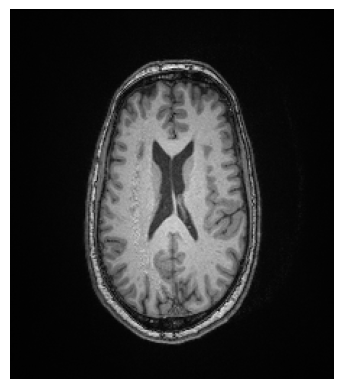

In [ ]:
plt.imshow(sample_image, cmap="gray")
plt.axis("off")
plt.show()

In [ ]:
sample_image_pil = Image.fromarray(sample_image)
sample_image_pil = sample_image_pil.convert('L')
sample_image_pil.save("test_image_slice.jpg")

In [ ]:
cv2.imwrite("test_image_slice_cv.jpg", sample_image)

True

In [ ]:
# shape = sample_image.shape

image_scaled = minmax_scale(sample_image.ravel(), feature_range=(0,255)).reshape(sample_image.shape)

In [ ]:
cv2.imwrite("test_image_slice_cv_scaled.jpg", image_scaled)

True